# Introduction

Human Activity Recognition is the task of predicting the physical activity being performed by a person based on sensor measurements from a wearable device. In this project, our goal is to predict the activity of a user using data collected from a smartphone's accelerometer and gyroscope. This is a multi-class classification problem, with 12 possible classes:

- WALKING
- WALKING UPSTAIRS
- WALKING DOWNSTAIRS
- SITTING
- STANDING
- LAYING
- STAND_TO_SIT
- SIT_TO_STAND
- SIT_TO_LIE
- LIE_TO_SIT
- STAND_TO_LIE
- LIE_TO_STAND

The dataset used in this project contains time-series data from the accelerometer and gyroscope sensors, as well as additional derived features such as jerk signals and Fourier-transformed frequency domain signals. The raw sensor data has been pre-processed to remove noise and separate the gravitational and body motion components of the acceleration signal.

Our task is to use this data to build a machine learning model that can accurately predict the activity of the user based on the sensor measurements. We will use the training dataset to train our model, and then evaluate its performance on the testing dataset.

The ultimate goal of this project is to build a model that can be used in real-world applications to monitor and track human activity. This could have important applications in fields such as healthcare and fitness tracking, where accurate activity recognition can help to improve patient outcomes and promote healthy behaviors.

**<H2>Part One</H2>**

**RNN Model1** is focused on creating a recurrent neural network (RNN) model to classify the activities performed by users into three main categories: 

- WALKING
- WALKING UPSTAIRS
- WALKING DOWNSTAIRS
- SITTING
- STANDING
- LAYING
- POS (Postural transitions): STAND_TO_SIT, SIT_TO_STAND, SIT_TO_LIE, LIE_TO_SIT, STAND_TO_LIE and LIE_TO_STAND

Using X_train, y_train, X_test and y_test.

**RNN Model2** is focused on creating a recurrent neural network (RNN) model to classify the activities performed by users into three main categories: 

- MOT (Movement on foo): WALKING, WALKING_UPSTAIRS and WALKING_DOWNSTAIRS
- SIT (Sedentary inactivity): SITTING, STANDING and LAYING
- POS (Postural transitions): STAND_TO_SIT, SIT_TO_STAND, SIT_TO_LIE, LIE_TO_SIT, STAND_TO_LIE and LIE_TO_STAND

Using X_train, y_train, X_test and y_test.


**<H2>Part two</H2>**

Part two of the project involves creating a time series dataframe from the separated files for accelerometer (Acc) and gyroscope (Gyro) signals. This will be achieved by collecting readings at fixed time intervals, to create a data point that represents the values of the accelerometer and gyroscope at that point in time. The time series dataframe will be created by concatenating these data points along the time axis to create a sequence of data that represents the user's activity.

Once the time series dataframe has been created, it will be used for training a Long Short-Term Memory (LSTM) model to predict the user's activity from the pre-activity readings. The LSTM model will be trained to classify the activities into 6 classes: 
- WALKING
- WALKING_UPSTAIRS
- WALKING_DOWNSTAIRS
- SITTING
- STANDING
- LAYING
- POS (Postural transitions): STAND_TO_SIT, SIT_TO_STAND, SIT_TO_LIE, LIE_TO_SIT, STAND_TO_LIE and LIE_TO_STAND


Using files in RawData folder **acc_expXX_userYY** and **gyro_expXX_userYY**


# Libraries

In [ ]:
!pip install pygwalker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 707.5/707.5 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.3 MB/s eta 0:00:00


In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import math
import warnings
import pandas as pd
import numpy as np
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
import pygwalker as pyg
from sklearn.manifold import TSNE
from glob import glob
from scipy import stats

import keras
from keras import backend as K
from keras.models import Sequential,load_model
from keras.layers import Dense, SimpleRNN, Dropout,LSTM
from keras.layers.core import Activation
from keras.utils import get_custom_objects,pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split


#Methods

In [ ]:
def _plot_count(x, data,hue='',figsize_w= 20,figsize_h= 10,plt_title='',x_label ='',y_label=''):
  plt.figure(figsize = (figsize_w,figsize_h))

  if len(hue) == 0:
    sns.countplot(x = x, data = data);
  else:
     sns.countplot(hue=hue,x = x, data = data);
  plt.title(plt_title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.show()

def _plot_facetgrid(
    df,
    hue,
    column_name,
    palette="Set0",
    desat=0.50,
    size=5,
    aspect=4,
    hist=False): 
  sns.set_palette(palette, desat=desat)
  facetgrid = sns.FacetGrid(df, hue=hue, size=size,aspect=aspect)
  facetgrid.map(sns.distplot,column_name, hist=hist).add_legend()

def _plot_facetgrids(df, hue, column_names, palette="Set0", desat=0.50, size=5, aspect=4, hist=False):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
    num_cols = 3
    num_rows = int(np.ceil(len(column_names) / num_cols))
    sns.set_palette(palette, desat=desat)
    facetgrid = sns.FacetGrid(df, hue=hue, size=size,aspect=aspect, col_wrap=num_cols)
    for i, column_name in enumerate(column_names):
        row = int(i / num_cols)
        col = i % num_cols
        facetgrid.map(sns.distplot, column_name, hist=hist).add_legend()
        facetgrid.axes[row * num_cols + col].set_title(column_name)

def tsne_ptl(
    df,
    drop_columns,
    hue,
    random_state = 40,
    n_components = 2, #the number of dimensions of the embedded space
    verbose = 1,  #to used with  random seed
    perplexity = 50, #balance between preserving local and global structure when transforming high-dimensional data into a lower-dimensional space.
    n_iter = 2000):
  tsne_data = df.drop(drop_columns, axis = 1)
  %time
  tsne = TSNE(random_state = random_state, n_components = n_components, verbose = verbose, perplexity = perplexity, n_iter = n_iter).fit_transform(tsne_data)
  plt.figure(figsize = (12,8))
  sns.scatterplot(x = tsne[:,0], y = tsne[:,1], hue = df[hue], palette = "bright")


def get_file_paths(folder):
   return sorted(glob(folder))

def import_Raw_Data2344(folder):
    #get a list of paths for all files in the RawData folder
    paths = get_file_paths(folder) 

    # Creating a dictionary where all dataframes will be stored
    _dic = {}

    # acc columns names
    acc_cols = ['accX', 'accY', 'accZ']

    # gyro columns names
    gyro_columns = ['gyroX', 'gyroY', 'gyroZ']

    # store "acc and gyro files" into a data dictionnary.
    # The indexes of the acc files range from 1 to 61, 
    # and the indexes of the gyro files range from 62 to 122.
    for path_index in range(0, 61):

        # file name only without "acc" or "gyro"
        dic_key = paths[path_index][-16:-4]

        # open the txt file
        opened_file =open(paths[path_index],'r')

        acc_file_content=[]

        # convert content from text format to float
        for row in opened_file:
            acc_file_content.append([float(item) for item in row.split()])

        # ==> 2D numpy array with columns names
        data=np.array(acc_file_content)
        acc_df = pd.DataFrame(data=data, columns=acc_cols)

        # the corresponding gyroscope data file can be obtained by shifting the path_index by 61
        shift = 61
        opened_file =open(paths[path_index + shift],'r')

        # Create a list
        gyro_file_content=[]

        # convert content from text format to float
        for row in opened_file:
            gyro_file_content.append([float(item) for item in row.split()])

        # ==> 2D numpy array with columns names
        data=np.array(gyro_file_content)
        gyro_df = pd.DataFrame(data=data, columns=gyro_columns)

        # concatenate acc_df and gyro_df in one DataFrame
        signals_df = pd.concat([acc_df, gyro_df], axis=1)

        # Store this new DataFrame in the dictionary
        _dic[dic_key] = signals_df

    return _dic

def plot_signal(
    df,
    signal_type,
    fig_title='fig_title',
    fig_x_title='Time(in seconds)',
    fig_y_title='Acceleration',
    x_legend_title='x',
    y_legend_title='y',
    z_legend_title='z',
    width = 20,
    height = 5,
    colors=['r','b','g'],
    legend_loc = "upper left"
):
# time	start_point	end_point	experiment_id	user_id	activity_id	acc_x	acc_y	acc_z	gyro_x	gyro_y	gyro_z
    if signal_type=='a':
      x_data=df[df.columns[6]]
      y_data=df[df.columns[7]]
      z_data=df[df.columns[8]]
    elif signal_type=='g':
      x_data=df[df.columns[9]]
      y_data=df[df.columns[10]]
      z_data=df[df.columns[11]]


    # generate time duration (the duration between two rows is 1/50=0.02 second)
    freq = 50 #50Hz
    time_points=[1/float(freq) *r for r in range(df.shape[0])]
    fig = plt.figure(figsize=(width,height))

    # ploting the signals data
    plt.plot(time_points,x_data,color=colors[0],label=x_legend_title)
    plt.plot(time_points,y_data,color=colors[1],label=y_legend_title)
    plt.plot(time_points,z_data,color=colors[2],label=z_legend_title)

    plt.title(fig_title)
    plt.xlabel(fig_x_title)
    plt.ylabel(fig_y_title)
  
    # figure's legends location
    plt.legend(loc=legend_loc)

    plt.show()

def get_windows_activities_user79678(df):
  user_Ids = sorted(df['user_Id'].unique())
  activity_Ids = sorted(df['activity_Id'].unique())

  cols = list(map(lambda Id: "activity_" + str(int(Id)), activity_Ids))
  indexs = list(map(lambda Id: "user_" + str(int(Id)), user_Ids))

  # initialize data array
  data = np.zeros((len(user_Ids), len(activity_Ids)))

  # loop over users and activities
  for i, user_ID in enumerate(user_Ids):
      for j, activity_ID in enumerate(activity_Ids):
          # filter the dataframe by user and activity
          filtered_df = df[(df["user_Id"] == user_ID) & (df["activity_Id"] == activity_ID)]
          # count the number of rows in the filtered dataframe
          count = len(filtered_df)
          # store the count in the data array
          data[i, j] = count

  return pd.DataFrame(data = data,columns=cols,index=indexs)

def df_balance(df,group_by_column,classes):
  # group data by 'group_by_column' and find the total number of rows 
  total = (df.groupby(by=group_by_column).size()).values

  for index in range(len(total)):
    p = total[index] / len(df) * 100
    print('%s, total=%d, percentage=%.3f' % (classes[index], total[index], p))


def load_experiment_data(column_names,labels_df,raw_data_path,sensor_type):

  # Create an empty list to store the data DataFrames
  activity_data_dfs = []

    # Iterate over the rows in the labels DataFrame
  for i, row in labels_df.iterrows():

      # Get the file paths for the sensor data files
      file_path = os.path.join(raw_data_path, "{}_exp{:02d}_user{:02d}.txt".format(sensor_type,row["experiment_id"], row["user_id"]))

      # Load the sensor data files into pandas DataFrames
      data_df = pd.read_csv(file_path, header=None, sep='\s+')

      # Get the start and end points for the activity segment
      start_point = row["start_point"]
      end_point = row["end_point"]

      # Extract the sensor data for the activity segment
      activity_data_df = data_df.iloc[start_point:end_point+1, :]

      # Add a column indicating the sensor type
      activity_data_df["sensor_type"] = sensor_type


      # Rename the column names of the activity data DataFrame
      activity_data_df.columns = ["x", "y", "z", "sensor_type"]

      # Add columns for the activity ID, user ID, experiment ID, start point, and end point
      activity_data_df["activity_id"] = row["activity_id"]
      activity_data_df["user_id"] = row["user_id"]
      activity_data_df["experiment_id"] = row["experiment_id"]
      activity_data_df["start_point"] = start_point
      activity_data_df["end_point"] = end_point

      # Calculate the time for each sample
      start_time = start_point / 50.0  # Convert start point to seconds
      end_time = end_point / 50.0      # Convert end point to seconds
      time = [start_time + i / 50.0 for i in range(len(activity_data_df))]
      activity_data_df["time"] = time

      # Reorder the columns of the activity data DataFrame
      activity_data_df = activity_data_df[column_names]

      # Add the activity data DataFrame to the list
      activity_data_dfs.append(activity_data_df)

  # Concatenate the activity data DataFrames into a single DataFrame
  return pd.concat(activity_data_dfs, ignore_index=True)

def plot_pred_result(pred_labels,true_labels,title, x_label,y_label,legend_labels):
  sns.set_style("darkgrid")
  plt.figure(figsize=(15, 6))
  plt.title(title)
  sns.lineplot(data=pred_labels)
  sns.lineplot(data=true_labels)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend(title=None, labels=legend_labels)
  plt.show()

# Configuration

In [ ]:
# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
google_driver_path = '/content/gdrive/My Drive/IoT Final Project/HAPT Data Set/'

In [ ]:
# Set the warning filter to "ignore"
warnings.filterwarnings("ignore")



```
# This is formatted as code
```

# Part One

## Load Data

In [ ]:
# Read the training data files:
# X_train.txt
# y_train.txt
# subject_id_train.txt: each row identifies the subject who performed the activity for each window sample. Its range is from 1 to 30.
X_train_df = pd.read_csv(google_driver_path + 'Train/X_train.txt', header=None, sep='\s+')
y_train_df = pd.read_csv(google_driver_path + 'Train/y_train.txt', header=None, sep='\s+')
users_train_df = pd.read_csv(google_driver_path + 'Train/subject_id_train.txt', header=None, sep='\s+')

In [ ]:
# Read the test data files
# X_test.txt
# y_test.txt
# subject_id_test.txt: each row identifies the subject who performed the activity for each window sample. Its range is from 1 to 30.
X_test_df = pd.read_csv(google_driver_path + 'Test/X_test.txt', header=None, sep='\s+')
y_test_df = pd.read_csv(google_driver_path + 'Test/y_test.txt', header=None, sep='\s+')
users_test_df = pd.read_csv(google_driver_path + 'Test/subject_id_test.txt', header=None, sep='\s+')

In [ ]:
# Read the activity labels file
# activity_labels.txt: links the activity ID with their activity name.
activity_labels_df = pd.read_csv(google_driver_path + 'activity_labels.txt', header=None, sep='\s+', names=['activity_id', 'activity_name'])

In [ ]:
# Read the features file
# features.txt: list of all features.
features_df = pd.read_csv(google_driver_path + 'features.txt', header=None, sep='\s+', names=['feature_name'])
features_df.insert(0, 'feature_id', range(0, len(features_df)))

In [ ]:
# train X and y shapes
print('X_train Shape:',X_train_df.shape)
print('y_train Shape:',y_train_df.shape)

X_train Shape: (7767, 561)
y_train Shape: (7767, 1)


In [ ]:
# test X and y shapes
print('X_test Shape:',X_test_df.shape)
print('y_test Shape:',y_test_df.shape)

X_test Shape: (3162, 561)
y_test Shape: (3162, 1)


In [ ]:
# show all activities
# there are 12 activities:
# MOT (Movement on foo): WALKING, WALKING_UPSTAIRS and WALKING_DOWNSTAIRS
# SIT (Sedentary inactivity): SITTING, STANDING and LAYING
# POS (Postural transitions): STAND_TO_SIT, SIT_TO_STAND, SIT_TO_LIE, LIE_TO_SIT, STAND_TO_LIE and LIE_TO_STAND
activity_labels_df.head(len(activity_labels_df))

activity_id       activity_name
0             1             WALKING
1             2    WALKING_UPSTAIRS
2             3  WALKING_DOWNSTAIRS
3             4             SITTING
4             5            STANDING
5             6              LAYING
6             7        STAND_TO_SIT
7             8        SIT_TO_STAND
8             9          SIT_TO_LIE
9            10          LIE_TO_SIT
10           11        STAND_TO_LIE
11           12        LIE_TO_STAND

In [ ]:
# show all features
# there are 561 features:
features_df

feature_id                     feature_name
0             0                  tBodyAcc-Mean-1
1             1                  tBodyAcc-Mean-2
2             2                  tBodyAcc-Mean-3
3             3                   tBodyAcc-STD-1
4             4                   tBodyAcc-STD-2
..          ...                              ...
556         556      tBodyGyro-AngleWRTGravity-1
557         557  tBodyGyroJerk-AngleWRTGravity-1
558         558      tXAxisAcc-AngleWRTGravity-1
559         559      tYAxisAcc-AngleWRTGravity-1
560         560      tZAxisAcc-AngleWRTGravity-1

[561 rows x 2 columns]

##  Preparing Data

In [ ]:
# make a copy
X_train_df1 = X_train_df.copy()
X_test_df1 = X_test_df.copy()

X_train_df2 = X_train_df.copy()
X_test_df2 = X_test_df.copy()

The training and testing datasets use feature IDs as column names, so we need to replace those with their corresponding feature names from the features dataframe in order to improve clarity.

In [ ]:
X_train_df1.columns

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            551, 552, 553, 554, 555, 556, 557, 558, 559, 560],
           dtype='int64', length=561)

In [ ]:
X_test_df1.columns

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            551, 552, 553, 554, 555, 556, 557, 558, 559, 560],
           dtype='int64', length=561)

In [ ]:
#Replace feature_ids with their corresponding feature names from the features dataframe.
X_train_df1 = X_train_df1.rename(columns=features_df.set_index('feature_id')['feature_name'])
X_test_df1 = X_test_df1.rename(columns=features_df.set_index('feature_id')['feature_name'])

In [ ]:
X_train_df1.columns

Index(['tBodyAcc-Mean-1', 'tBodyAcc-Mean-2', 'tBodyAcc-Mean-3',
       'tBodyAcc-STD-1', 'tBodyAcc-STD-2', 'tBodyAcc-STD-3', 'tBodyAcc-Mad-1',
       'tBodyAcc-Mad-2', 'tBodyAcc-Mad-3', 'tBodyAcc-Max-1',
       ...
       'fBodyGyroJerkMag-MeanFreq-1', 'fBodyGyroJerkMag-Skewness-1',
       'fBodyGyroJerkMag-Kurtosis-1', 'tBodyAcc-AngleWRTGravity-1',
       'tBodyAccJerk-AngleWRTGravity-1', 'tBodyGyro-AngleWRTGravity-1',
       'tBodyGyroJerk-AngleWRTGravity-1', 'tXAxisAcc-AngleWRTGravity-1',
       'tYAxisAcc-AngleWRTGravity-1', 'tZAxisAcc-AngleWRTGravity-1'],
      dtype='object', length=561)

In [ ]:
X_test_df1.columns

Index(['tBodyAcc-Mean-1', 'tBodyAcc-Mean-2', 'tBodyAcc-Mean-3',
       'tBodyAcc-STD-1', 'tBodyAcc-STD-2', 'tBodyAcc-STD-3', 'tBodyAcc-Mad-1',
       'tBodyAcc-Mad-2', 'tBodyAcc-Mad-3', 'tBodyAcc-Max-1',
       ...
       'fBodyGyroJerkMag-MeanFreq-1', 'fBodyGyroJerkMag-Skewness-1',
       'fBodyGyroJerkMag-Kurtosis-1', 'tBodyAcc-AngleWRTGravity-1',
       'tBodyAccJerk-AngleWRTGravity-1', 'tBodyGyro-AngleWRTGravity-1',
       'tBodyGyroJerk-AngleWRTGravity-1', 'tXAxisAcc-AngleWRTGravity-1',
       'tYAxisAcc-AngleWRTGravity-1', 'tZAxisAcc-AngleWRTGravity-1'],
      dtype='object', length=561)

The users information can be found from the following files:
- subject_id_train.txt
- subject_id_test.txt. 

These files contain the users IDs for the corresponding rows in the X_train.txt and X_test.txt files, respectively.

Adding the folloing columns to the X_train DataFrame for further analysis:
- user_id
- activity_id
- activity_name

In [ ]:
# Training Dataset:
# user_id and activity_id will be added to the X_train DataFrame for further analysis.
subject_id_train = pd.read_csv(google_driver_path +'Train/subject_id_train.txt', header=None)
X_train_df1['user_id'] = subject_id_train.iloc[:, 0].values
X_train_df1['activity_id'] = y_train_df.iloc[:, 0].values
X_train_df1 = pd.merge(X_train_df1, activity_labels_df, on='activity_id')


In [ ]:
# Test dataset:
# user_id and activity_id will be added to the X_Test DataFrame for further analysis.
subject_id_test = pd.read_csv(google_driver_path +'Test/subject_id_test.txt', header=None)
X_test_df1['user_id'] = subject_id_test.iloc[:, 0].values
X_test_df1['activity_id'] = y_test_df.iloc[:, 0].values
X_test_df1 = pd.merge(X_test_df1, activity_labels_df, on='activity_id')

In [ ]:
X_train_df1[['user_id','activity_id','activity_name']].head(2)

user_id  activity_id activity_name
0        1            5      STANDING
1        1            5      STANDING

In [ ]:
X_test_df1[['user_id','activity_id','activity_name']].head(2)

user_id  activity_id activity_name
0        2            5      STANDING
1        2            5      STANDING

### Detecting and Handling Outliers

In [ ]:
X_train_df1.describe()

tBodyAcc-Mean-1  tBodyAcc-Mean-2  tBodyAcc-Mean-3  tBodyAcc-STD-1  \
count      7767.000000      7767.000000      7767.000000     7767.000000   
mean          0.038759        -0.000647        -0.018155       -0.599017   
std           0.101996         0.099974         0.089927        0.441481   
min          -1.000000        -1.000000        -1.000000       -1.000000   
25%           0.032037        -0.011209        -0.028448       -0.992140   
50%           0.038975        -0.002921        -0.019602       -0.914202   
75%           0.044000         0.004303        -0.011676       -0.246026   
max           1.000000         1.000000         1.000000        1.000000   

       tBodyAcc-STD-2  tBodyAcc-STD-3  tBodyAcc-Mad-1  tBodyAcc-Mad-2  \
count     7767.000000     7767.000000     7767.000000     7767.000000   
mean        -0.634424       -0.691270       -0.623886       -0.657884   
std          0.367558        0.321641        0.418113        0.348005   
min         -1.000000       -1.000000       -1.000000       -1.000000   
25%         -0.983570       -0.984661       -0.992902       -0.984131   
50%         -0.827970       -0.827696       -0.924421       -0.838559   
75%         -0.313069       -0.450478       -0.294903       -0.362671   
max          0.945956        1.000000        1.000000        0.960341   

       tBodyAcc-Mad-3  tBodyAcc-Max-1  ...  fBodyGyroJerkMag-Kurtosis-1  \
count     7767.000000     7767.000000  ...                  7767.000000   
mean        -0.740154       -0.360200  ...                    -0.625132   
std          0.272619        0.499259  ...                     0.302581   
min         -1.000000       -1.000000  ...                    -1.000000   
25%         -0.986661       -0.795613  ...                    -0.843966   
50%         -0.852735       -0.717007  ...                    -0.710071   
75%         -0.540521        0.054178  ...                    -0.503837   
max          1.000000        1.000000  ...                     0.911653   

       tBodyAcc-AngleWRTGravity-1  tBodyAccJerk-AngleWRTGravity-1  \
count                 7767.000000                     7767.000000   
mean                     0.016774                        0.018471   
std                      0.331326                        0.443540   
min                     -0.976580                       -1.000000   
25%                     -0.108225                       -0.261002   
50%                      0.017627                        0.029079   
75%                      0.167695                        0.314876   
max                      1.000000                        1.000000   

       tBodyGyro-AngleWRTGravity-1  tBodyGyroJerk-AngleWRTGravity-1  \
count                  7767.000000                      7767.000000   
mean                      0.009239                        -0.005184   
std                       0.601208                         0.477218   
min                      -1.000000                        -1.000000   
25%                      -0.470267                        -0.373565   
50%                       0.001515                        -0.005503   
75%                       0.496871                         0.352690   
max                       0.998702                         0.991288   

       tXAxisAcc-AngleWRTGravity-1  tYAxisAcc-AngleWRTGravity-1  \
count                  7767.000000                  7767.000000   
mean                     -0.485936                     0.050310   
std                       0.509278                     0.300866   
min                      -1.000000                    -1.000000   
25%                      -0.810953                    -0.047752   
50%                      -0.706619                     0.176777   
75%                      -0.488765                     0.246834   
max                       1.000000                     0.482229   

       tZAxisAcc-AngleWRTGravity-1      user_id  activity_id  
count                  7767.000000  7767.000000  7767.00000

In [ ]:
X_test_df1.describe()

tBodyAcc-Mean-1  tBodyAcc-Mean-2  tBodyAcc-Mean-3  tBodyAcc-STD-1  \
count      3162.000000      3162.000000      3162.000000     3162.000000   
mean          0.040530        -0.001695        -0.019453       -0.609770   
std           0.101559         0.102384         0.083897        0.405103   
min          -0.751552        -0.962639        -0.814359       -0.999715   
25%           0.031544        -0.011462        -0.028986       -0.990017   
50%           0.038861        -0.002700        -0.019488       -0.807078   
75%           0.043751         0.005224        -0.011233       -0.270904   
max           0.976950         0.989925         0.766017        0.465271   

       tBodyAcc-STD-2  tBodyAcc-STD-3  tBodyAcc-Mad-1  tBodyAcc-Mad-2  \
count     3162.000000     3162.000000     3162.000000     3162.000000   
mean        -0.631731       -0.711263       -0.636741       -0.654112   
std          0.360294        0.284112        0.379665        0.342661   
min         -0.999611       -0.999911       -0.999274       -0.999319   
25%         -0.979300       -0.981256       -0.991374       -0.980940   
50%         -0.686914       -0.738534       -0.828256       -0.707638   
75%         -0.358639       -0.487716       -0.324933       -0.403433   
max          1.000000        0.848957        0.439686        1.000000   

       tBodyAcc-Mad-3  tBodyAcc-Max-1  ...  fBodyGyroJerkMag-Kurtosis-1  \
count     3162.000000     3162.000000  ...                  3162.000000   
mean        -0.758061       -0.358429  ...                    -0.595537   
std          0.241093        0.479339  ...                     0.309507   
min         -0.999505       -0.893297  ...                    -0.985065   
25%         -0.983562       -0.793628  ...                    -0.828862   
50%         -0.778504       -0.673711  ...                    -0.681600   
75%         -0.578883        0.052758  ...                    -0.452381   
max          0.689027        0.909166  ...                     1.000000   

       tBodyAcc-AngleWRTGravity-1  tBodyAccJerk-AngleWRTGravity-1  \
count                 3162.000000                     3162.000000   
mean                     0.015090                        0.021202   
std                      0.329827                        0.442320   
min                     -1.000000                       -0.993402   
25%                     -0.111039                       -0.252667   
50%                      0.013685                        0.032937   
75%                      0.161560                        0.316195   
max                      0.998898                        0.986347   

       tBodyGyro-AngleWRTGravity-1  tBodyGyroJerk-AngleWRTGravity-1  \
count                  3162.000000                      3162.000000   
mean                      0.043183                        -0.020684   
std                       0.626639                         0.501336   
min                      -0.998898                        -0.990616   
25%                      -0.493294                        -0.438279   
50%                       0.043555                        -0.022624   
75%                       0.609499                         0.387438   
max                       1.000000                         1.000000   

       tXAxisAcc-AngleWRTGravity-1  tYAxisAcc-AngleWRTGravity-1  \
count                  3162.000000                  3162.000000   
mean                     -0.511371                     0.067774   
std                       0.506231                     0.326118   
min                      -0.983811                    -0.914248   
25%                      -0.828871                    -0.007741   
50%                      -0.728029                     0.175138   
75%                      -0.528704                     0.257544   
max                       0.829446                     1.000000   

       tZAxisAcc-AngleWRTGravity-1      user_id  activity_id  
count                  3162.000000  3162.000000  3162.00000

After examining the values of all columns in the dataset, it was observed that they all fell within the range of -1 to 1. Therefore, there are no outliers in the dataset.

### Checking for Missing Data

In [ ]:
# Count Null values in X_train
X_train_df1.isnull().sum()

tBodyAcc-Mean-1                0
tBodyAcc-Mean-2                0
tBodyAcc-Mean-3                0
tBodyAcc-STD-1                 0
tBodyAcc-STD-2                 0
                              ..
tYAxisAcc-AngleWRTGravity-1    0
tZAxisAcc-AngleWRTGravity-1    0
user_id                        0
activity_id                    0
activity_name                  0
Length: 564, dtype: int64

In [ ]:
# total Null values in X_train_df1
X_train_df1.isnull().values.sum()

0

In [ ]:
# Count Null values in X_test
X_test_df1.isnull().sum()

tBodyAcc-Mean-1                0
tBodyAcc-Mean-2                0
tBodyAcc-Mean-3                0
tBodyAcc-STD-1                 0
tBodyAcc-STD-2                 0
                              ..
tYAxisAcc-AngleWRTGravity-1    0
tZAxisAcc-AngleWRTGravity-1    0
user_id                        0
activity_id                    0
activity_name                  0
Length: 564, dtype: int64

In [ ]:
# total Null values in X_test
X_test_df1.isnull().values.sum()

0

### Visualizing Data for Analysis and Understanding

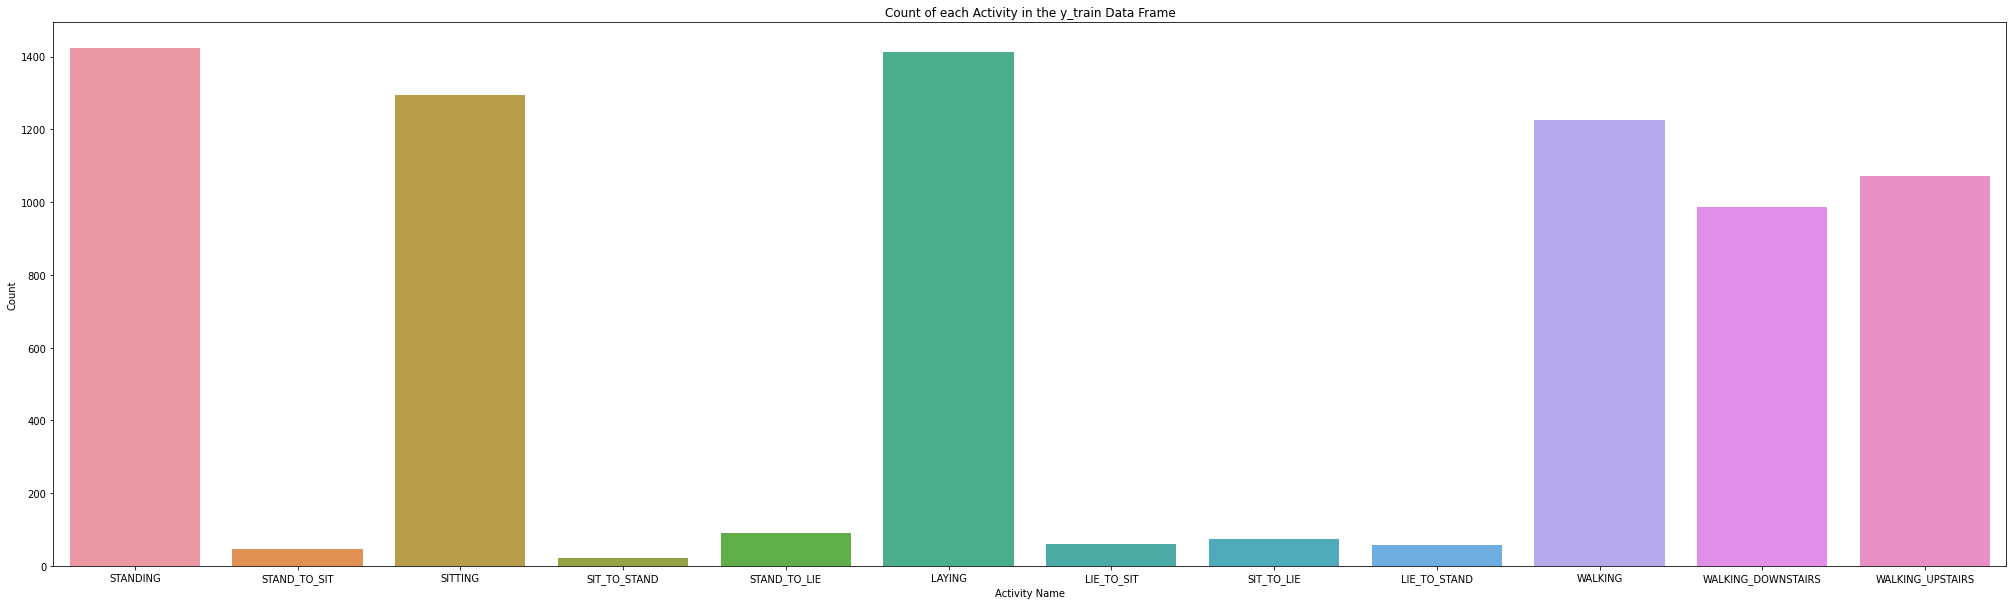

In [ ]:
_plot_count(
    x='activity_name',
    data=X_train_df1,
    plt_title='Count of each Activity in the y_train Data Frame',
    x_label ='Activity Name',
    y_label='Count',
    figsize_w= 35,
    figsize_h= 10)

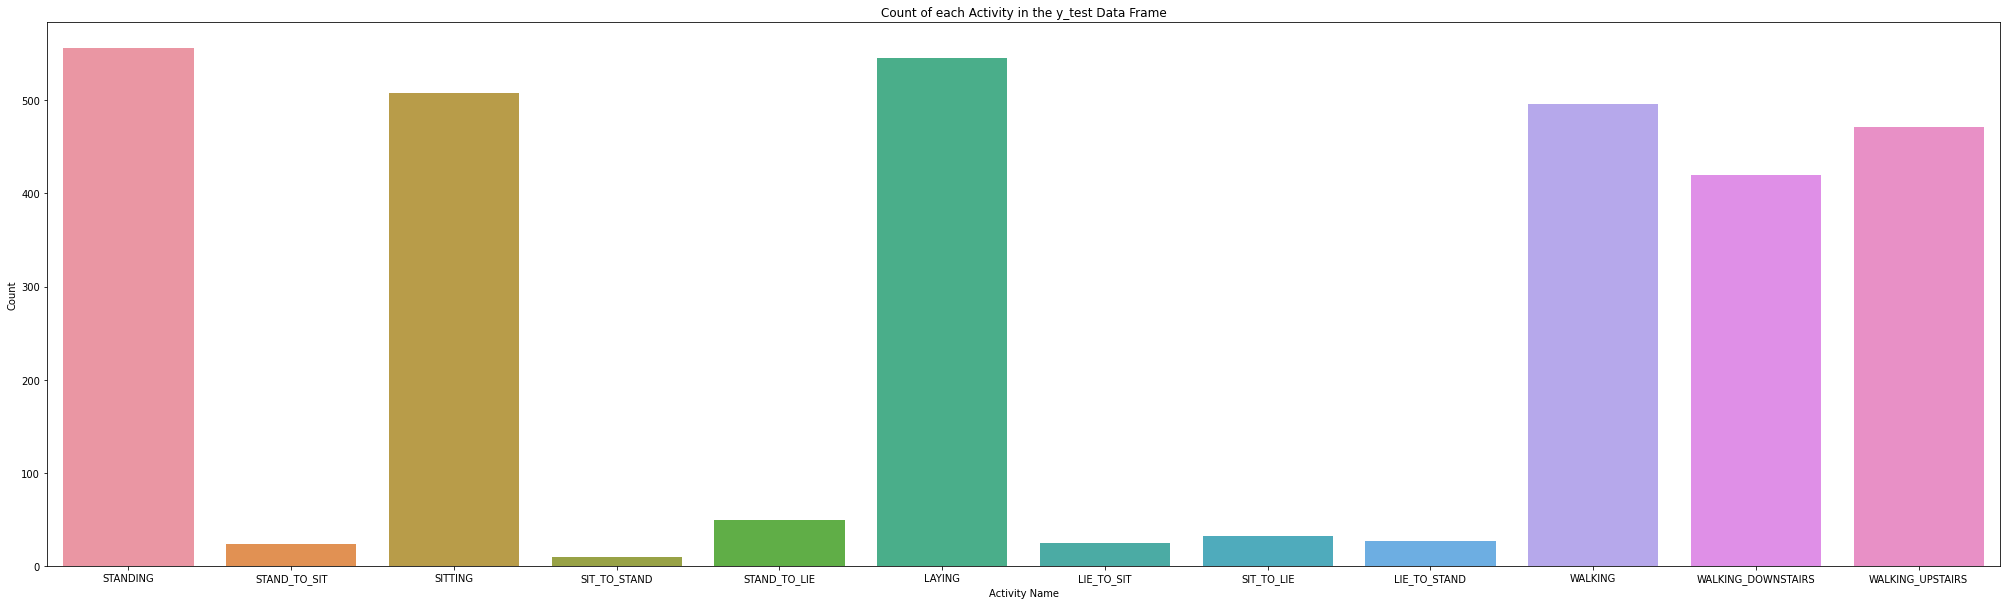

In [ ]:
_plot_count(
    x='activity_name',
    data=X_test_df1,
    plt_title='Count of each Activity in the y_test Data Frame',
    x_label ='Activity Name',
    y_label='Count',
    figsize_w= 35,
    figsize_h= 10)

The dataset is not balanced and that certain activity classes have significantly fewer observations than others, this may lead to biased results when training a machine learning model. it appears that the activities related to postural transitions have very few observations compared to the other activities.

It is possible to merge the postural transition activities into the main activities in order to balance the class distribution. we could consider:

- STAND_TO_SIT and LIE_TO_SIT as SITTING
- SIT_TO_LIE and STAND_TO_LIE as LAYING
- LIE_TO_STAND  and SIT_TO_STAND as STANDING

Also, removing the postural transition activities seems like a valid approach to balance the class distribution in the dataset. However, this approach might lead to the loss of some valuable information. 


I am going to create a new activity called 'POS (Postural transitions)' with ID 7 and map all postural transition activities (i.e., STAND_TO_SIT, LIE_TO_SIT, SIT_TO_LIE, STAND_TO_LIE, LIE_TO_STAND, and SIT_TO_STAND) to this new activity.

In [ ]:
# Train Dataset
unique_values = X_train_df1['activity_id'].unique()
print(unique_values)

[ 5  7  4  8 11  6 10  9 12  1  3  2]


In [ ]:
# Test Dataset
unique_values = X_test_df1['activity_id'].unique()
print(unique_values)

[ 5  7  4  8 11  6 10  9 12  1  3  2]


In [ ]:
# update the DataFrames
X_train_df1.loc[X_train_df1['activity_id'] > 6, 'activity_id'] = 7
X_train_df1.loc[X_train_df1['activity_id'] > 6, 'activity_name'] = 'POS'

X_test_df1.loc[X_test_df1['activity_id'] > 6, 'activity_id'] = 7
X_test_df1.loc[X_test_df1['activity_id'] > 6, 'activity_name'] = 'POS'

In [ ]:
# Train Dataset
act_id_unique_values = X_train_df1['activity_id'].unique()
act_name_unique_values = X_train_df1['activity_name'].unique()
print(act_id_unique_values)
print(act_name_unique_values)

[5 7 4 6 1 3 2]
['STANDING' 'POS' 'SITTING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


In [ ]:
# Test Dataset
act_id_unique_values = X_test_df1['activity_id'].unique()
act_name_unique_values = X_test_df1['activity_name'].unique()
print(act_id_unique_values)
print(act_name_unique_values)

[5 7 4 6 1 3 2]
['STANDING' 'POS' 'SITTING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


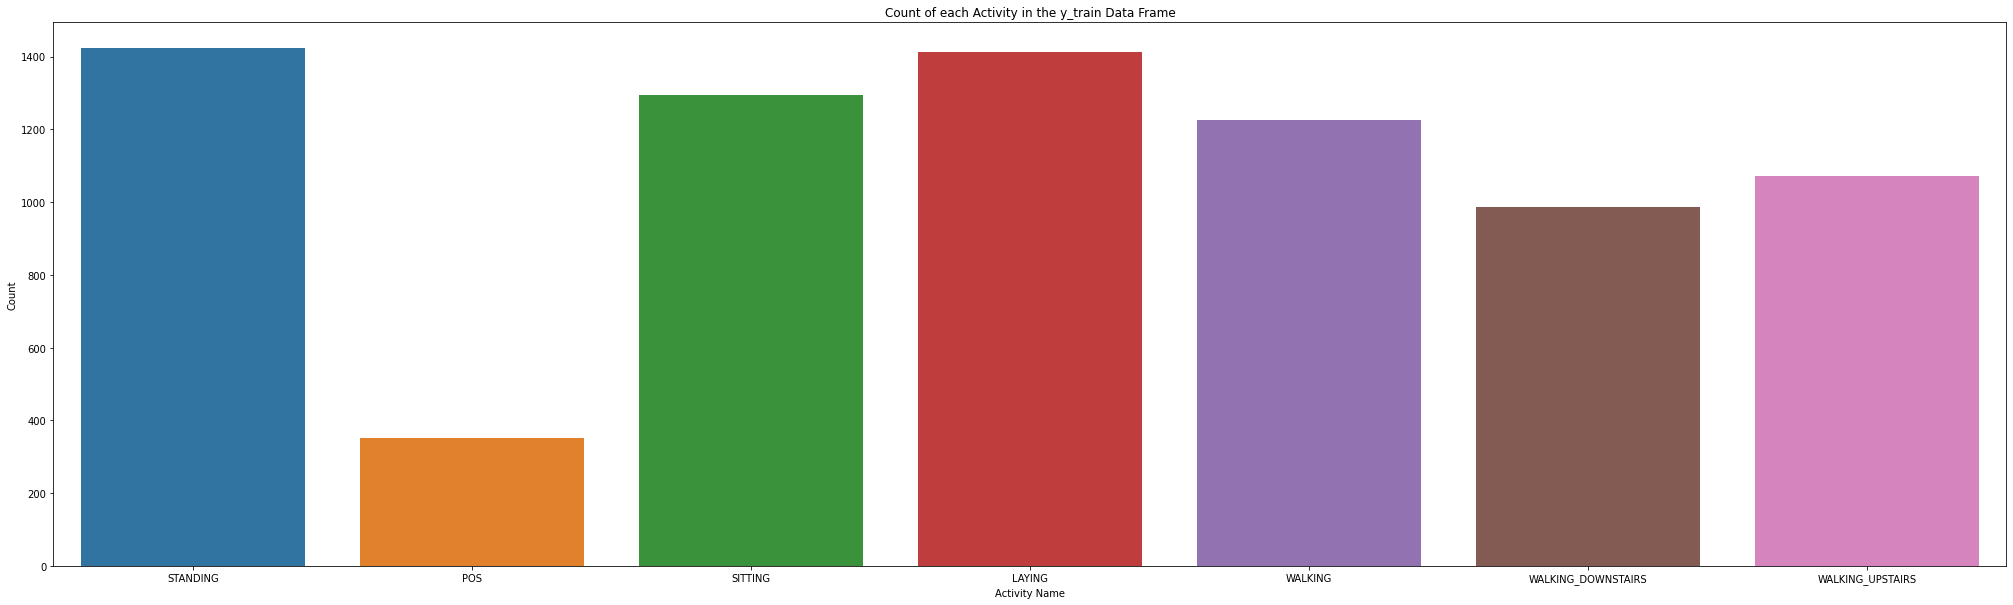

In [ ]:
_plot_count(
    x='activity_name',
    data=X_train_df1,
    plt_title='Count of each Activity in the y_train Data Frame',
    x_label ='Activity Name',
    y_label='Count',
    figsize_w= 35,
    figsize_h= 10)

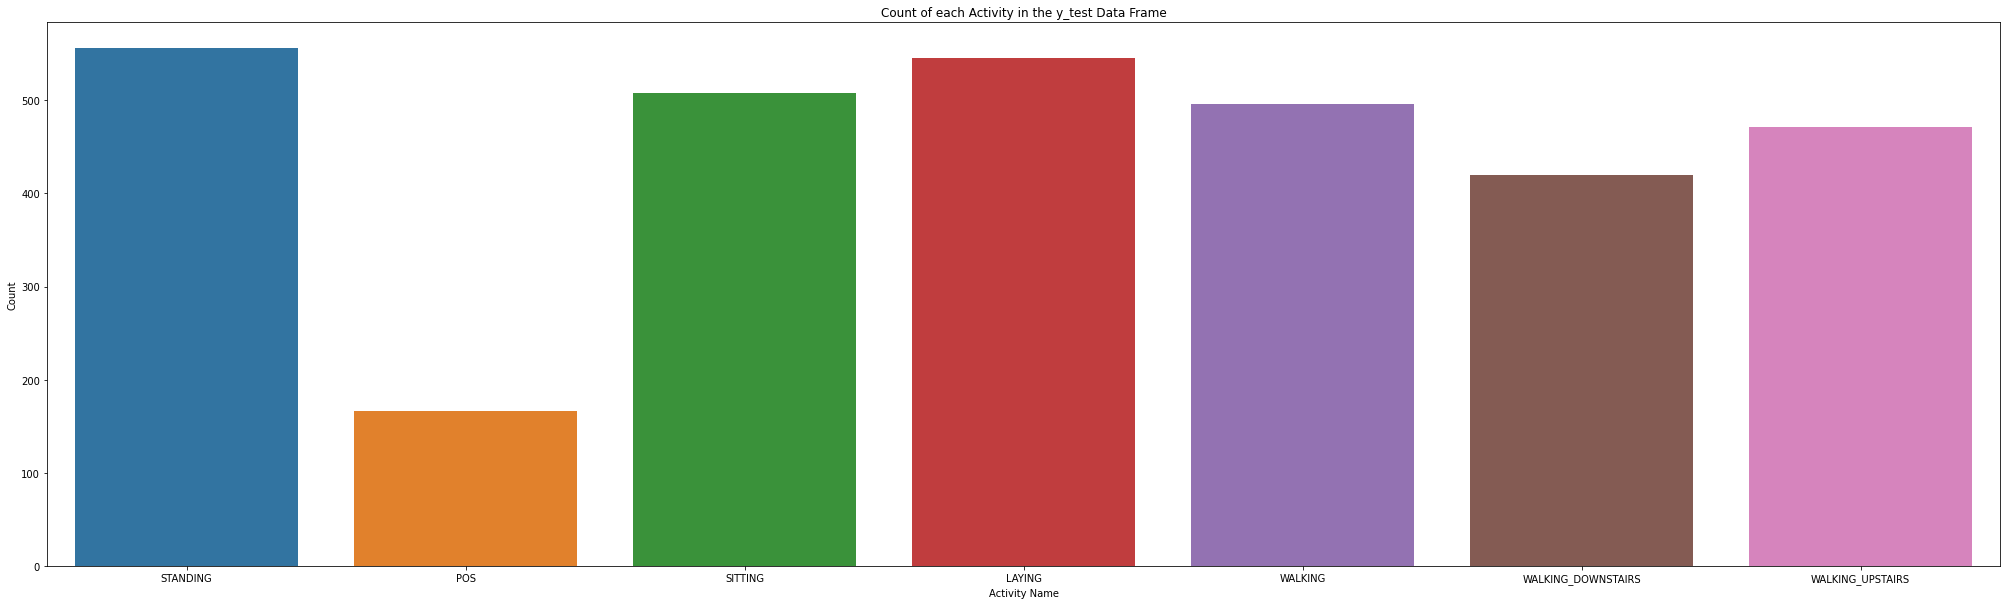

In [ ]:
_plot_count(
    x='activity_name',
    data=X_test_df1,
    plt_title='Count of each Activity in the y_test Data Frame',
    x_label ='Activity Name',
    y_label='Count',
    figsize_w= 35,
    figsize_h= 10)

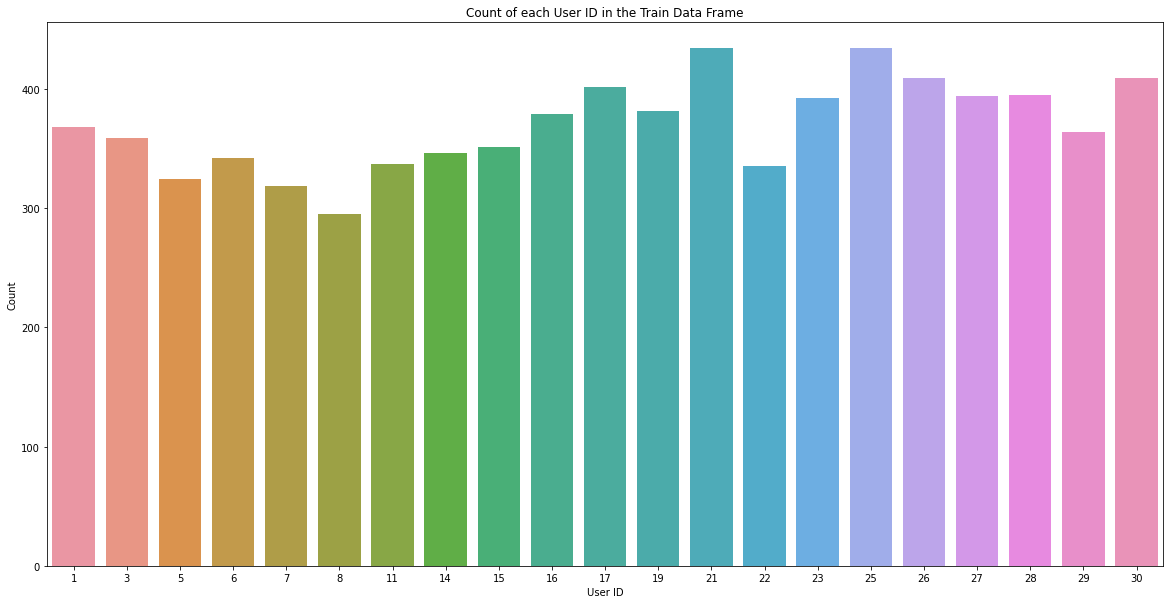

In [ ]:
_plot_count(
    x='user_id',
    data=X_train_df1,
    plt_title='Count of each User ID in the Train Data Frame',
    x_label ='User ID',
    y_label='Count')

It should be noted that the test dataset does not include all the users that are present in the training dataset.

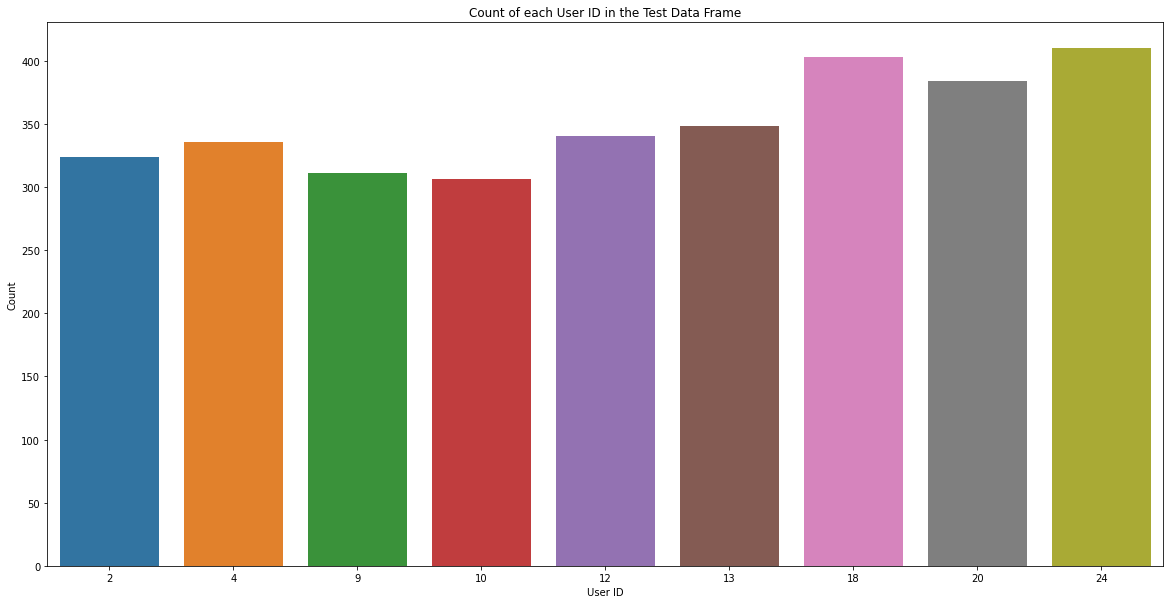

In [ ]:
_plot_count(
    x='user_id',
    data=X_test_df1,
    plt_title='Count of each User ID in the Test Data Frame',
    x_label ='User ID',
    y_label='Count')

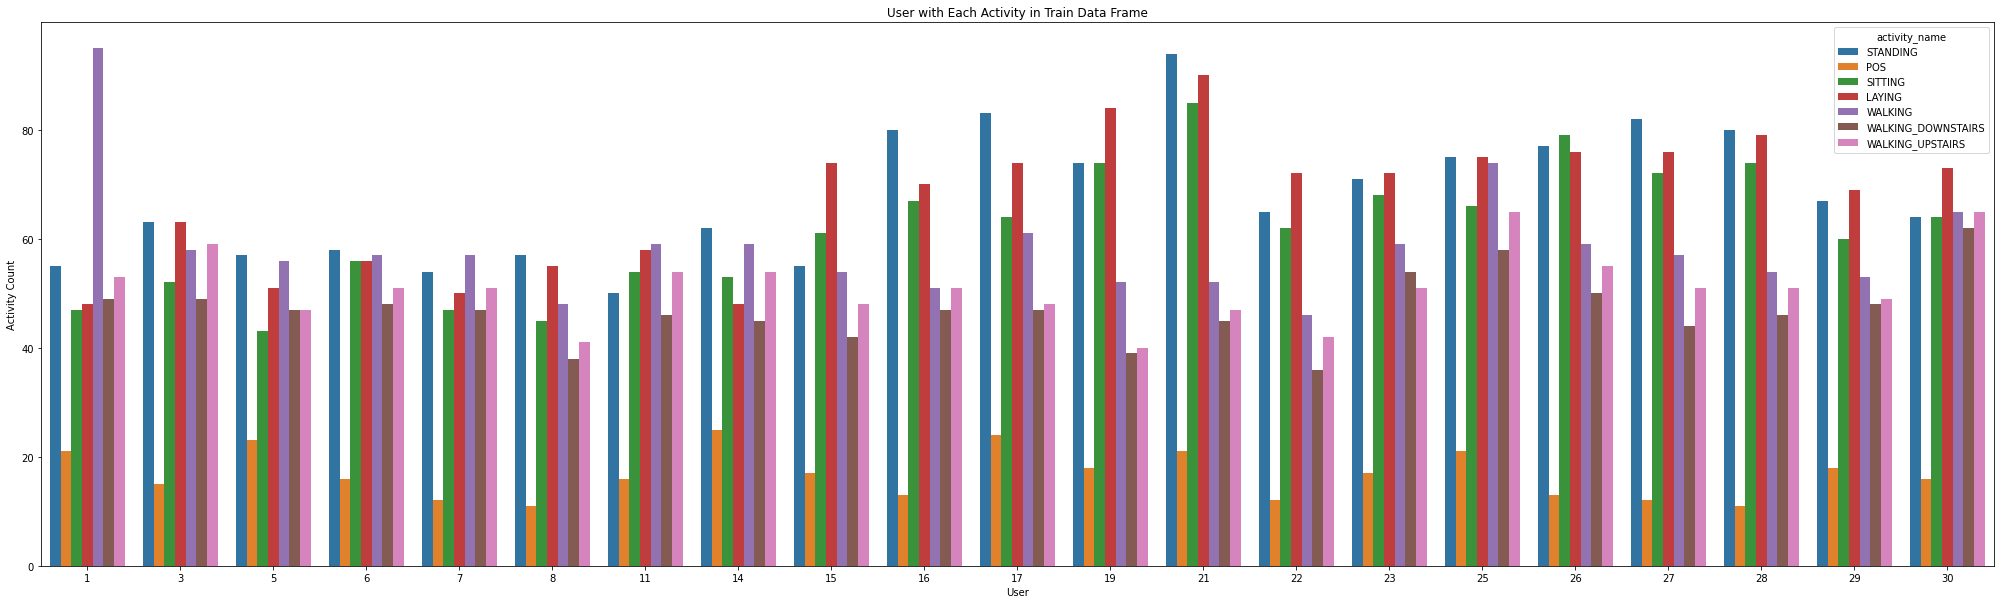

In [ ]:
_plot_count(
    x='user_id',
    hue='activity_name',
    data=X_train_df1,
    plt_title='User with Each Activity in Train Data Frame',
    x_label ='User',
    y_label='Activity Count',
    figsize_w= 35,
    figsize_h= 10)

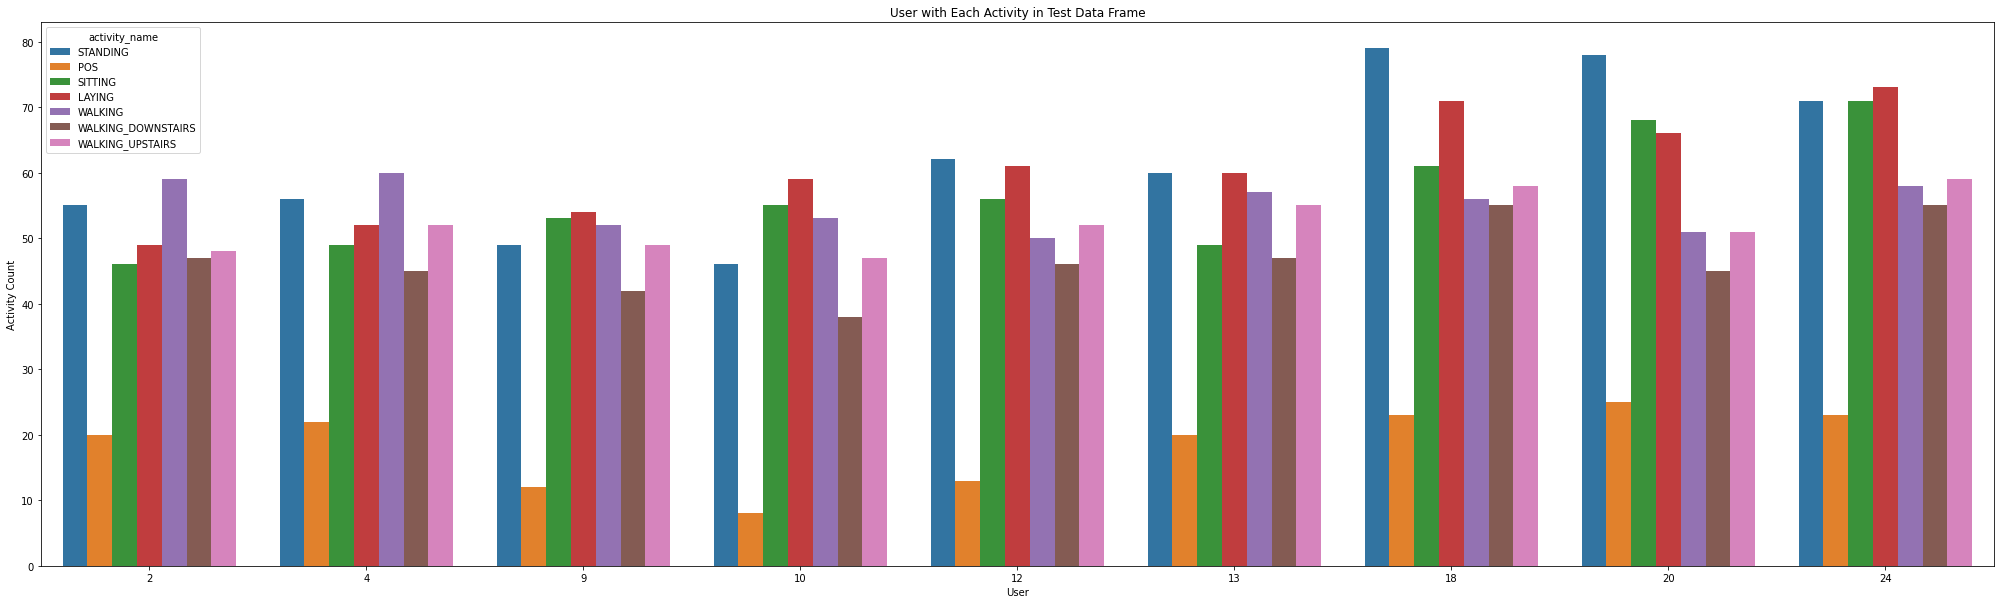

In [ ]:
_plot_count(
    x='user_id',
    hue='activity_name',
    data=X_test_df1,
    plt_title='User with Each Activity in Test Data Frame',
    x_label ='User',
    y_label='Activity Count',
    figsize_w= 35,
    figsize_h= 10)

As shown in the above graphics, the dataset appears to be well balanced, with a relatively equal number of observations for each subject and activity.

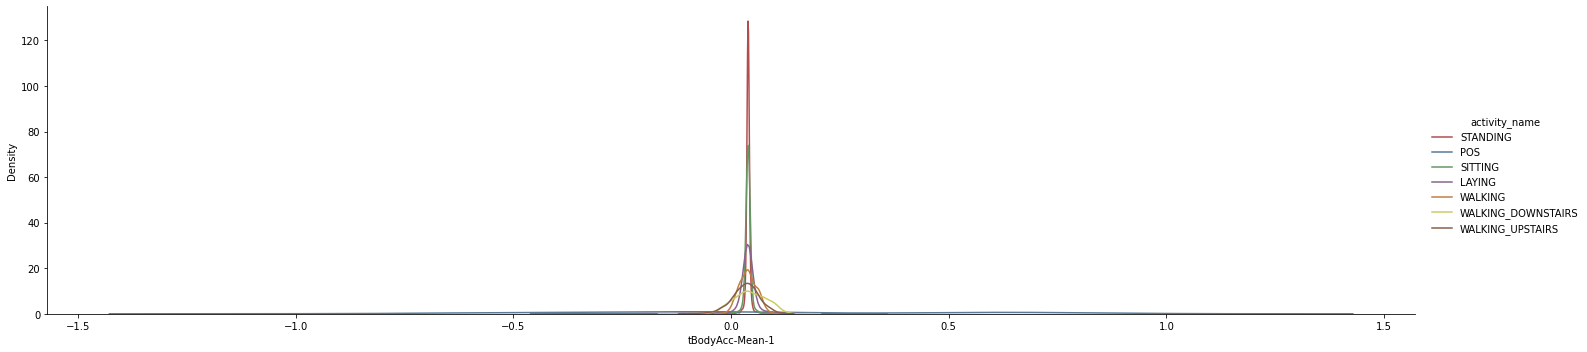

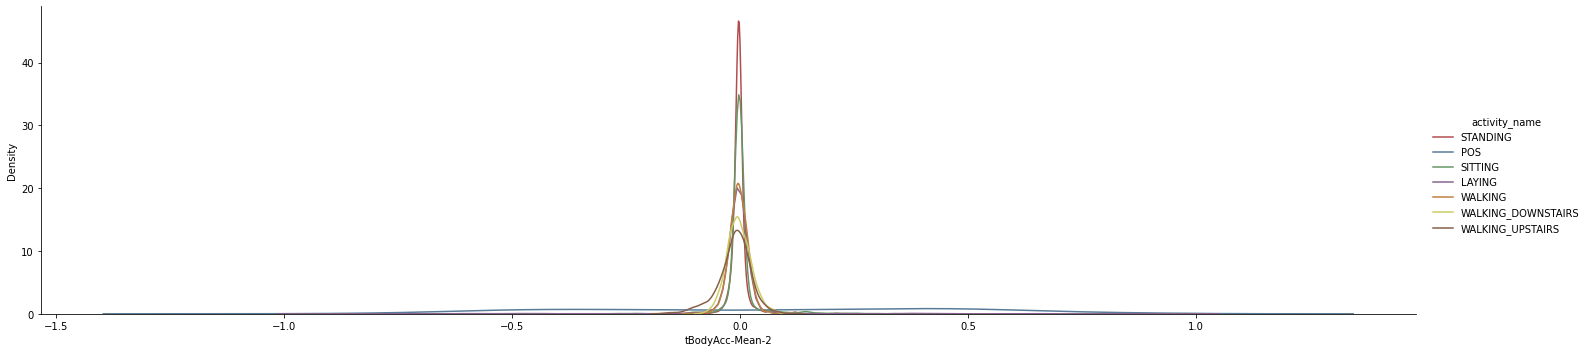

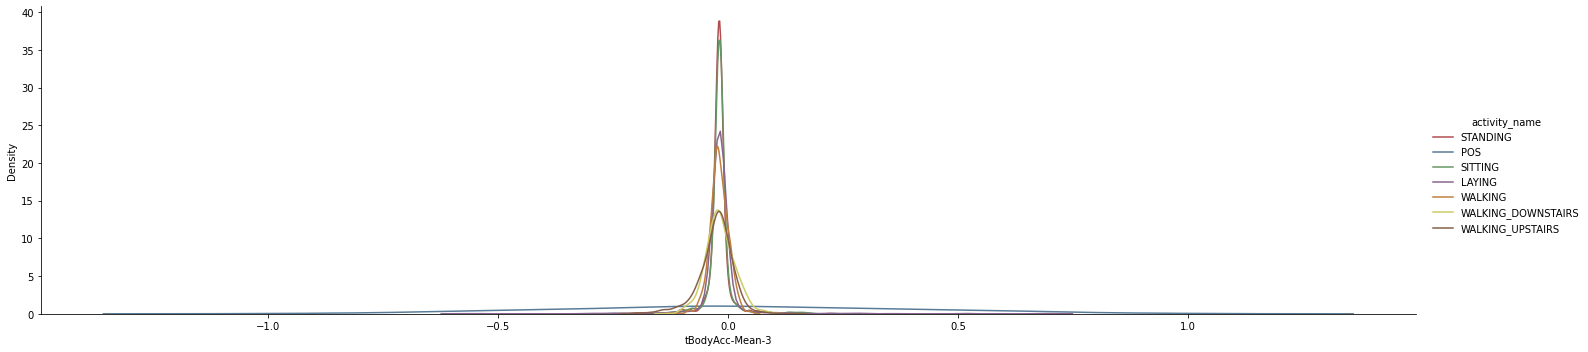

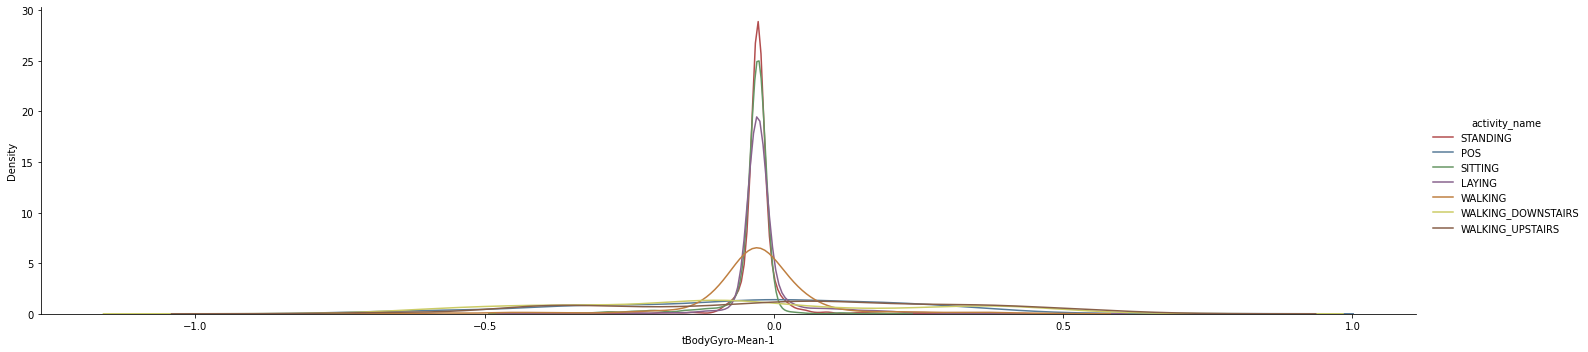

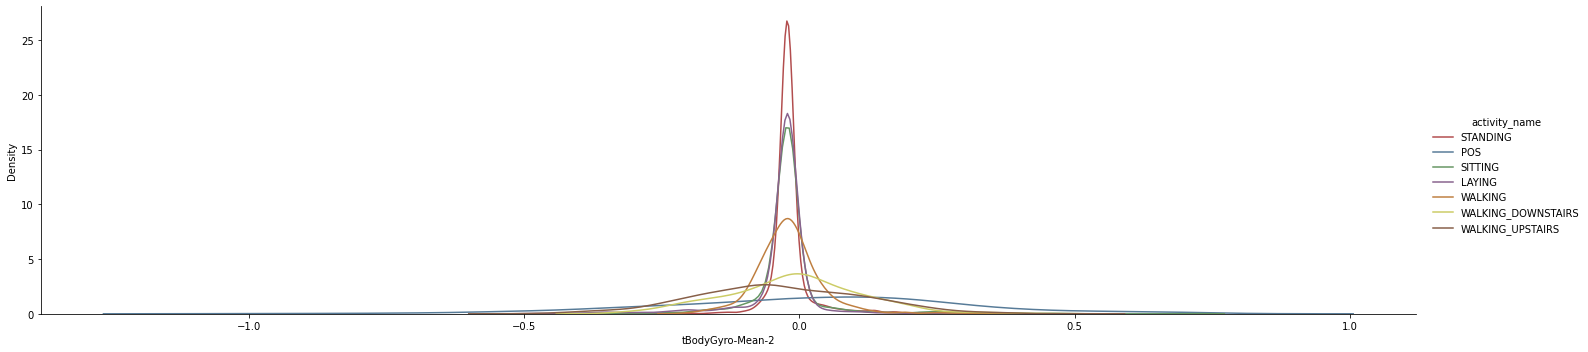

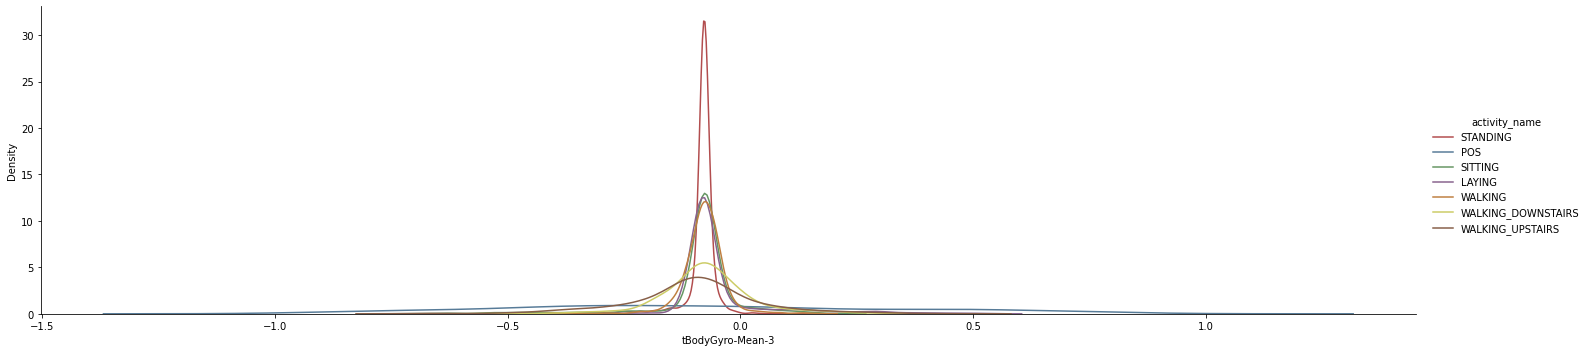

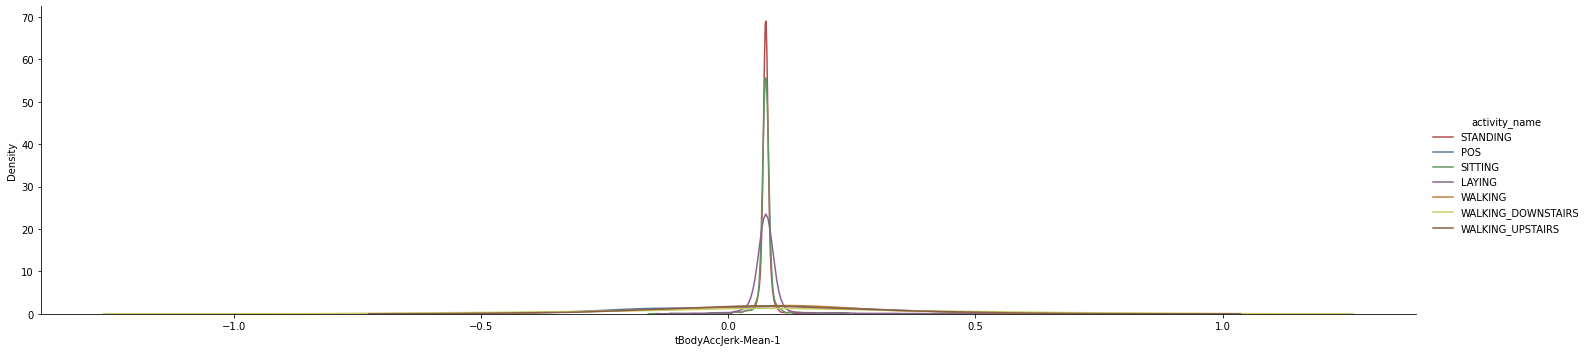

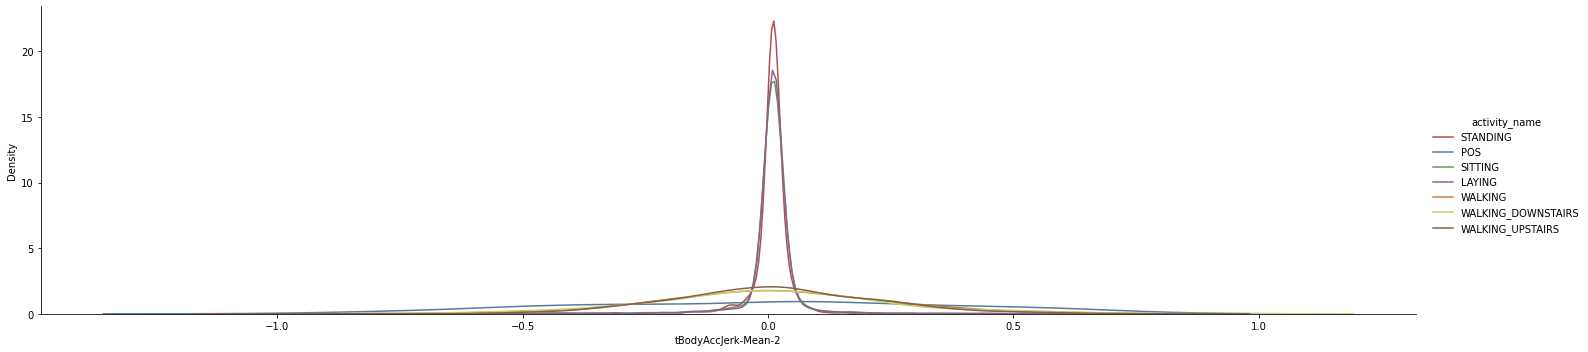

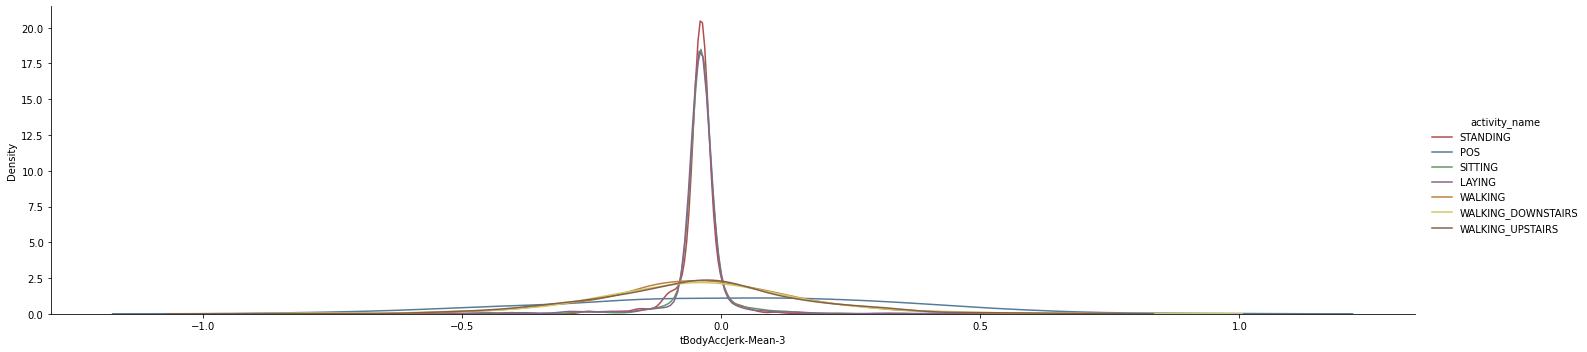

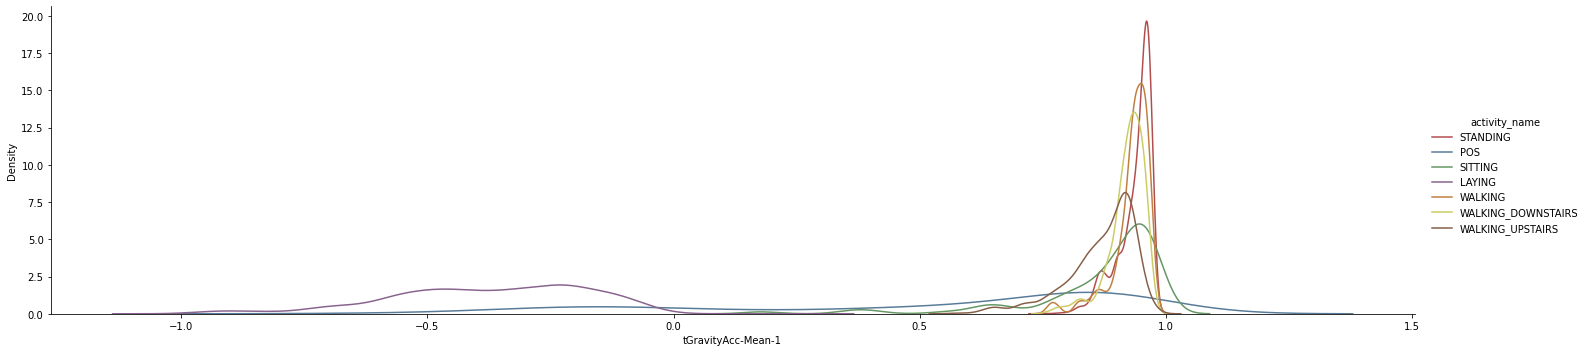

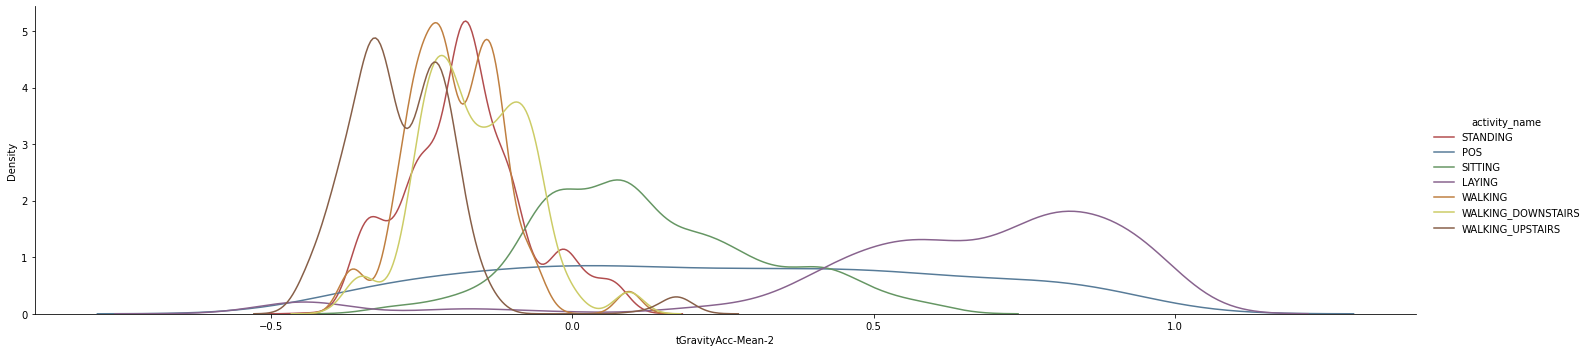

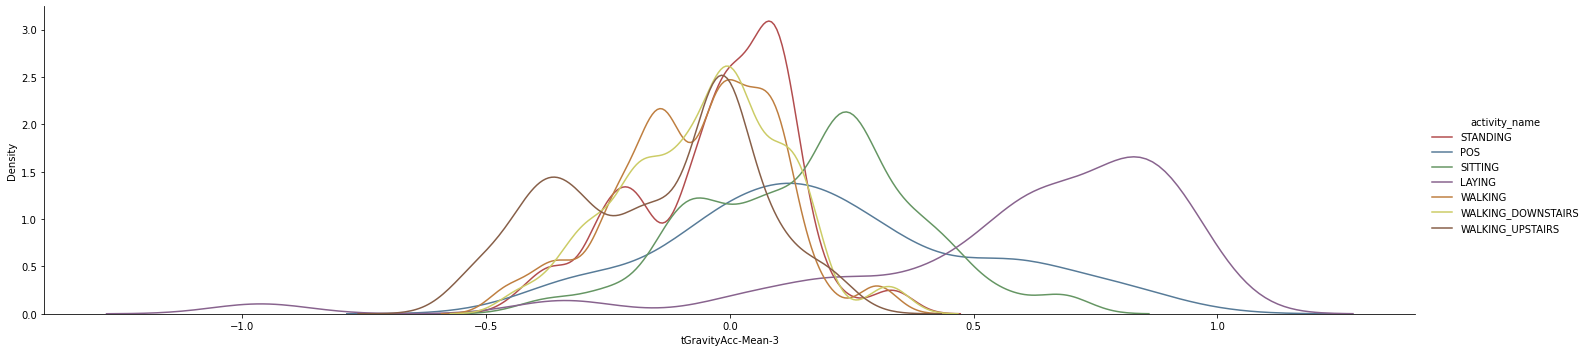

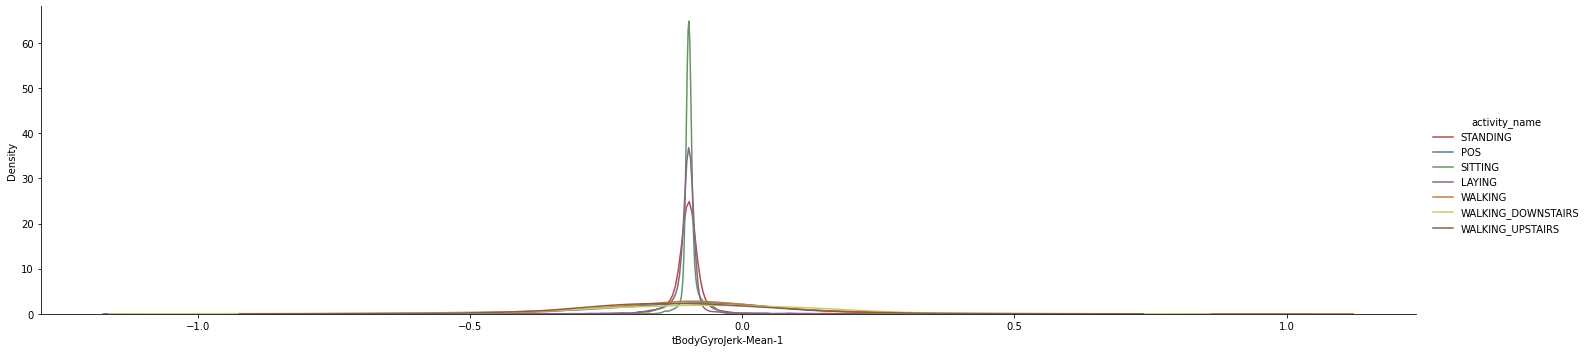

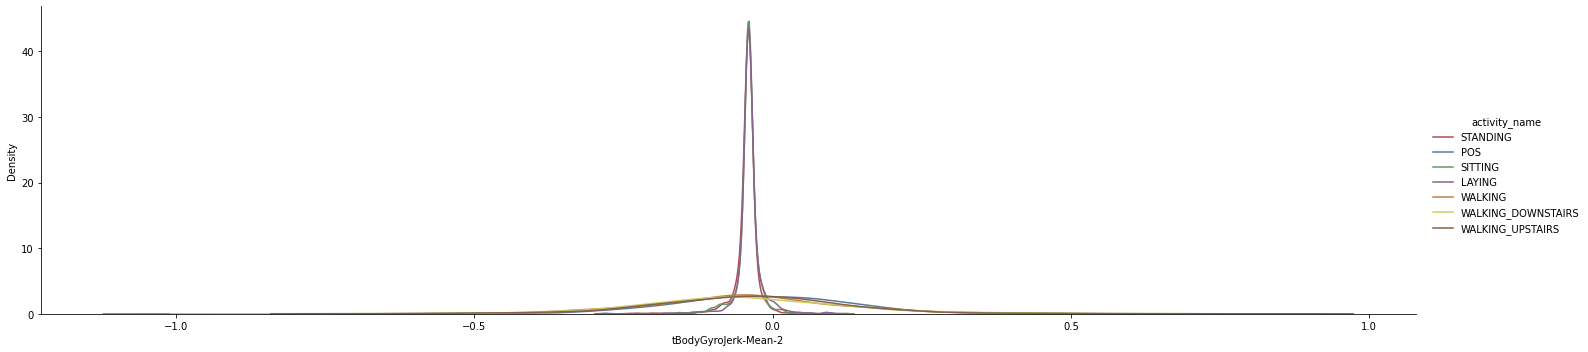

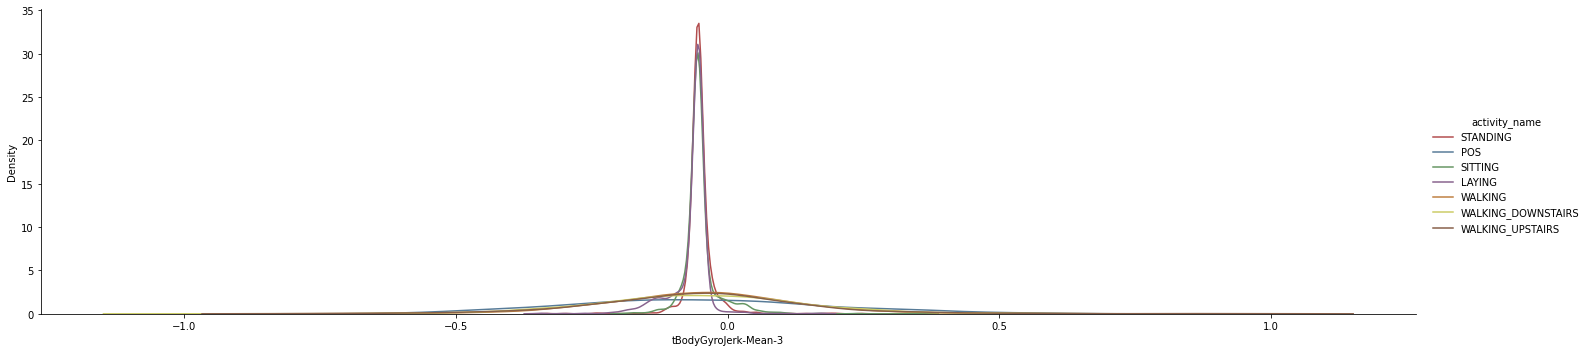

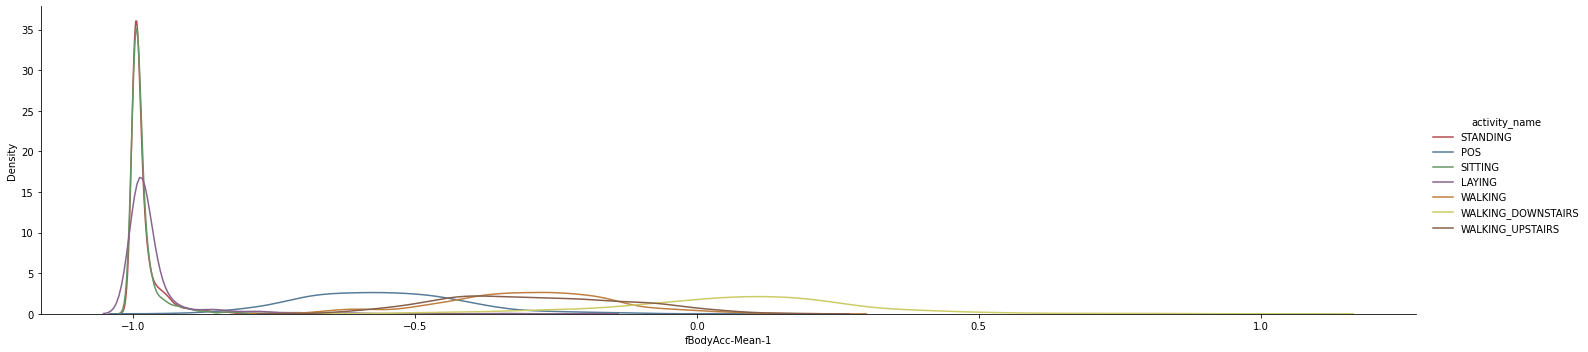

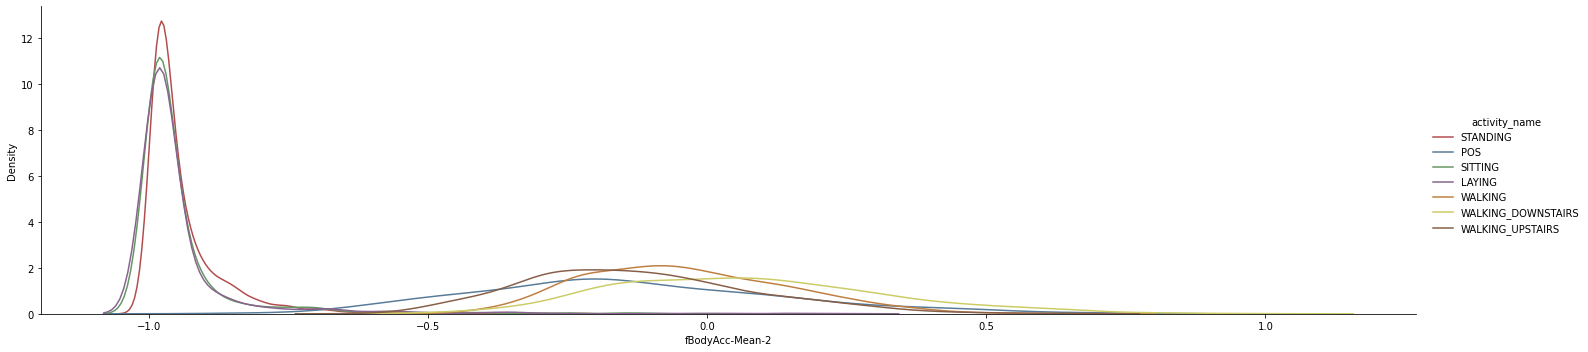

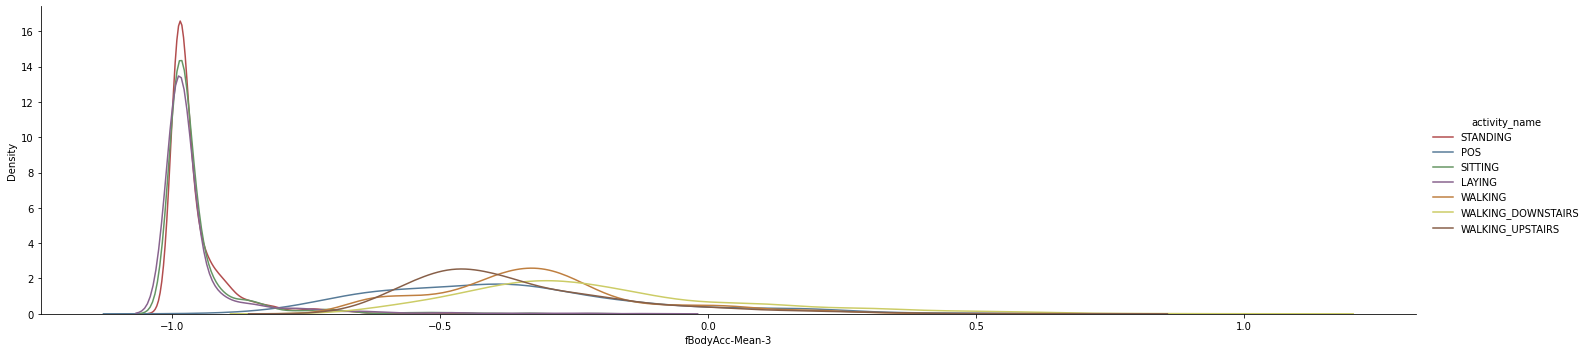

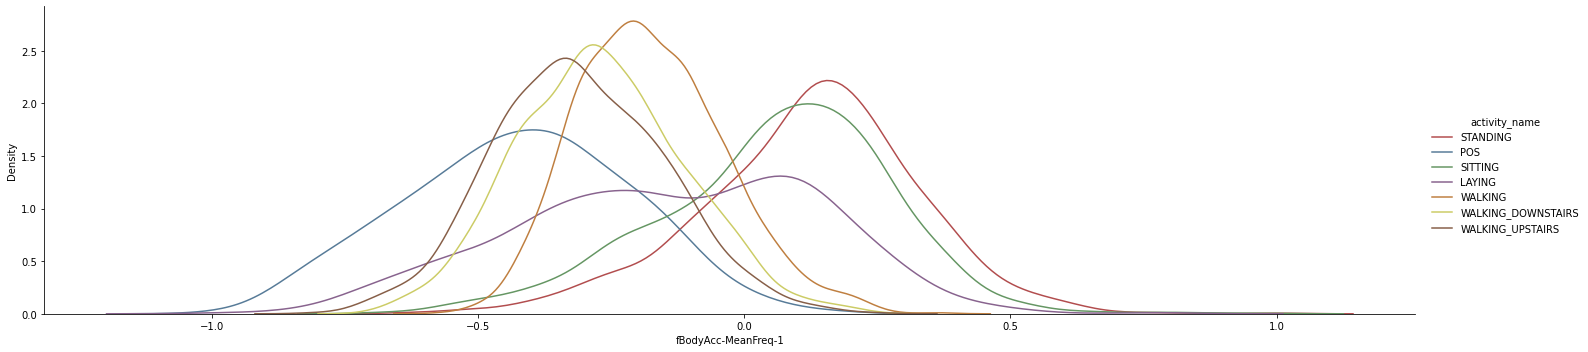

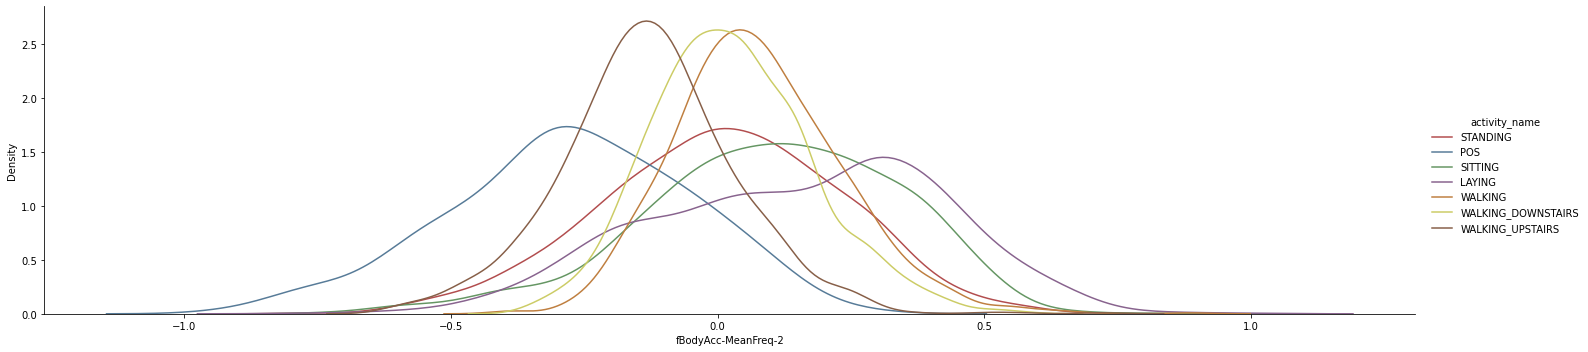

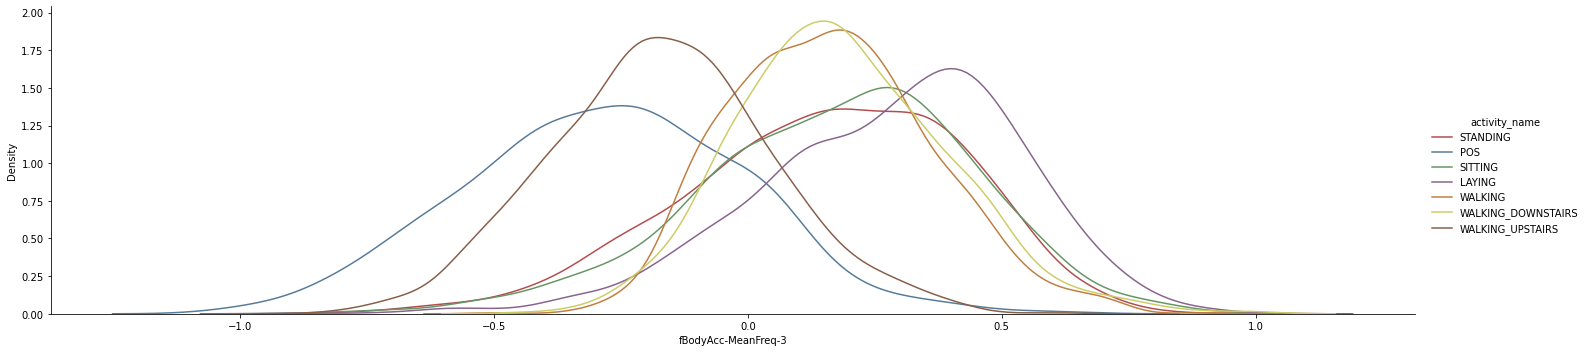

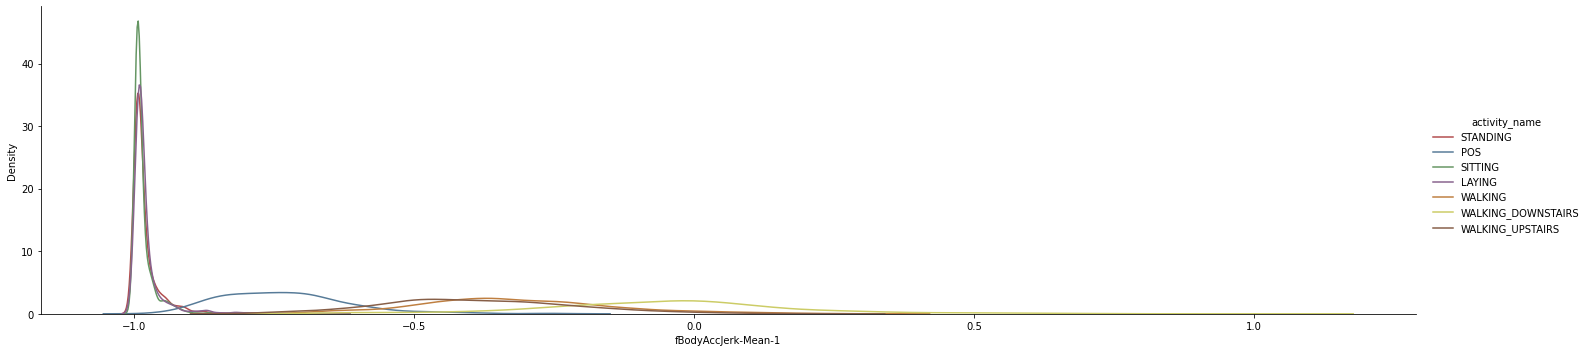

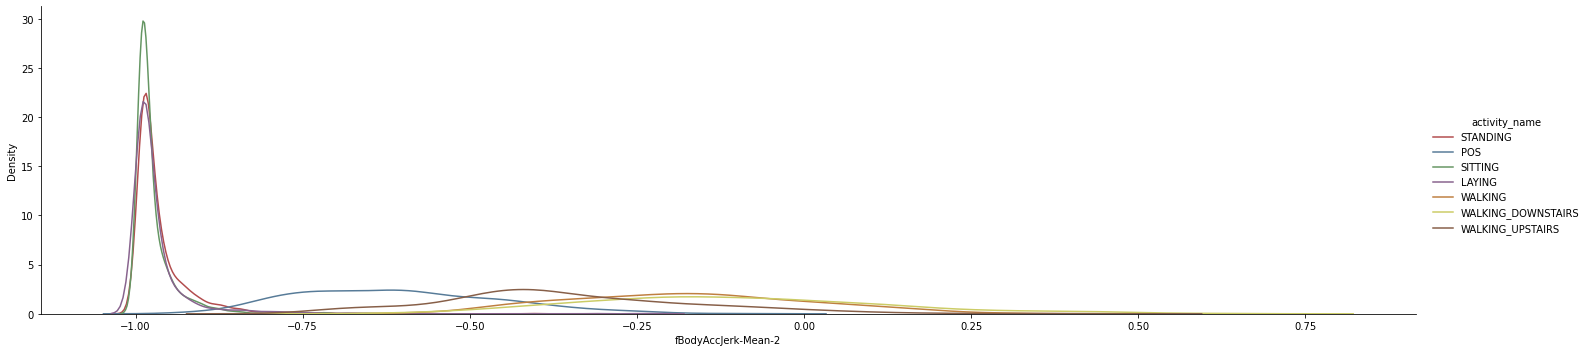

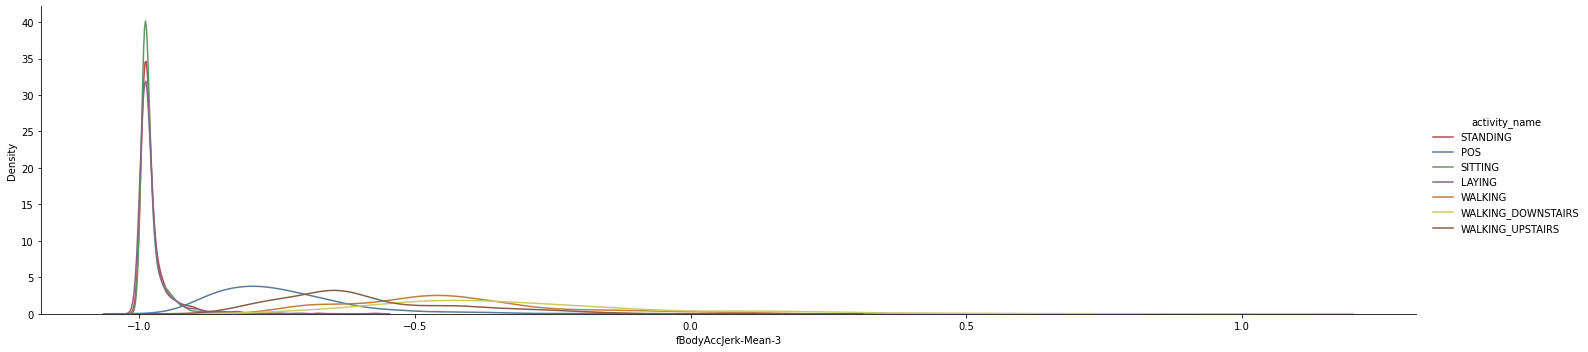

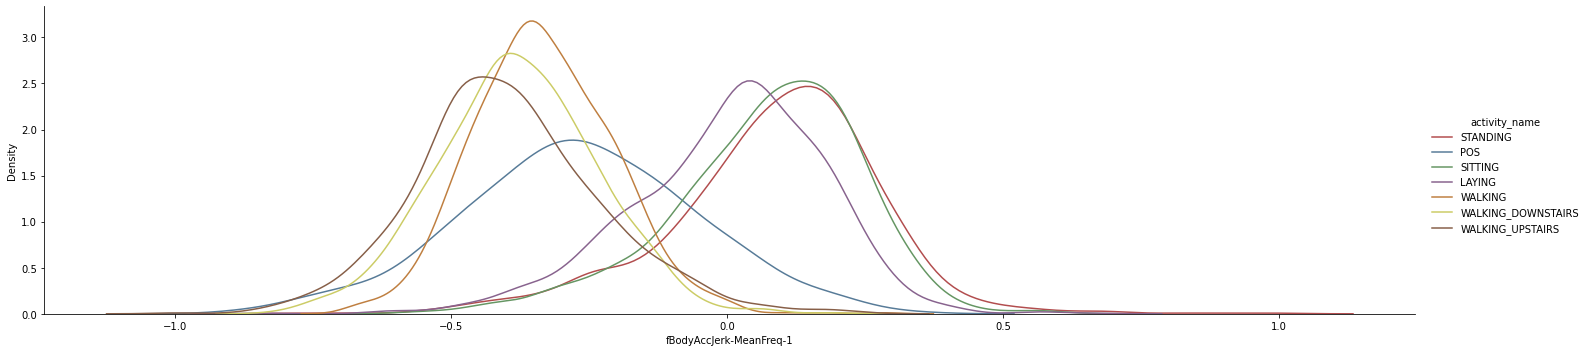

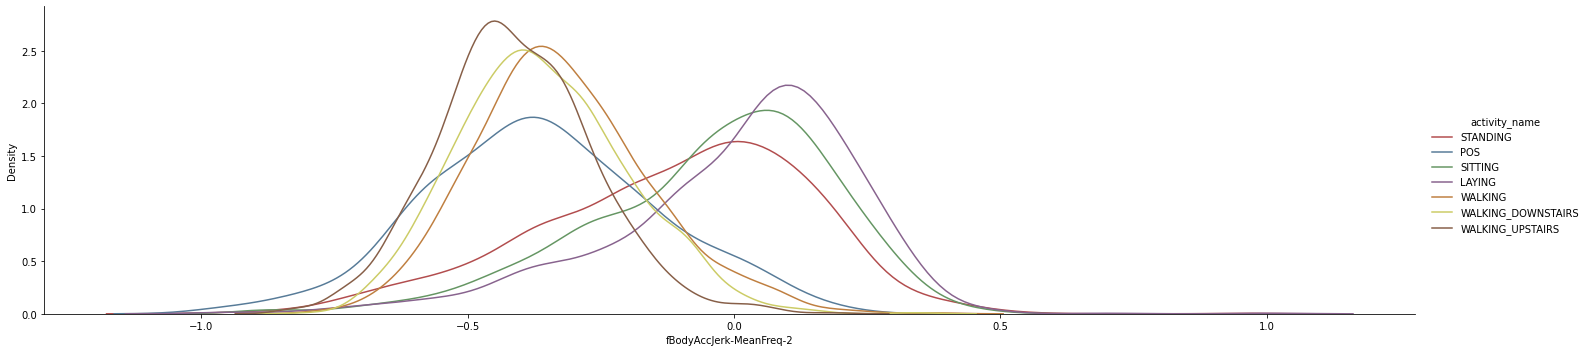

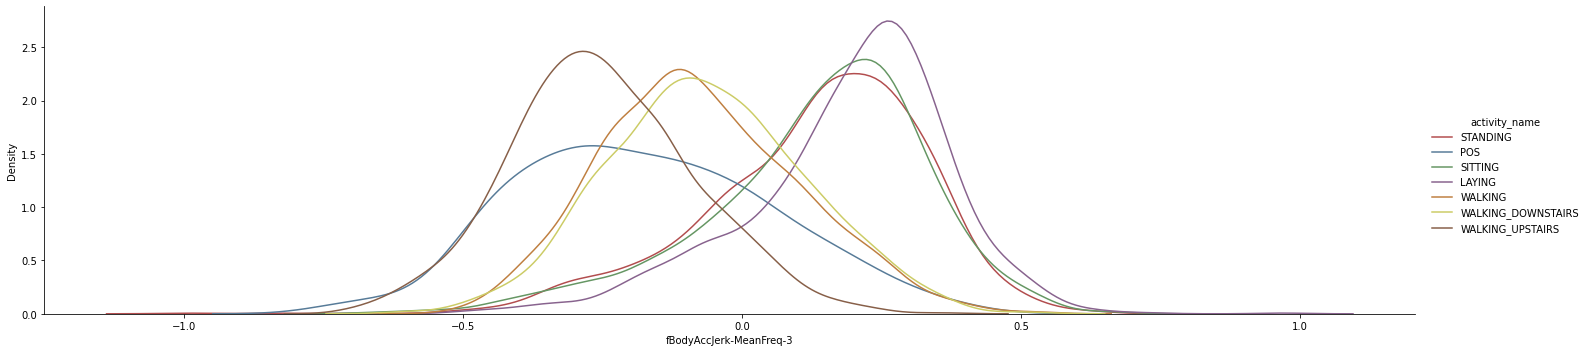

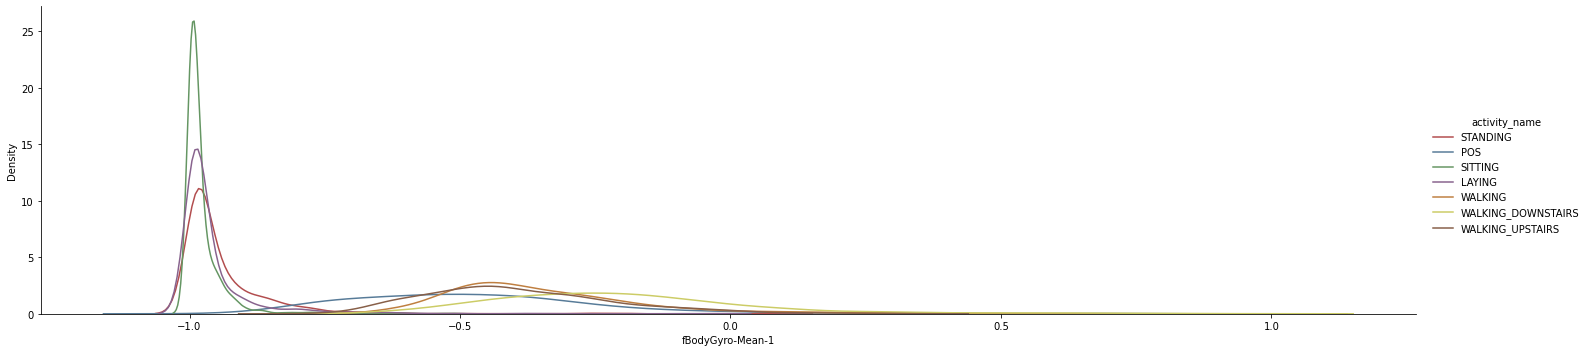

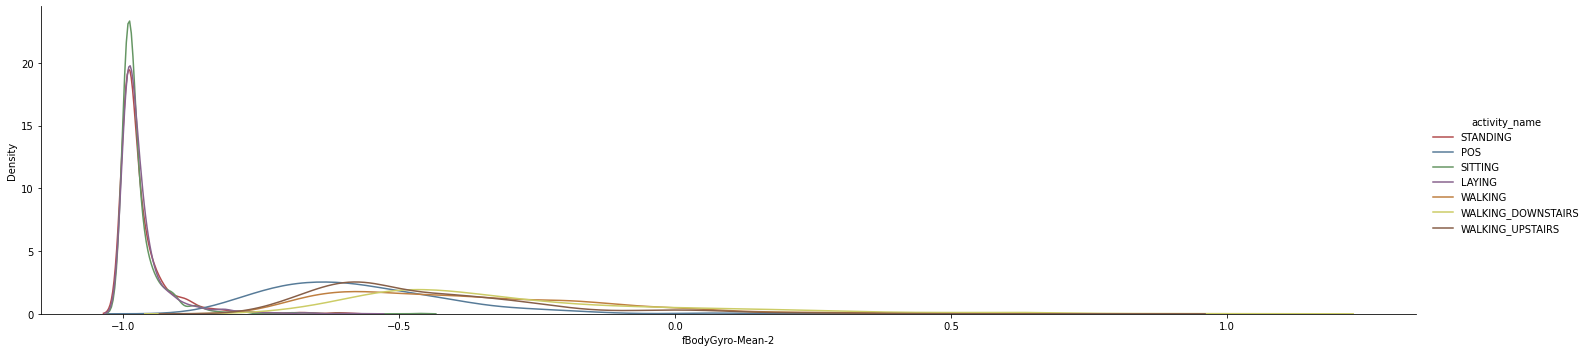

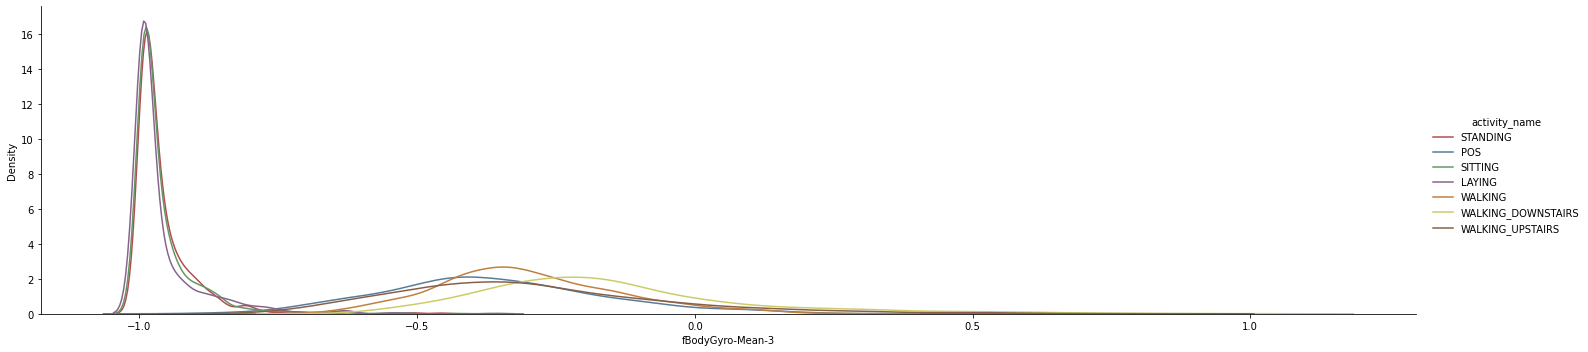

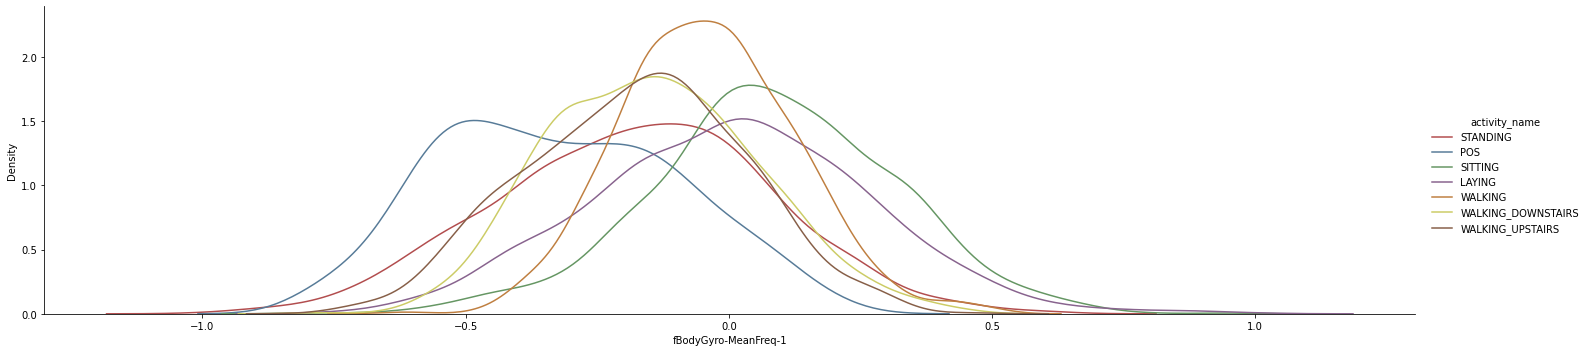

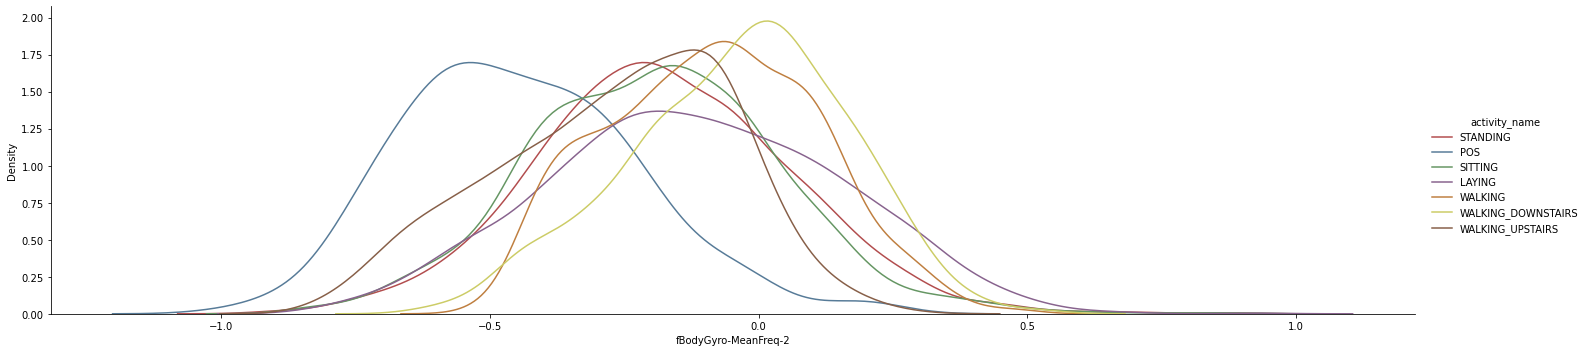

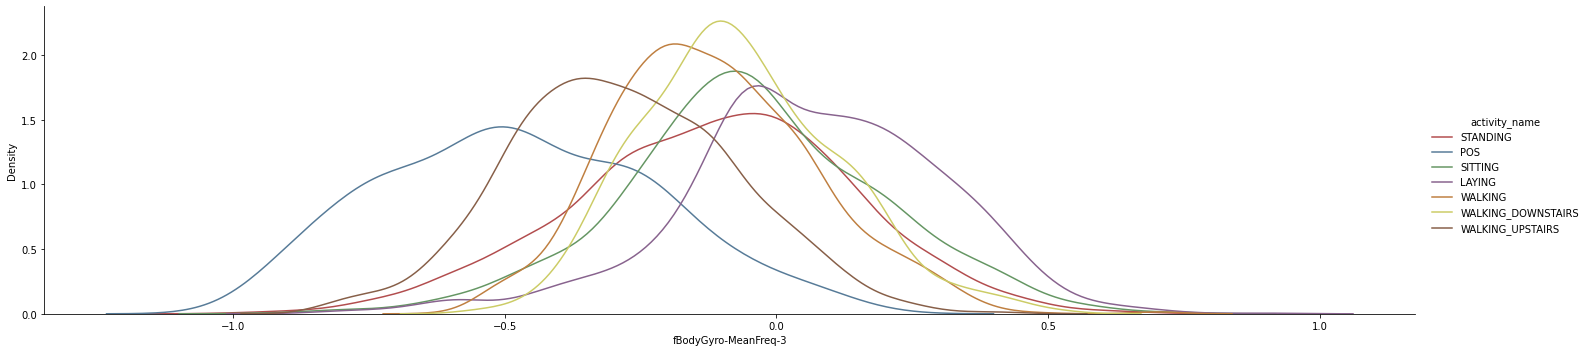

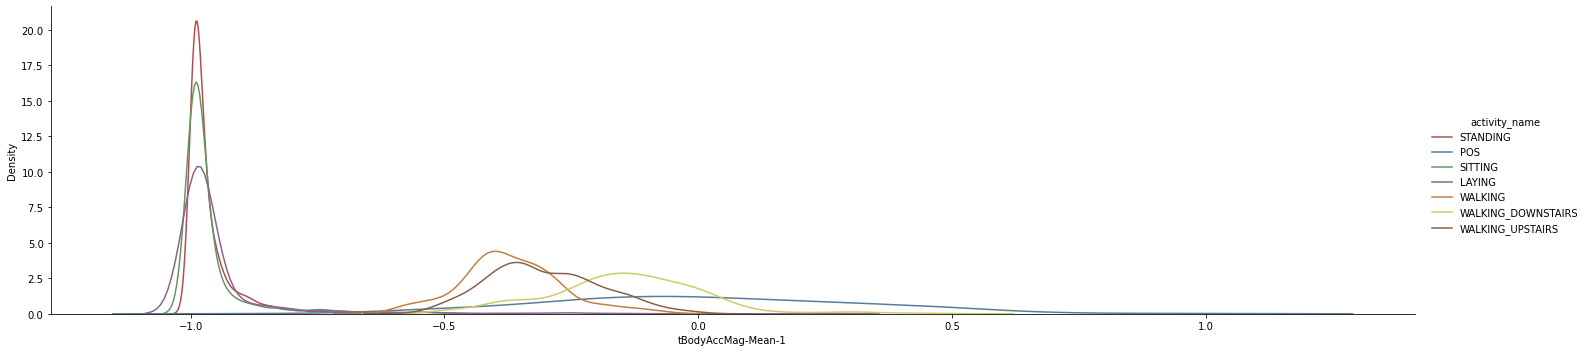

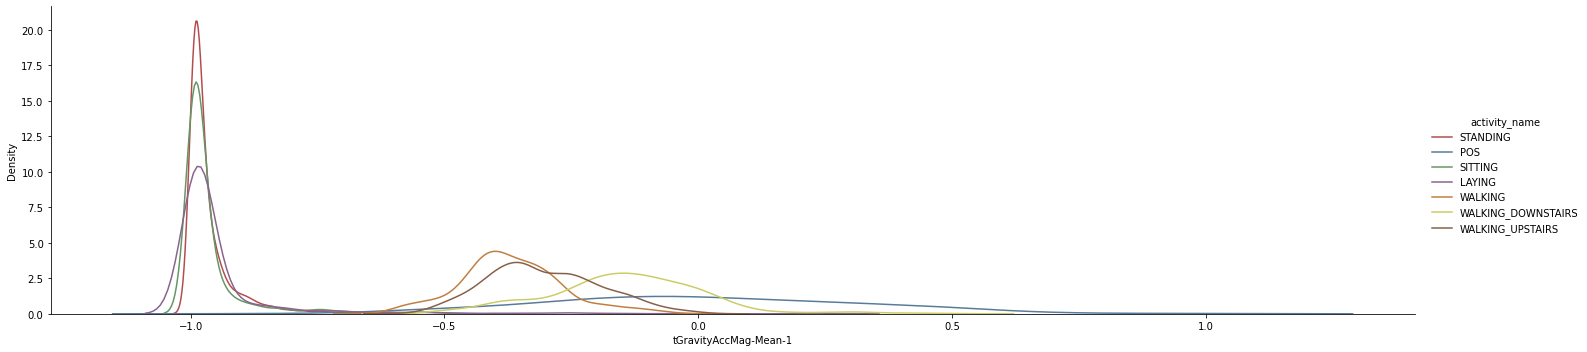

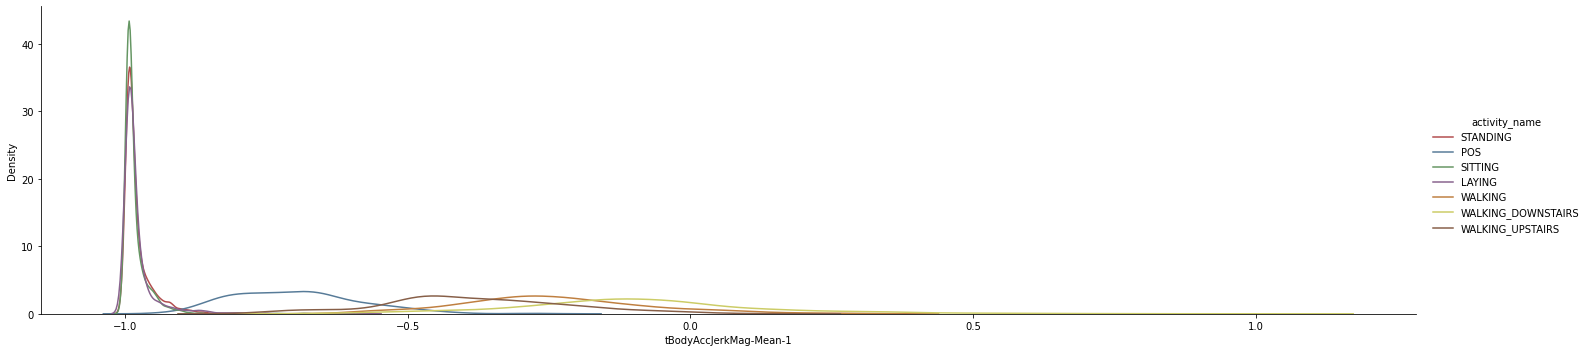

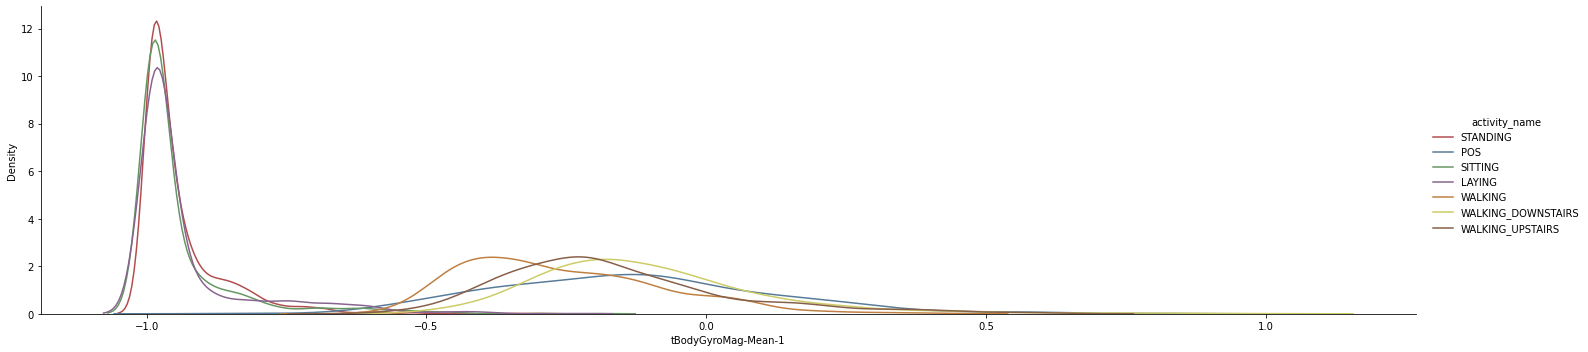

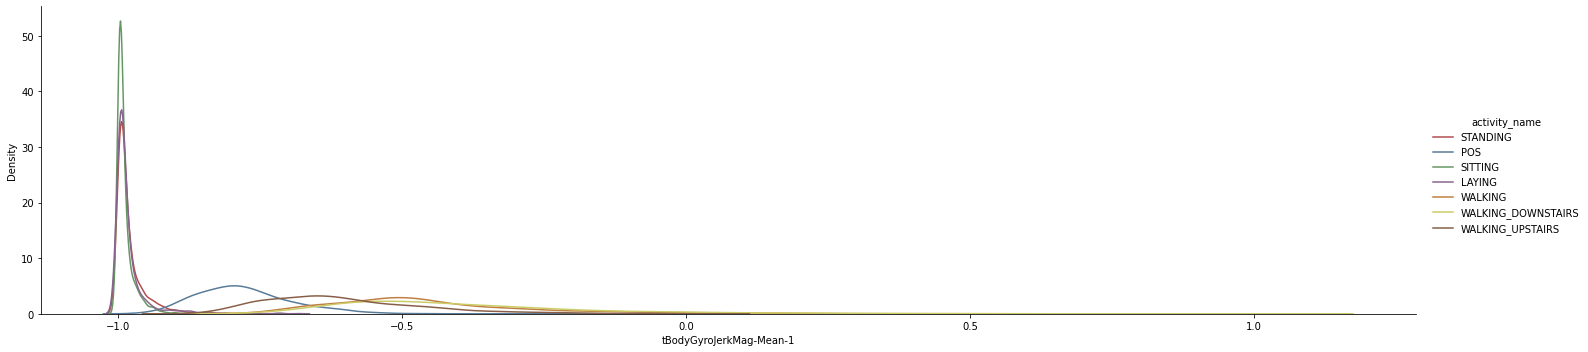

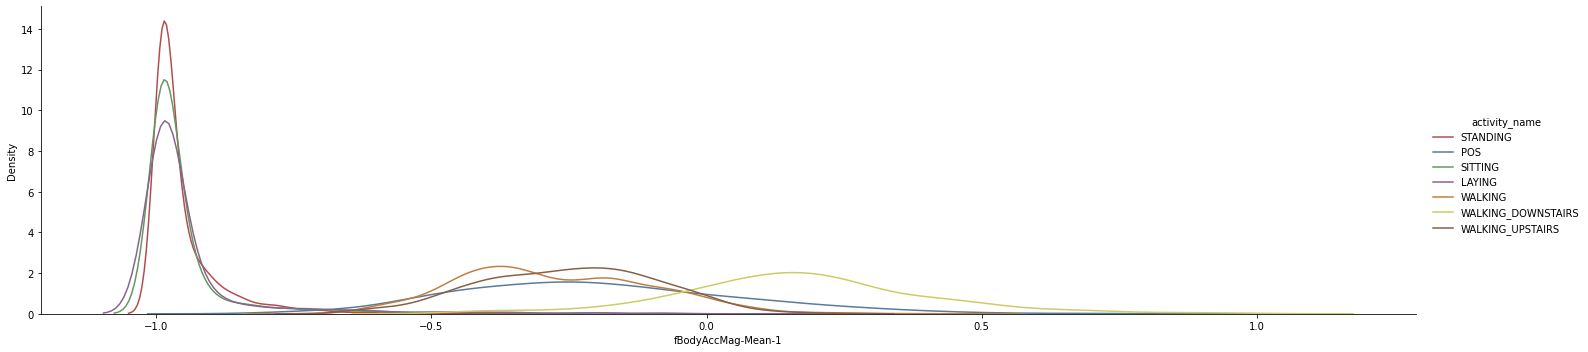

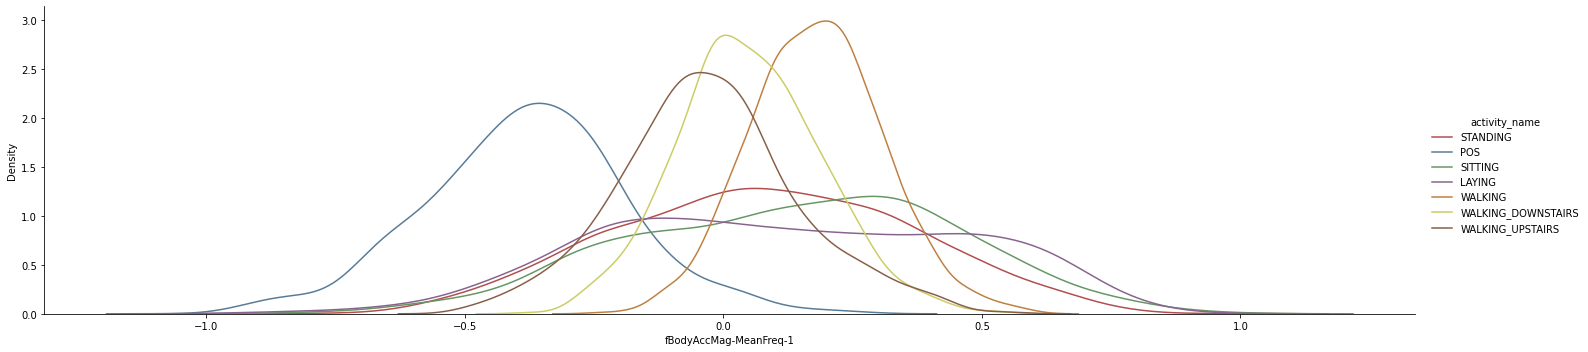

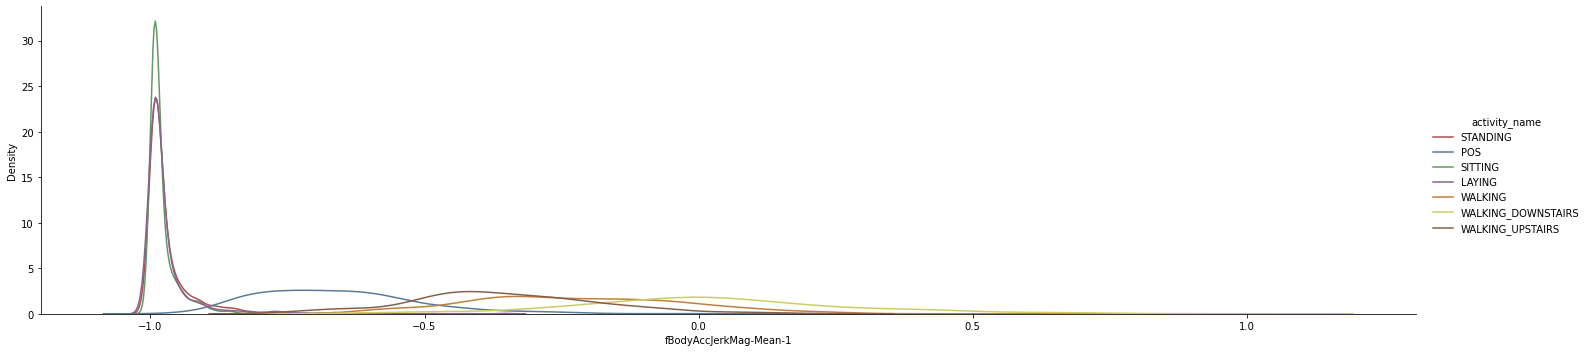

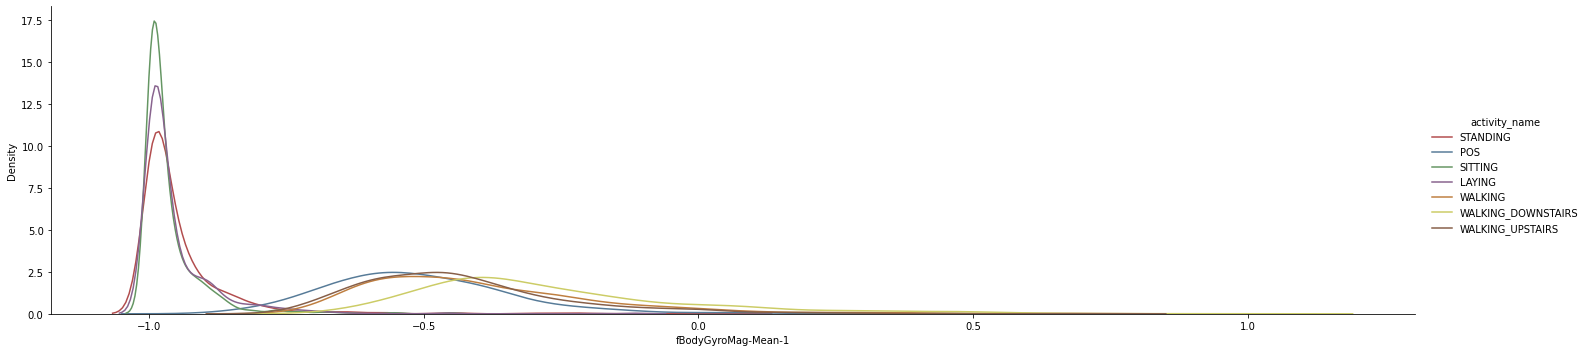

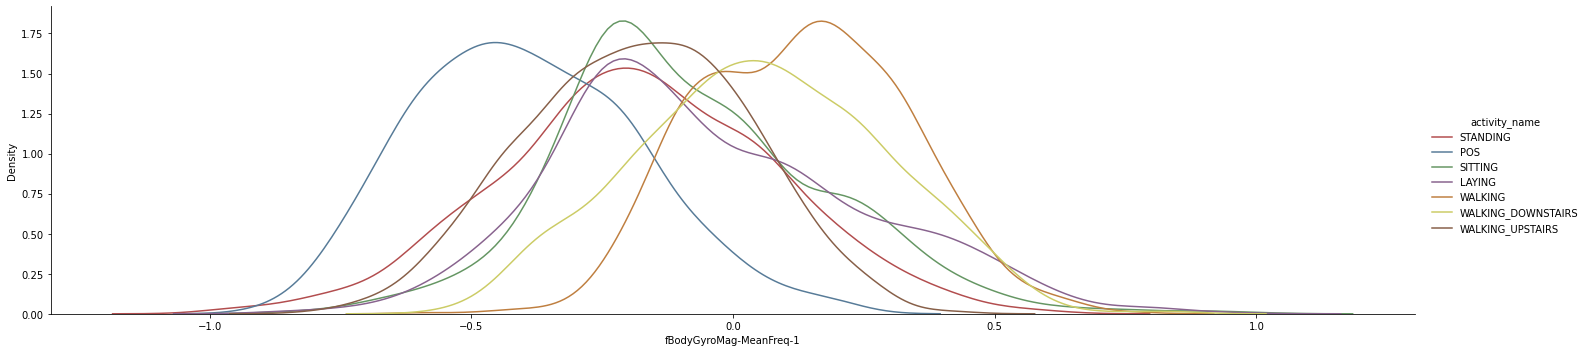

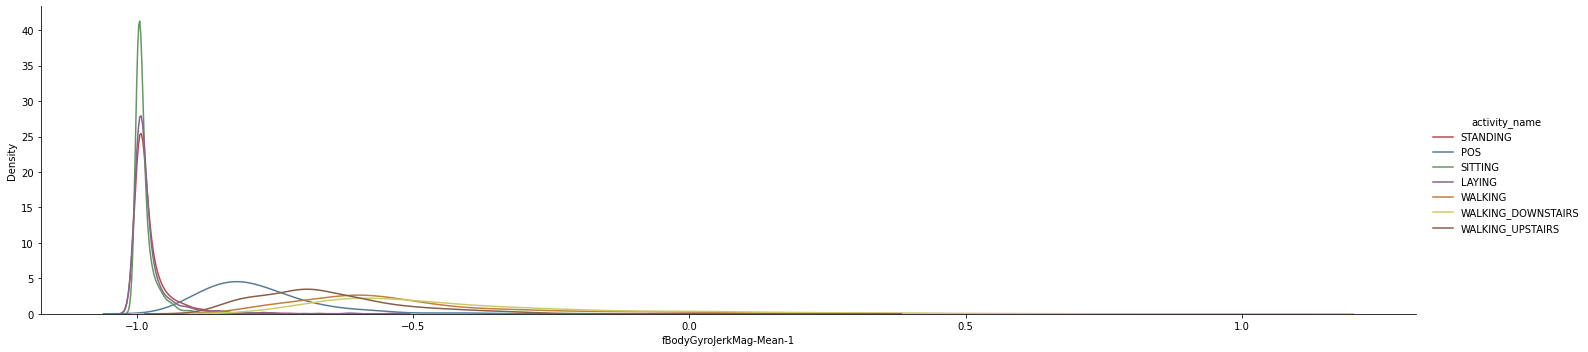

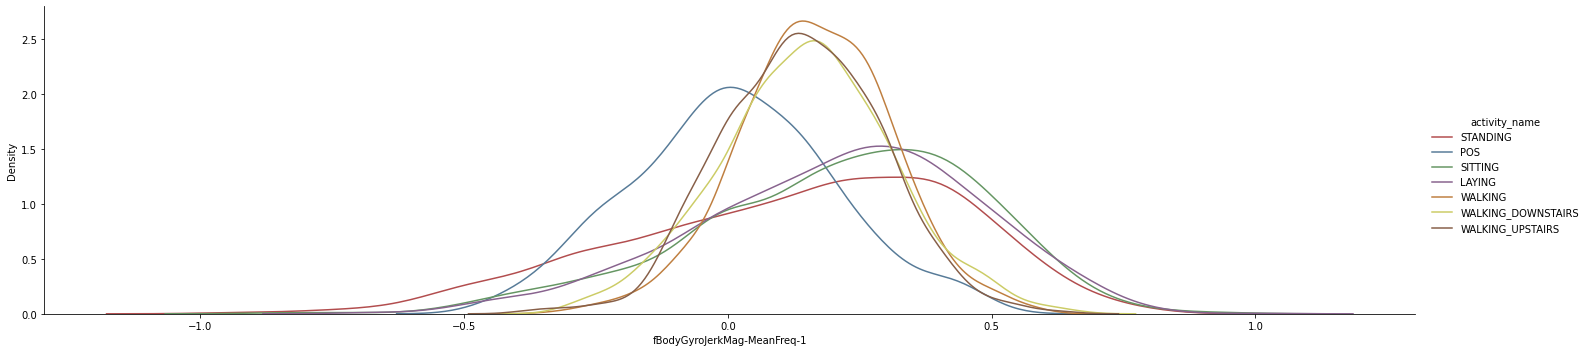

In [ ]:
# Plot the signal of selected variables using sns.FacetGrid.
columns =[
    'tBodyAcc-Mean-1','tBodyAcc-Mean-2','tBodyAcc-Mean-3', 'tBodyGyro-Mean-1','tBodyGyro-Mean-2',
    'tBodyGyro-Mean-3','tBodyAccJerk-Mean-1','tBodyAccJerk-Mean-2','tBodyAccJerk-Mean-3', 'tGravityAcc-Mean-1', 
    'tGravityAcc-Mean-2', 'tGravityAcc-Mean-3', 'tBodyGyroJerk-Mean-1','tBodyGyroJerk-Mean-2','tBodyGyroJerk-Mean-3', 
    'fBodyAcc-Mean-1','fBodyAcc-Mean-2','fBodyAcc-Mean-3', 'fBodyAcc-MeanFreq-1','fBodyAcc-MeanFreq-2',
    'fBodyAcc-MeanFreq-3','fBodyAccJerk-Mean-1','fBodyAccJerk-Mean-2','fBodyAccJerk-Mean-3', 'fBodyAccJerk-MeanFreq-1',
    'fBodyAccJerk-MeanFreq-2','fBodyAccJerk-MeanFreq-3','fBodyGyro-Mean-1','fBodyGyro-Mean-2','fBodyGyro-Mean-3',
    'fBodyGyro-MeanFreq-1','fBodyGyro-MeanFreq-2','fBodyGyro-MeanFreq-3', 'tBodyAccMag-Mean-1', 'tGravityAccMag-Mean-1', 
    'tBodyAccJerkMag-Mean-1', 'tBodyGyroMag-Mean-1', 'tBodyGyroJerkMag-Mean-1', 'fBodyAccMag-Mean-1',  'fBodyAccMag-MeanFreq-1', 
    'fBodyAccJerkMag-Mean-1',  'fBodyGyroMag-Mean-1','fBodyGyroMag-MeanFreq-1', 'fBodyGyroJerkMag-Mean-1', 'fBodyGyroJerkMag-MeanFreq-1'] 

for column in columns:
  _plot_facetgrid(
      df =X_train_df1,
      hue='activity_name',  #the categorical variable we want to group by
      column_name = column, #variable(s) we want to plot
      palette="Set1",
      desat=0.50,
      size=5,
      aspect=4,
      hist=False)

After analyzing the density plots of the training dataset, it was observed that the distribution of data points for stationary and moving activities differed significantly. This difference can be leveraged to differentiate between static (stationary) and dynamic (moving) activities in a classification task.

In [ ]:
columns =['fBodyAcc-Mean-1','fBodyAcc-Mean-2','fBodyAcc-Mean-3','fBodyGyro-Mean-1','fBodyGyro-Mean-2',
'fBodyGyro-Mean-3','tBodyAccMag-Mean-1', 'tGravityAccMag-Mean-1','tBodyAccJerkMag-Mean-1', 'tBodyGyroMag-Mean-1', 
'tBodyGyroJerkMag-Mean-1', 'fBodyAccMag-Mean-1', 'fBodyAccJerkMag-Mean-1',  'fBodyGyroMag-Mean-1','fBodyGyroJerkMag-Mean-1']

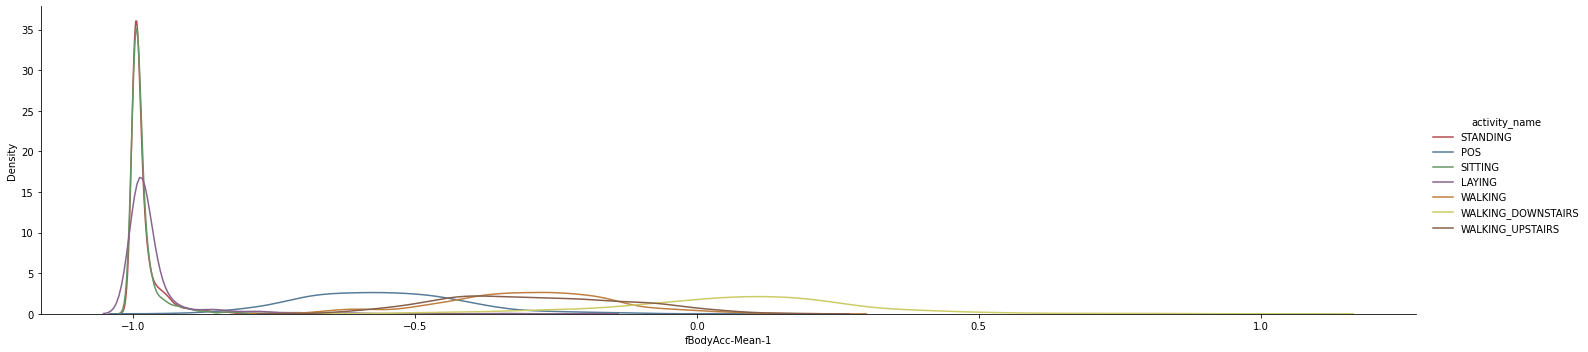

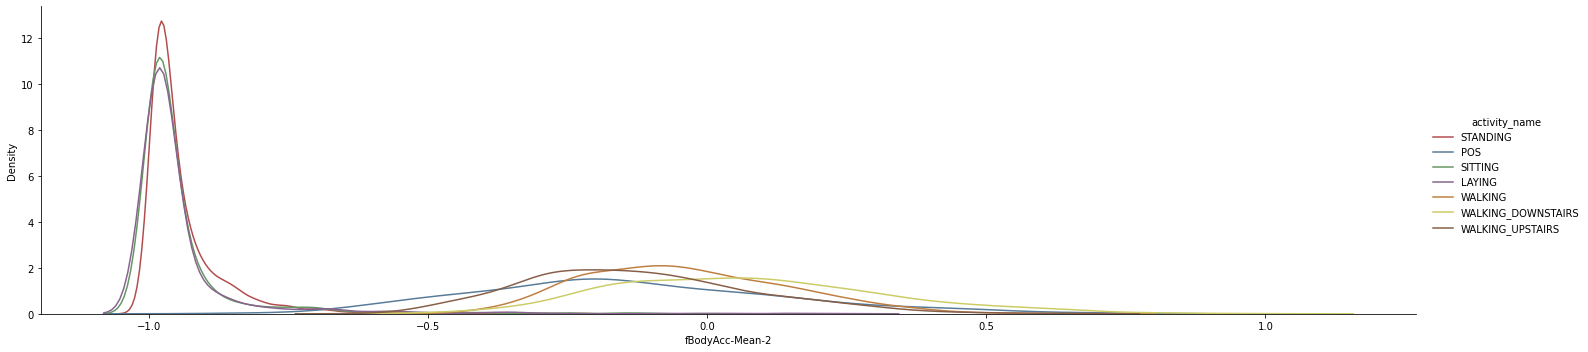

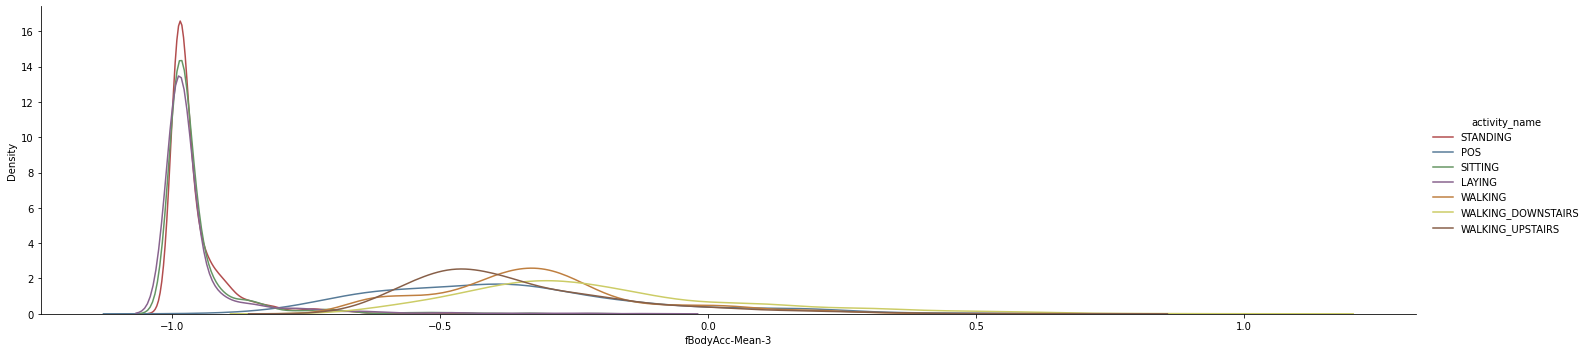

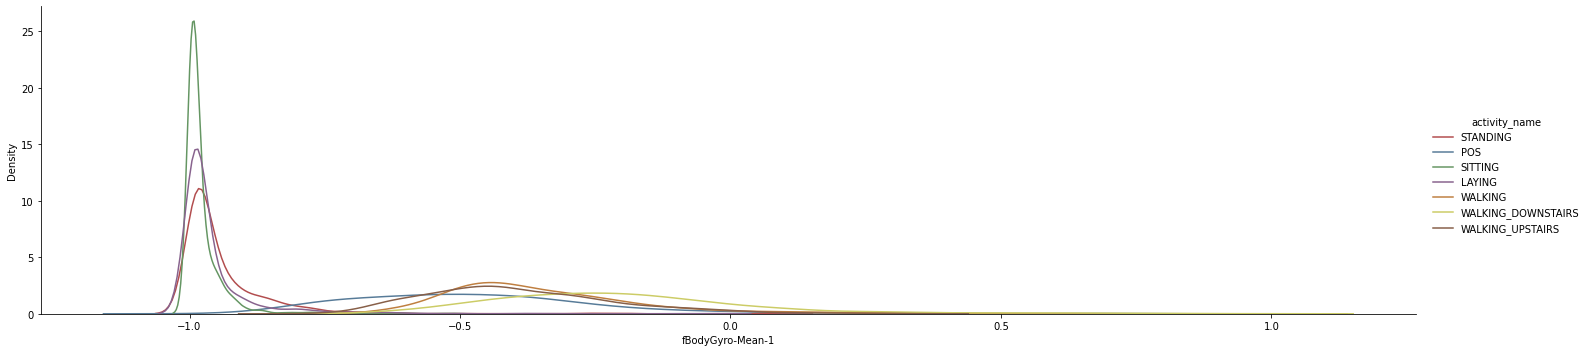

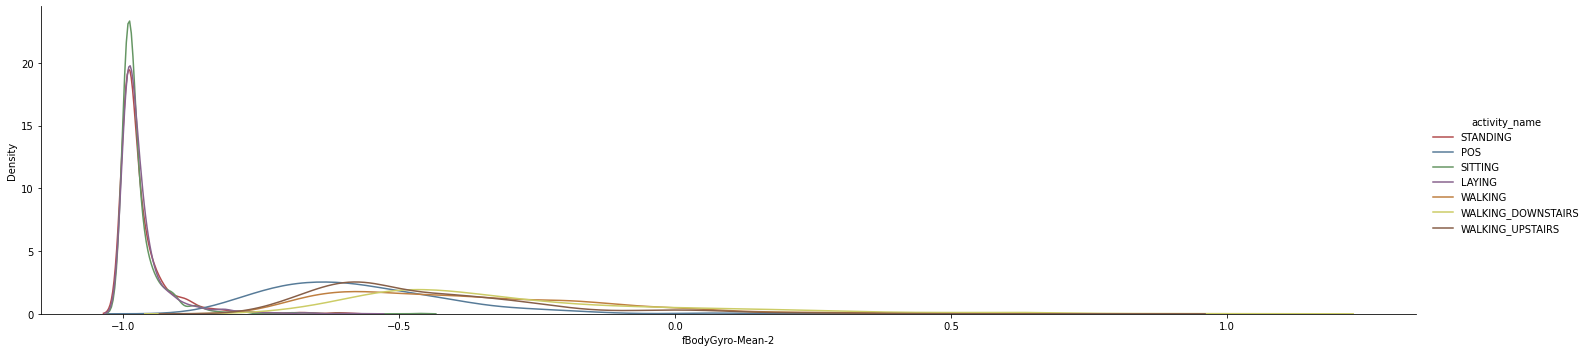

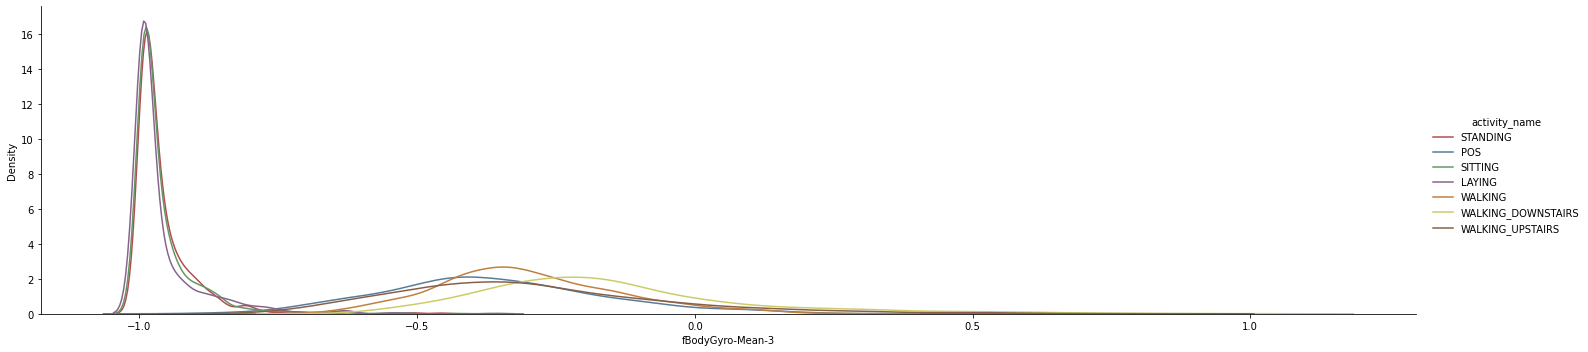

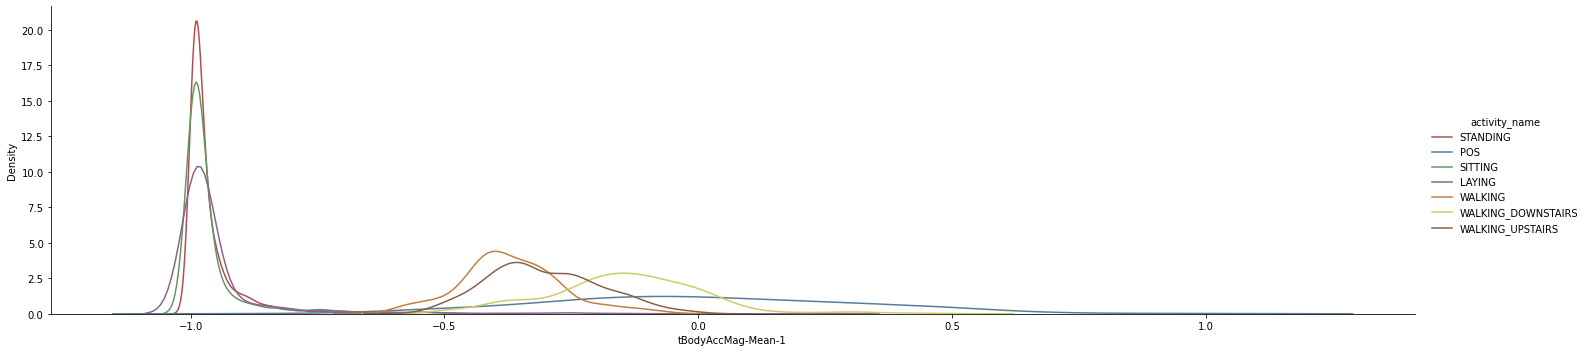

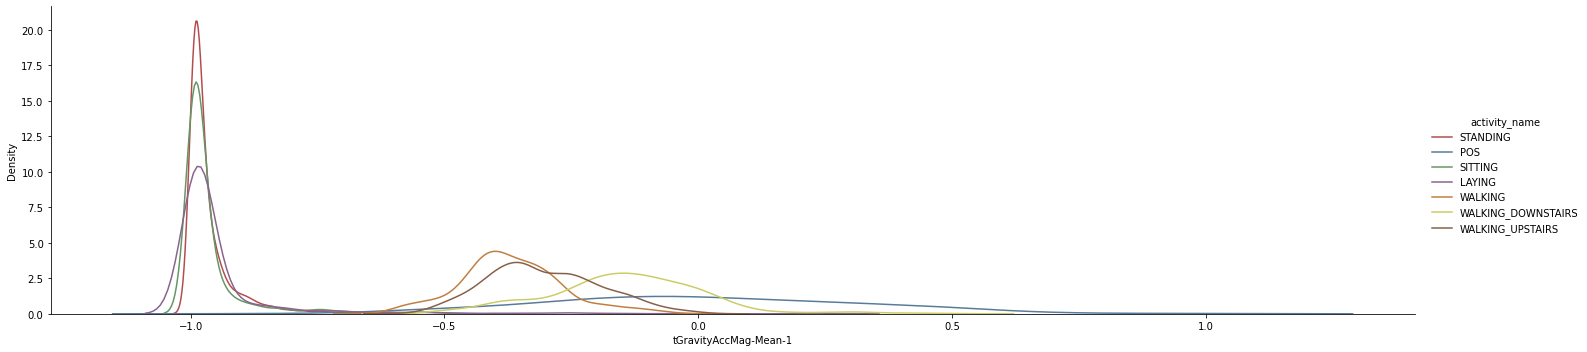

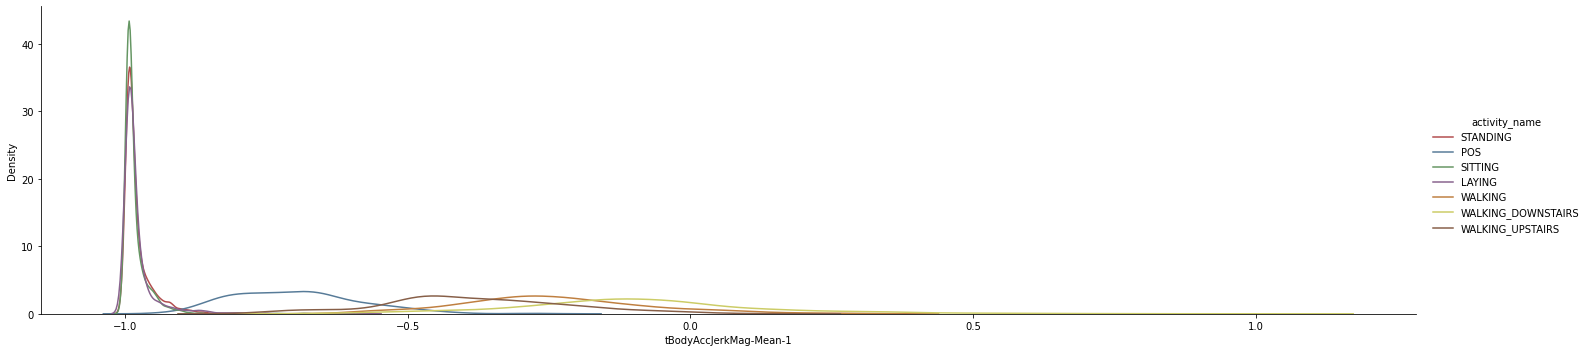

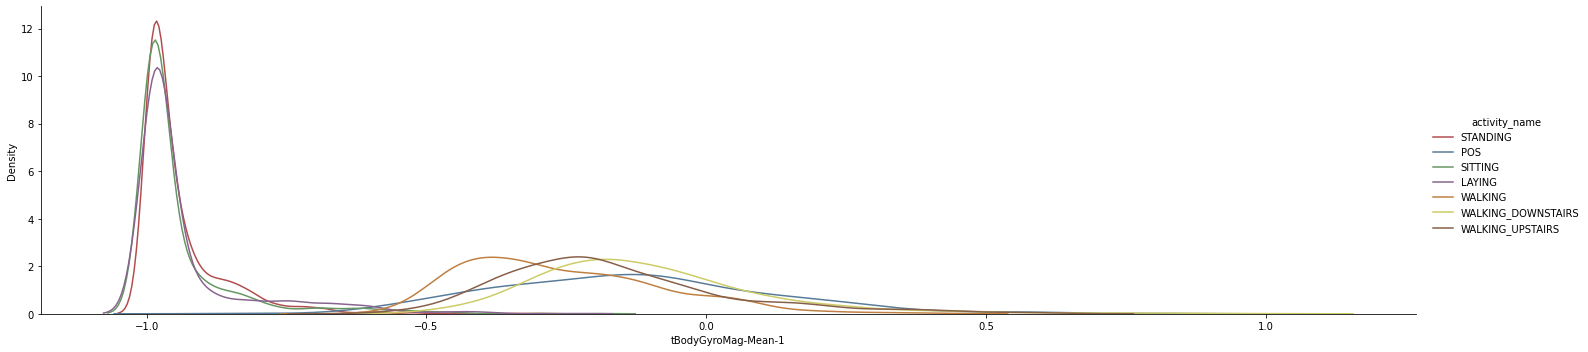

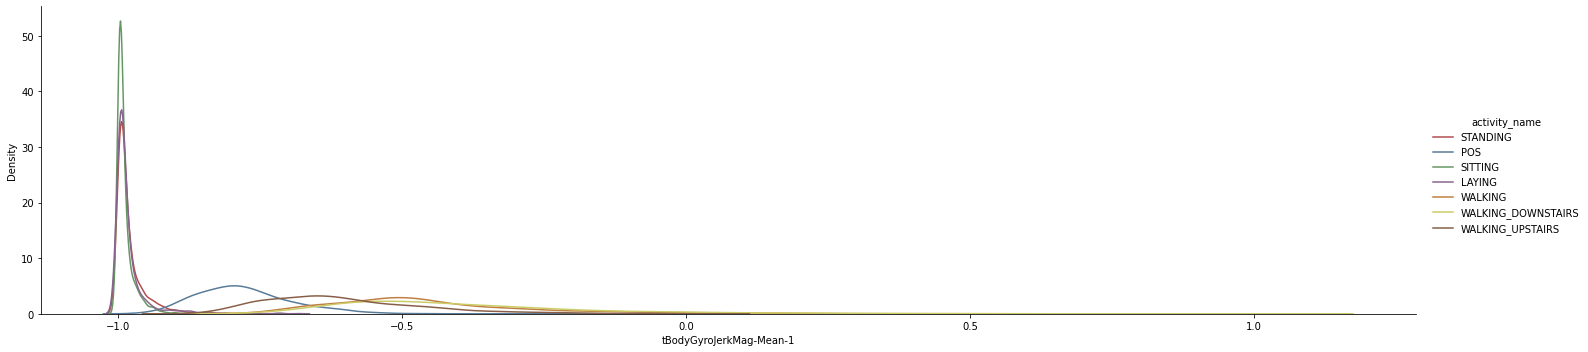

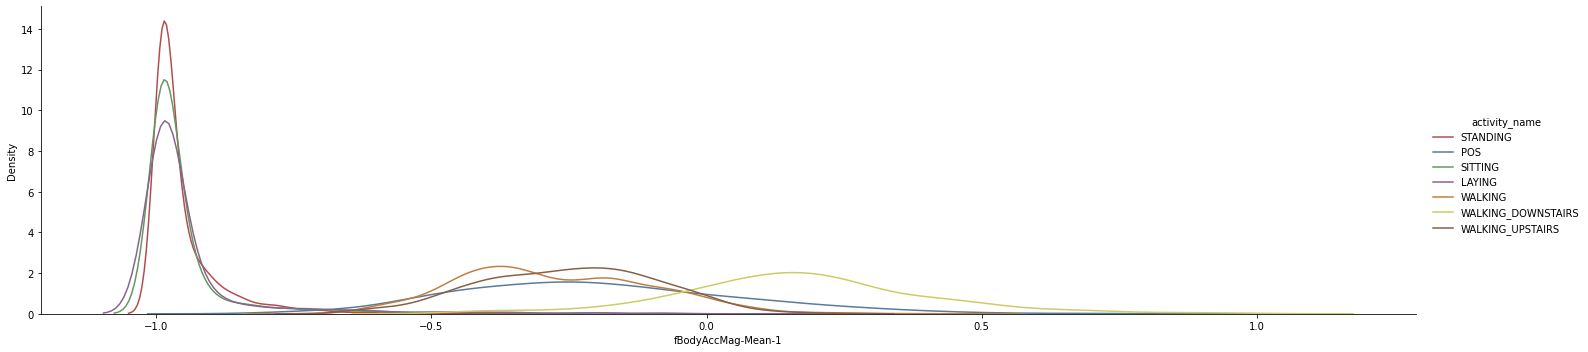

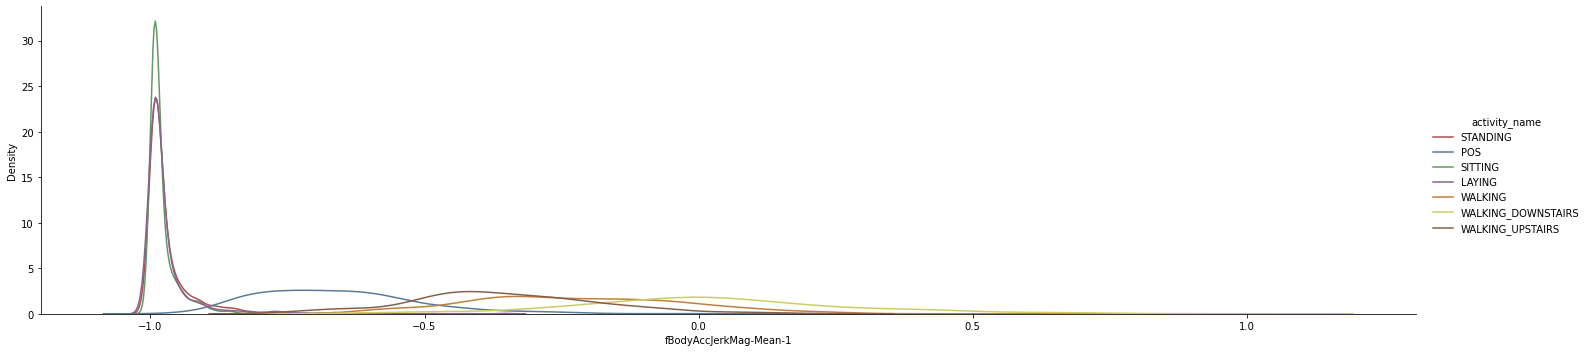

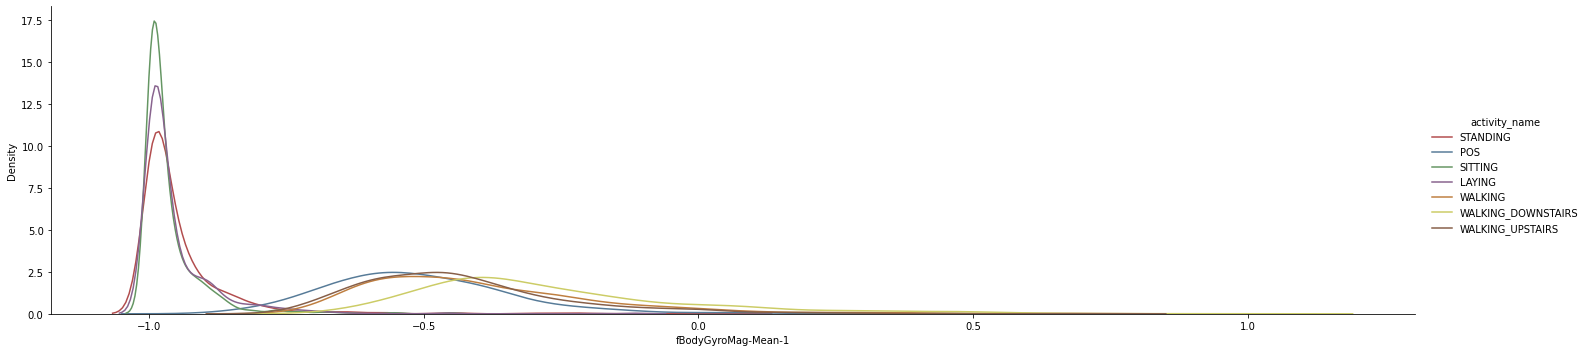

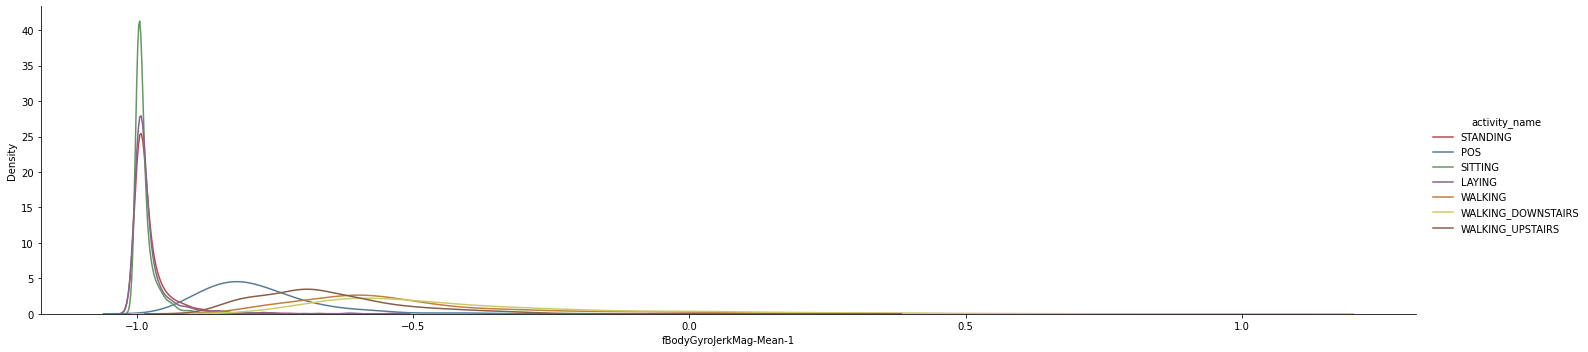

In [ ]:
for column in columns:
  _plot_facetgrid(
      df =X_train_df1,
      hue='activity_name',
      column_name = column,
      palette="Set1",
      desat=0.50,
      size=5,
      aspect=4,
      hist=False)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7767 samples in 0.003s...
[t-SNE] Computed neighbors for 7767 samples in 1.752s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7767
[t-SNE] Computed conditional probabilities for sample 2000 / 7767
[t-SNE] Computed conditional probabilities for sample 3000 / 7767
[t-SNE] Computed conditional probabilities for sample 4000 / 7767
[t-SNE] Computed conditional probabilities for sample 5000 / 7767
[t-SNE] Computed conditional probabilities for sample 6000 / 7767
[t-SNE] Computed conditional probabilities for sample 7000 / 7767
[t-SNE] Computed conditional probabilities for sample 7767 / 7767
[t-SNE] Mean sigma: 1.423747
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.228729
[t-SNE] KL divergence after 2000 iterations: 1.257444


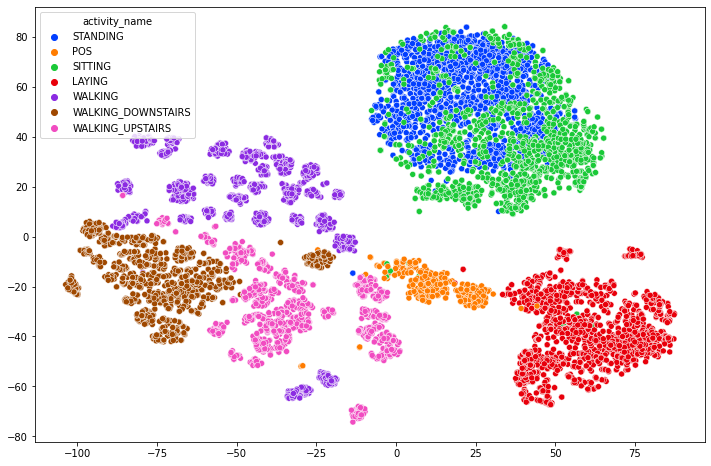

In [ ]:
 tsne_ptl(df = X_train_df1,drop_columns =['user_id','activity_id','activity_name'],hue="activity_name")

## Building an RNN Model for Activity Type Prediction with Seven Classe

<font color='red'>To avoid running into memory issues during training, I decided to use only 15 columns from the dataset. Despite using Colab Pro with High-RAM, I encountered crashes due to memory limitations. I selected the columns that provide a strong signal for distinguishing between the different activity types.</font>

In [ ]:
x_cols = ['fBodyAcc-Mean-1','fBodyAcc-Mean-2','fBodyAcc-Mean-3','fBodyGyro-Mean-1','fBodyGyro-Mean-2',
'fBodyGyro-Mean-3','tBodyAccMag-Mean-1', 'tGravityAccMag-Mean-1','tBodyAccJerkMag-Mean-1', 'tBodyGyroMag-Mean-1', 
'tBodyGyroJerkMag-Mean-1', 'fBodyAccMag-Mean-1', 'fBodyAccJerkMag-Mean-1',  'fBodyGyroMag-Mean-1','fBodyGyroJerkMag-Mean-1','activity_id']
y_col='activity_id'

In [ ]:
X_RNNl7_train = X_train_df1[x_cols].copy()
X_RNNl7test = X_test_df1[x_cols].copy()

In [ ]:
print('X_RNNl7_train shape:',X_RNNl7_train.shape)
print('X_RNNl7test shape:',X_RNNl7test.shape)

X_RNNl7_train shape: (7767, 16)
X_RNNl7test shape: (3162, 16)


In [ ]:
input_seq = []
target_seq  = []

# determines how many time steps the model will look back to make a prediction
seq_length =150  #3 seconds (150 time steps at 50Hz)

# determines how many time steps into the future the model will try to predict
ph = 1

In [ ]:
#create list of sequence length seniors readings
for start in range(1,len(X_RNNl7_train)-seq_length-ph):
  input_seq.append(X_RNNl7_train[x_cols].iloc[start:start+seq_length].to_numpy())

In [ ]:
#create list of sequence length seniors readings
for start in range(1,len(X_RNNl7_train)-seq_length-ph):
  target_seq .append(X_RNNl7_train[y_col].iloc[start+seq_length+ph])

In [ ]:
input_seq = np.array(input_seq, dtype = object).astype(np.float32)
target_seq = np.array(target_seq, dtype = object).astype(np.int32)

In [ ]:
print('input_seq shape',input_seq.shape)
print('target_seq shape',target_seq.shape)

input_seq shape (7615, 150, 16)
target_seq shape (7615,)


In [ ]:
unique_activities = np.unique(target_seq)
print(unique_activities)

[1 2 3 4 5 6 7]


In [ ]:
# This should convert target_seq to a binary matrix representation, 
# where each row represents a sample and each column represents a class, 
# and the value in each column is 1 if that sample belongs to that class, and 0 otherwise.
target_seq = to_categorical(target_seq)

In [ ]:
print('target_seq shape',target_seq.shape)

target_seq shape (7615, 8)


In [ ]:
# determines how many time steps the model will look back to make a prediction
seq_length =150  #3 seconds (150 time steps at 50Hz)

# determines how many time steps into the future the model will try to predict
ph = 1

# define path to save model
model_path = 'RNN_model.h5'

# specify the evaluation metric(s) to be used during training and testing of the model
metrics = [
    'accuracy', #The proportion of correctly classified samples.
    'categorical_accuracy', #The proportion of correctly classified samples for multi-class classification problems.
    ]

#I think categorical_crossentropy is a good choice for a classification problem 
#with three classes where the target labels are integers (0, 1, or 2).
loss= 'categorical_crossentropy'

# The learning rate is a hyperparameter that controls how much the weights of the neural network are updated during training. 
# It determines the step size at each iteration while moving toward a minimum of a loss function. 
# a small learning rate is often a good starting point
learning_rate = 0.002

#number of features included in the training data
nb_features = len(x_cols) 

#output length
nb_out = 8

# build the network
model = Sequential()

#add first(input) RNN layer
model.add(
    SimpleRNN(
      input_shape=(seq_length, nb_features), #shape of input layer
      units=128, #number of hidden units
      return_sequences=True
    )
)

#dropout for regularization
model.add(Dropout(0.2)) 

# add second RNN layer
model.add(SimpleRNN(units=64,return_sequences=True ))

#dropout for regularization
model.add(Dropout(0.2))

# add second RNN layer
model.add(SimpleRNN(units=16,return_sequences=False ))

#dropout for regularization
model.add(Dropout(0.2))

# Add the output layer with the appropriate number of units and activation function
model.add(Dense(units=nb_out,activation='softmax'))

optimizer = keras.optimizers.Adam(learning_rate = learning_rate)

model.compile(loss=loss, optimizer=optimizer,metrics=metrics)

print(model.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_32 (SimpleRNN)   (None, 150, 128)          18560     
                                                                 
 dropout_31 (Dropout)        (None, 150, 128)          0         
                                                                 
 simple_rnn_33 (SimpleRNN)   (None, 150, 64)           12352     
                                                                 
 dropout_32 (Dropout)        (None, 150, 64)           0         
                                                                 
 simple_rnn_34 (SimpleRNN)   (None, 16)                1296      
                                                                 
 dropout_33 (Dropout)        (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 8)               

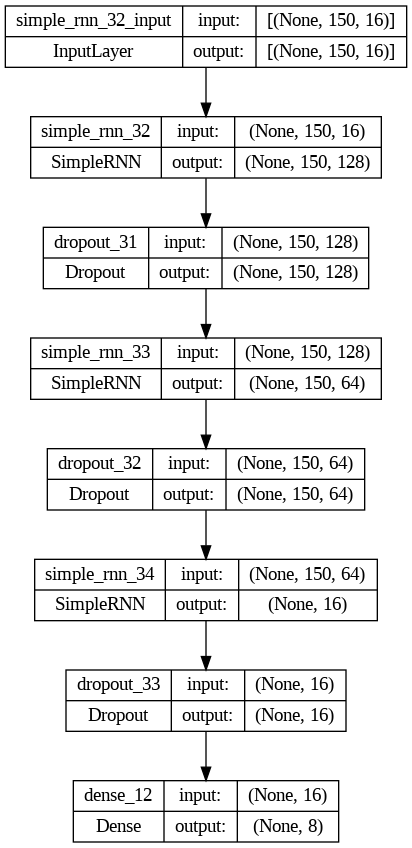

In [ ]:
# Plot the model graph
plot_model(model, show_shapes=True)

In [ ]:
# fit the network
history = model.fit(input_seq, target_seq, epochs=200, batch_size=500,validation_split=0.05, verbose=2)

Epoch 1/200
15/15 - 7s - loss: 1.4151 - accuracy: 0.4493 - categorical_accuracy: 0.4493 - val_loss: 0.5979 - val_accuracy: 1.0000 - val_categorical_accuracy: 1.0000 - 7s/epoch - 437ms/step
Epoch 2/200
15/15 - 5s - loss: 0.8141 - accuracy: 0.7703 - categorical_accuracy: 0.7703 - val_loss: 0.3103 - val_accuracy: 1.0000 - val_categorical_accuracy: 1.0000 - 5s/epoch - 301ms/step
Epoch 3/200
15/15 - 5s - loss: 0.4889 - accuracy: 0.9357 - categorical_accuracy: 0.9357 - val_loss: 0.2378 - val_accuracy: 1.0000 - val_categorical_accuracy: 1.0000 - 5s/epoch - 305ms/step
Epoch 4/200
15/15 - 4s - loss: 0.3726 - accuracy: 0.9512 - categorical_accuracy: 0.9512 - val_loss: 0.1954 - val_accuracy: 1.0000 - val_categorical_accuracy: 1.0000 - 4s/epoch - 297ms/step
Epoch 5/200
15/15 - 5s - loss: 0.5687 - accuracy: 0.8419 - categorical_accuracy: 0.8419 - val_loss: 0.2427 - val_accuracy: 1.0000 - val_categorical_accuracy: 1.0000 - 5s/epoch - 310ms/step
Epoch 6/200
15/15 - 5s - loss: 0.6758 - accuracy: 0.795

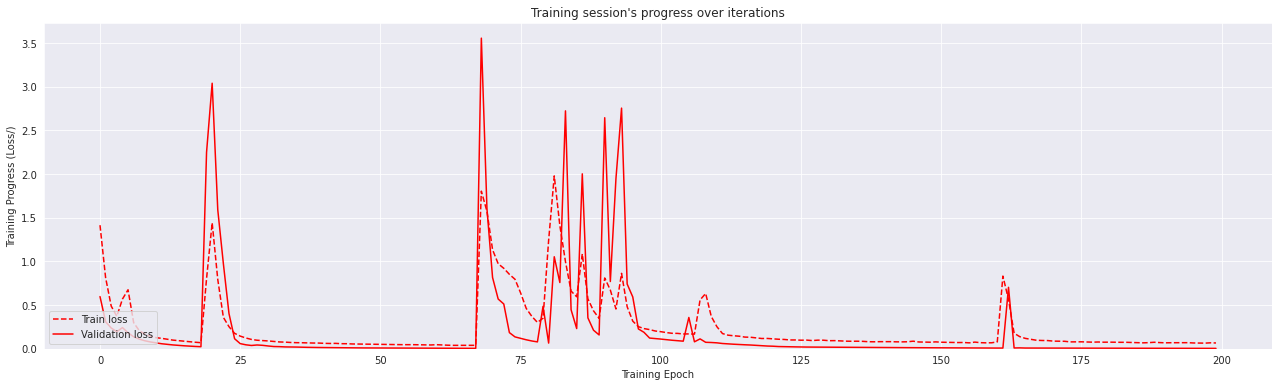

In [ ]:
plt.figure(figsize = (22,6))
plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/)')
plt.xlabel('Training Epoch')
plt.ylim(0) 
plt.show()

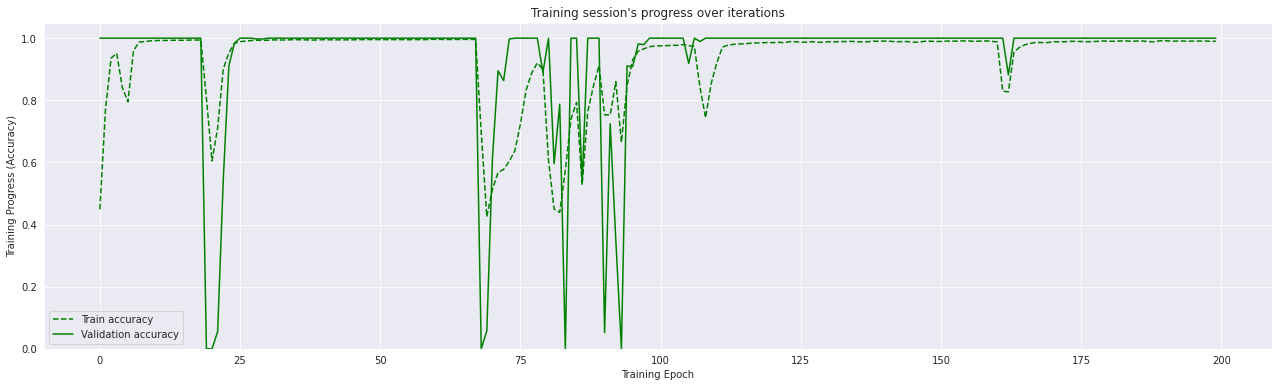

In [ ]:
plt.figure(figsize = (22,6))
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0) 
plt.show()

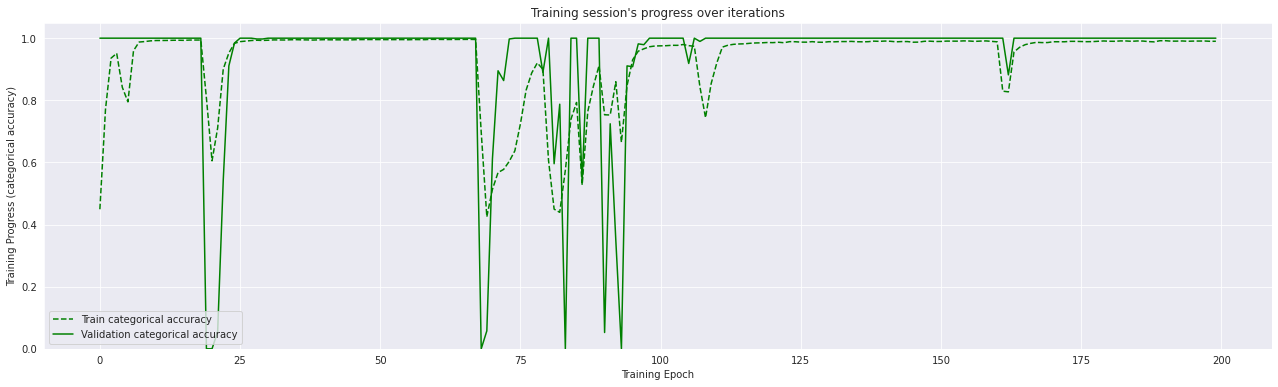

In [ ]:
plt.figure(figsize = (22,6))
plt.plot(np.array(history.history['categorical_accuracy']), "g--", label = "Train categorical accuracy")
plt.plot(np.array(history.history['val_categorical_accuracy']), "g-", label = "Validation categorical accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (categorical accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0) 
plt.show()

### Evaluate the model

In [ ]:
X_RNNl7test .shape

(3162, 16)

In [ ]:
test_input_seq = []
test_target_seq  = []

In [ ]:
#create list of sequence length seniors readings
for start in range(1,len(X_RNNl7test)-seq_length-ph):
  test_input_seq.append(X_RNNl7test[x_cols].iloc[start:start+seq_length].to_numpy())

#create list of sequence length seniors readings
for start in range(1,len(X_RNNl7test)-seq_length-ph):
  test_target_seq .append(X_RNNl7test[y_col].iloc[start+seq_length+ph])

test_input_seq = np.array(test_input_seq, dtype = object).astype(np.float32)
test_target_seq = np.array(test_target_seq, dtype = object).astype(np.int32)

test_target_seq = to_categorical(test_target_seq)

print('test_input_seq shape',test_input_seq.shape)
print('test_target_seq shape',test_target_seq.shape)

test_input_seq shape (3010, 150, 16)
test_target_seq shape (3010, 8)


In [ ]:
scores_test = model.evaluate(test_input_seq, test_target_seq, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

95/95 - 3s - loss: 0.0671 - accuracy: 0.9914 - categorical_accuracy: 0.9914 - 3s/epoch - 32ms/step

MSE: 0.9913621544837952


In [ ]:
y_pred_test = model.predict(test_input_seq)
y_true_test = test_target_seq

95/95 [==============================] - 4s 38ms/step


In [ ]:
y_pred_test.shape

(3011, 8)

In [ ]:
y_true_test.shape

(3011, 8)

In [ ]:
test_input_seq.shape

(3011, 150, 16)

In [ ]:
X_RNNl7test.columns

Index(['fBodyAcc-Mean-1', 'fBodyAcc-Mean-2', 'fBodyAcc-Mean-3',
       'fBodyGyro-Mean-1', 'fBodyGyro-Mean-2', 'fBodyGyro-Mean-3',
       'tBodyAccMag-Mean-1', 'tGravityAccMag-Mean-1', 'tBodyAccJerkMag-Mean-1',
       'tBodyGyroMag-Mean-1', 'tBodyGyroJerkMag-Mean-1', 'fBodyAccMag-Mean-1',
       'fBodyAccJerkMag-Mean-1', 'fBodyGyroMag-Mean-1',
       'fBodyGyroJerkMag-Mean-1', 'activity_id'],
      dtype='object')

In [ ]:
X_RNNl7test['activity_id'].unique()

array([5, 7, 4, 6, 1, 3, 2])

In [ ]:
activity_labels_df.head(len(activity_labels_df))

activity_id       activity_name
0             1             WALKING
1             2    WALKING_UPSTAIRS
2             3  WALKING_DOWNSTAIRS
3             4             SITTING
4             5            STANDING
5             6              LAYING
6             7        STAND_TO_SIT
7             8        SIT_TO_STAND
8             9          SIT_TO_LIE
9            10          LIE_TO_SIT
10           11        STAND_TO_LIE
11           12        LIE_TO_STAND

In [ ]:
# STANDING
STANDING_true_test = y_true_test[:, 1]
STANDING_pred_test = y_pred_test[:, 1]

# POS (Postural transitions): STAND_TO_SIT, SIT_TO_STAND, SIT_TO_LIE, LIE_TO_SIT, STAND_TO_LIE and LIE_TO_STAND
POS_true_test = y_true_test[:, 2]
POS_pred_test = y_pred_test[:, 2]

# SITTING
SITTING_true_test = y_true_test[:, 3]
SITTING_pred_test = y_pred_test[:, 3]

# WALKING
WALKING_true_test = y_true_test[:, 6]
WALKING_pred_test = y_pred_test[:, 6]

#WALKING_DOWNSTAIRS
WALKING_DOWNSTAIRS_true_test = y_true_test[:, 7]
WALKING_DOWNSTAIRS_pred_test = y_pred_test[:, 7]


In [ ]:
y_true_test.shape

(3010, 8)

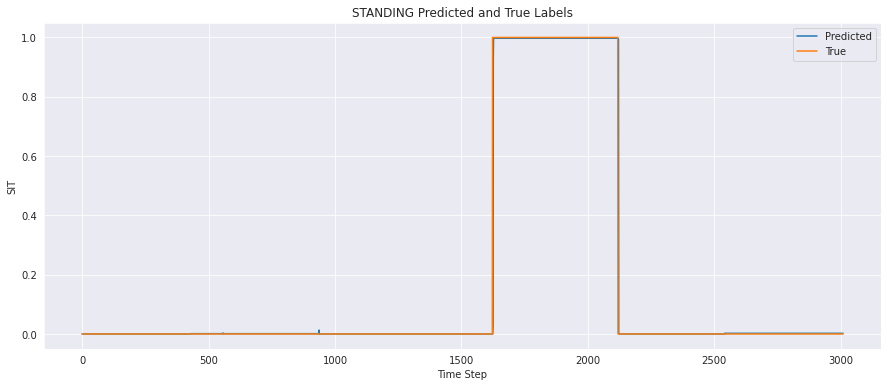

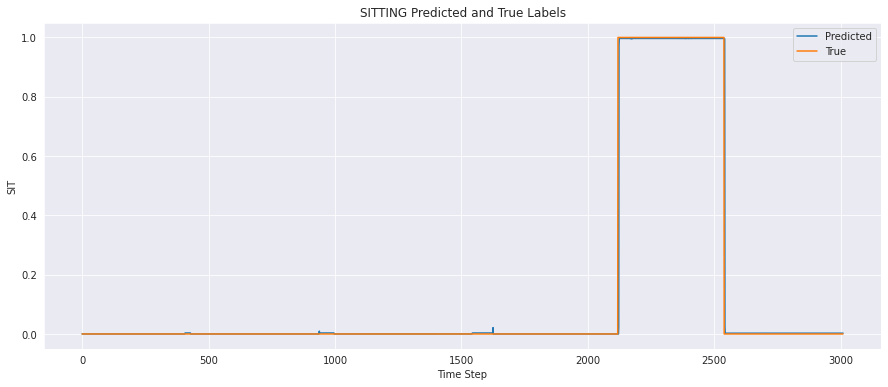

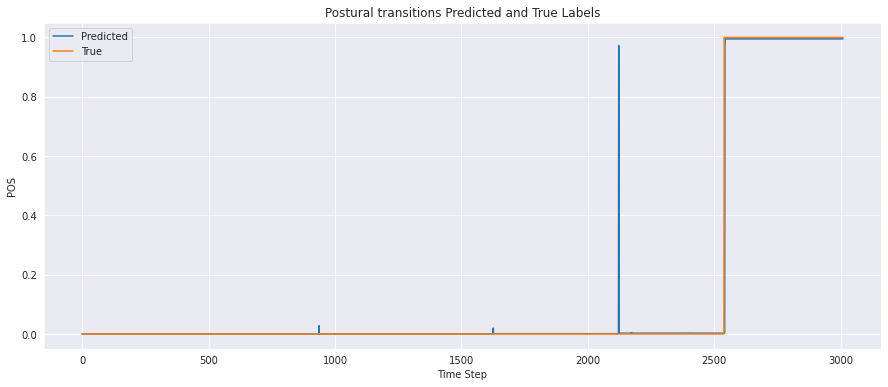

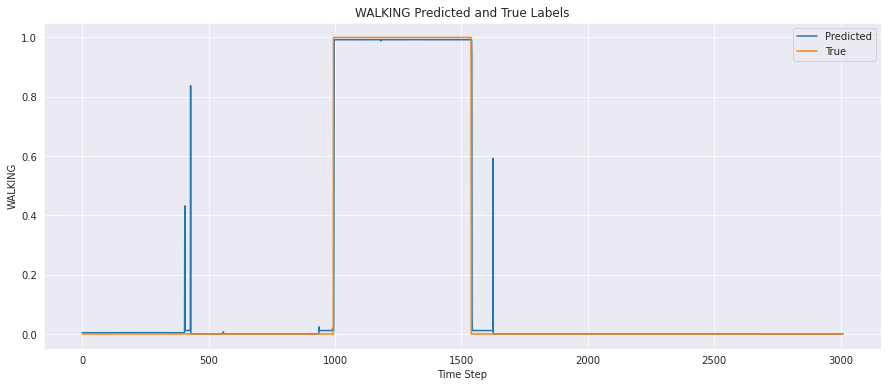

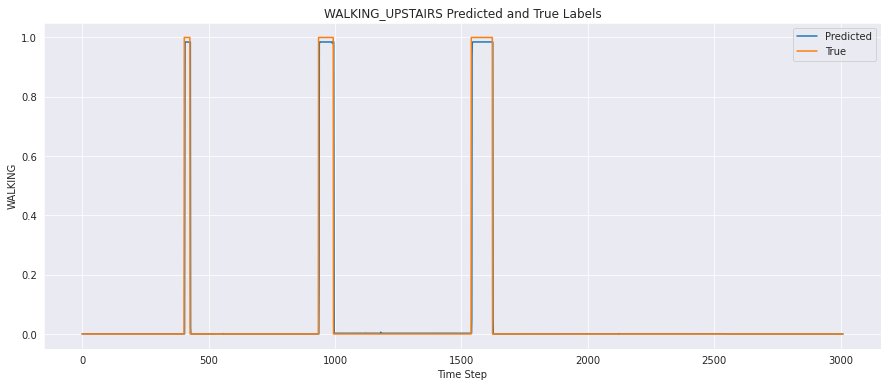

In [ ]:
plot_pred_result(
    pred_labels =STANDING_pred_test,
    true_labels =STANDING_true_test,
    title ='STANDING Predicted and True Labels', 
    x_label ='Time Step',
    y_label='SIT',
    legend_labels =['Predicted', 'True'])

plot_pred_result(
    pred_labels =SITTING_pred_test,
    true_labels =SITTING_true_test,
    title ='SITTING Predicted and True Labels', 
    x_label ='Time Step',
    y_label='SIT',
    legend_labels =['Predicted', 'True'])

plot_pred_result(
    pred_labels =POS_pred_test,
    true_labels =POS_true_test,
    title ='Postural transitions Predicted and True Labels', 
    x_label ='Time Step',
    y_label='POS',
    legend_labels =['Predicted', 'True'])

plot_pred_result(
    pred_labels =WALKING_pred_test,
    true_labels =WALKING_true_test,
    title ='WALKING Predicted and True Labels', 
    x_label ='Time Step',
    y_label='WALKING',
    legend_labels =['Predicted', 'True'])


plot_pred_result(
    pred_labels =WALKING_UPSTAIRS_pred_test,
    true_labels =WALKING_UPSTAIRS_true_test,
    title ='WALKING_UPSTAIRS Predicted and True Labels', 
    x_label ='Time Step',
    y_label='WALKING',
    legend_labels =['Predicted', 'True'])


## Building an RNN Model for Activity Type Prediction with Three Classe

Based on the cluster graph, we can observe that static activities (Standing and Sitting) are clustered together, while dynamic activities (Walking_Upstairs, Walking_Downstairs, and Walking) are closely clustered. Laying (static activity) is found in a separate group and located on the positive x-axis side along with Sitting and Standing

In [ ]:
# Create a dictionary to map activity names to types Ids (SIT=0, MOT=1 and POS=2)
activity_type_id_map = {'SITTING': 0, 'STANDING': 0, 'LAYING': 0, 'WALKING': 1, 'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 1,'POS': 2}
# Create a dictionary to map activity names to types Names
activity_type_name_map = {'SITTING': 'SIT', 'STANDING': 'SIT', 'LAYING': 'SIT', 'WALKING': 'MOT', 'WALKING_UPSTAIRS': 'MOT', 'WALKING_DOWNSTAIRS': 'MOT','POS': 'POS'}

In [ ]:
# Apply the mapping to create a new column 'activity_type' in x_train_df
X_train_df1['activity_type_id'] = X_train_df1['activity_name'].map(activity_type_id_map)
X_train_df1['activity_type_name'] = X_train_df1['activity_name'].map(activity_type_name_map)

# Apply the mapping to create a new column 'activity_Type' in x_test_df
X_test_df1['activity_type_id'] = X_test_df1['activity_name'].map(activity_type_id_map)
X_test_df1['activity_type_name'] = X_test_df1['activity_name'].map(activity_type_name_map)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7767 samples in 0.002s...
[t-SNE] Computed neighbors for 7767 samples in 1.513s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7767
[t-SNE] Computed conditional probabilities for sample 2000 / 7767
[t-SNE] Computed conditional probabilities for sample 3000 / 7767
[t-SNE] Computed conditional probabilities for sample 4000 / 7767
[t-SNE] Computed conditional probabilities for sample 5000 / 7767
[t-SNE] Computed conditional probabilities for sample 6000 / 7767
[t-SNE] Computed conditional probabilities for sample 7000 / 7767
[t-SNE] Computed conditional probabilities for sample 7767 / 7767
[t-SNE] Mean sigma: 1.423747
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.228729
[t-SNE] KL divergence after 1000 iterations: 1.296453


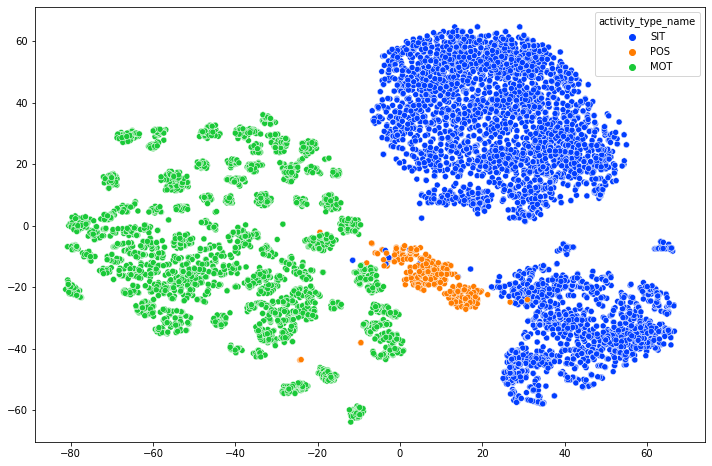

In [ ]:
tsne_ptl(df = X_train_df1,drop_columns =['activity_type_id',"activity_type_name",'user_id','activity_id','activity_name'],hue="activity_type_name",n_iter = 1000)

### Data Balance 

To ensure the dataset is suitable for training, it is useful to determine the balance of the activities in the data frame.

In [ ]:
activities = ['SIT', 'POS', 'MOT']
df_balance(df=X_train_df1,group_by_column='activity_type_name',classes=activities)

SIT, total=3286, percentage=42.307
POS, total=352, percentage=4.532
MOT, total=4129, percentage=53.161


The analysis of the dataset reveals that the number of observations for the POS activity is much lower than those for the SIT and MOT activities. This imbalance in the number of observations could potentially affect the training process and lead to inaccurate results. It is important to have a balanced dataset, as a model trained on an imbalanced dataset may be biased towards the majority class (SIT and MOT), leading to poor performance on the minority class (POS).

To address this imbalance, there are several methods that can be used, such as oversampling the minority class or undersampling the majority class. However, due to the time constraints of the project, it was decided to use the dataset as is and proceed with training the model. While this approach may lead to some bias in the model towards the majority classes, it is the best solution given the time constraints.

### Training

In [ ]:
#y_train= X_train_df1['activity_type_id']
#y_test= X_test_df1['activity_type_id']

In [ ]:
#print('y_train shape',y_train.shape)
#print('y_test shape',y_test.shape)

y_train shape (7767,)
y_test shape (3162,)


In [ ]:
# Reshape the y_train and y_test to shape (7767, 1)
#y_train = y_train.values.reshape(-1, 1)
#y_test = y_test.values.reshape(-1, 1)

In [ ]:
#print('y_train shape',y_train.shape)
#print('y_test shape',y_test.shape)

y_train shape (7767, 1)
y_test shape (3162, 1)


In [ ]:
# 'activity_type_id',
X_train = X_train_df1.drop(["activity_type_name",'user_id','activity_id','activity_name'], axis = 1)
X_test = X_test_df1.drop(["activity_type_name",'user_id','activity_id','activity_name'], axis = 1)

In [ ]:
X_train.columns

Index(['tBodyAcc-Mean-1', 'tBodyAcc-Mean-2', 'tBodyAcc-Mean-3',
       'tBodyAcc-STD-1', 'tBodyAcc-STD-2', 'tBodyAcc-STD-3', 'tBodyAcc-Mad-1',
       'tBodyAcc-Mad-2', 'tBodyAcc-Mad-3', 'tBodyAcc-Max-1',
       ...
       'fBodyGyroJerkMag-Skewness-1', 'fBodyGyroJerkMag-Kurtosis-1',
       'tBodyAcc-AngleWRTGravity-1', 'tBodyAccJerk-AngleWRTGravity-1',
       'tBodyGyro-AngleWRTGravity-1', 'tBodyGyroJerk-AngleWRTGravity-1',
       'tXAxisAcc-AngleWRTGravity-1', 'tYAxisAcc-AngleWRTGravity-1',
       'tZAxisAcc-AngleWRTGravity-1', 'activity_type_id'],
      dtype='object', length=562)

In [ ]:
print('X_train shape:',X_train.shape)
print('X_test shape:',X_test.shape)

X_train shape: (7767, 562)
X_test shape: (3162, 562)


In [ ]:
input_seq = []
target_seq  = []

# determines how many time steps the model will look back to make a prediction
seq_length =150  #3 seconds (150 time steps at 50Hz)

# determines how many time steps into the future the model will try to predict
ph = 1

<font color='red'>To avoid running into memory issues during training, I decided to use only 15 columns from the dataset. Despite using Colab Pro with High-RAM, I encountered crashes due to memory limitations. I selected the columns that provide a strong signal for distinguishing between the different activity types.</font>

In [ ]:
#x_cols = X_train.drop('activity_type_id', axis=1).columns
x_cols = ['fBodyAcc-Mean-1','fBodyAcc-Mean-2','fBodyAcc-Mean-3','fBodyGyro-Mean-1','fBodyGyro-Mean-2',
'fBodyGyro-Mean-3','tBodyAccMag-Mean-1', 'tGravityAccMag-Mean-1','tBodyAccJerkMag-Mean-1', 'tBodyGyroMag-Mean-1', 
'tBodyGyroJerkMag-Mean-1', 'fBodyAccMag-Mean-1', 'fBodyAccJerkMag-Mean-1',  'fBodyGyroMag-Mean-1','fBodyGyroJerkMag-Mean-1','activity_type_id']
y_col = 'activity_type_id'

In [ ]:
#create list of sequence length seniors readings
for start in range(1,len(X_train)-seq_length-ph):
  input_seq.append(X_train[x_cols].iloc[start:start+seq_length].to_numpy())

#create list of sequence length seniors readings
for start in range(1,len(X_train)-seq_length-ph):
  target_seq .append(X_train[y_col].iloc[start+seq_length+ph])

input_seq = np.array(input_seq, dtype = object).astype(np.float32)
target_seq = np.array(target_seq, dtype = object).astype(np.float32)

target_seq = to_categorical(target_seq, num_classes=3)

In [ ]:
print('input_seq shape',input_seq.shape)
print('target_seq shape',target_seq.shape)

input_seq shape (7615, 150, 16)
target_seq shape (7615, 3)


In [ ]:
# determines how many time steps the model will look back to make a prediction
seq_length =150  #3 seconds (150 time steps at 50Hz)

# determines how many time steps into the future the model will try to predict
ph = 1

# define path to save model
model_path = 'RNN_model.h5'

# specify the evaluation metric(s) to be used during training and testing of the model
metrics = [
    'accuracy', #The proportion of correctly classified samples.
    'categorical_accuracy', #The proportion of correctly classified samples for multi-class classification problems.
    ]

#I think categorical_crossentropy is a good choice for a classification problem 
#with three classes where the target labels are integers (0, 1, or 2).
loss= 'categorical_crossentropy'

# The learning rate is a hyperparameter that controls how much the weights of the neural network are updated during training. 
# It determines the step size at each iteration while moving toward a minimum of a loss function. 
# a small learning rate is often a good starting point
learning_rate = 0.002

#number of features included in the training data
nb_features = len(x_cols) 

#output length
nb_out = 3

# build the network
model = Sequential()

#add first(input) RNN layer
model.add(
    SimpleRNN(
      input_shape=(seq_length, nb_features), #shape of input layer
      units=128, #number of hidden units
      return_sequences=True
    )
)

#dropout for regularization
model.add(Dropout(0.2)) 

# add second RNN layer
model.add(SimpleRNN(units=64,return_sequences=True ))

#dropout for regularization
model.add(Dropout(0.2))

# add second RNN layer
model.add(SimpleRNN(units=16,return_sequences=False ))

#dropout for regularization
model.add(Dropout(0.2))

# Add the output layer with the appropriate number of units and activation function
model.add(Dense(units=nb_out,activation='softmax'))

optimizer = keras.optimizers.Adam(learning_rate = learning_rate)

model.compile(loss=loss, optimizer=optimizer,metrics=metrics)

print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_29 (SimpleRNN)   (None, 150, 128)          18560     
                                                                 
 dropout_28 (Dropout)        (None, 150, 128)          0         
                                                                 
 simple_rnn_30 (SimpleRNN)   (None, 150, 64)           12352     
                                                                 
 dropout_29 (Dropout)        (None, 150, 64)           0         
                                                                 
 simple_rnn_31 (SimpleRNN)   (None, 16)                1296      
                                                                 
 dropout_30 (Dropout)        (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 3)               

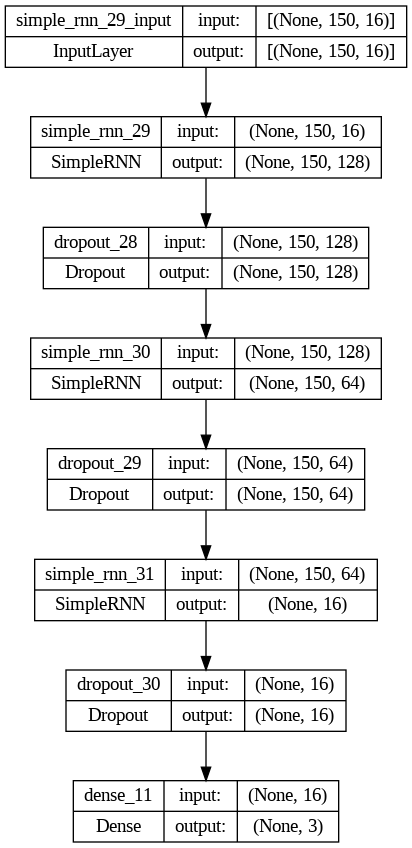

In [ ]:
# Plot the model graph
plot_model(model, show_shapes=True)

In [ ]:
# fit the network
history = model.fit(input_seq, target_seq, epochs=100, batch_size=500,validation_split=0.05, verbose=2)

Epoch 1/100
15/15 - 7s - loss: 0.3084 - accuracy: 0.9019 - categorical_accuracy: 0.9019 - val_loss: 0.0595 - val_accuracy: 1.0000 - val_categorical_accuracy: 1.0000 - 7s/epoch - 462ms/step
Epoch 2/100
15/15 - 5s - loss: 0.1976 - accuracy: 0.9454 - categorical_accuracy: 0.9454 - val_loss: 0.5570 - val_accuracy: 0.9318 - val_categorical_accuracy: 0.9318 - 5s/epoch - 313ms/step
Epoch 3/100
15/15 - 5s - loss: 0.1624 - accuracy: 0.9505 - categorical_accuracy: 0.9505 - val_loss: 0.0234 - val_accuracy: 1.0000 - val_categorical_accuracy: 1.0000 - 5s/epoch - 318ms/step
Epoch 4/100
15/15 - 5s - loss: 0.0593 - accuracy: 0.9859 - categorical_accuracy: 0.9859 - val_loss: 0.0098 - val_accuracy: 1.0000 - val_categorical_accuracy: 1.0000 - 5s/epoch - 304ms/step
Epoch 5/100
15/15 - 5s - loss: 0.0364 - accuracy: 0.9950 - categorical_accuracy: 0.9950 - val_loss: 0.0068 - val_accuracy: 1.0000 - val_categorical_accuracy: 1.0000 - 5s/epoch - 310ms/step
Epoch 6/100
15/15 - 5s - loss: 0.0320 - accuracy: 0.994

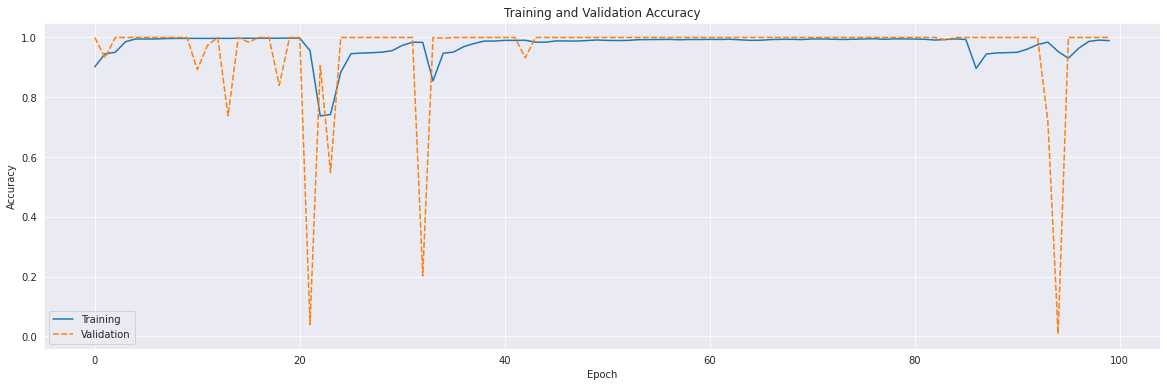

In [ ]:
# convert history dictionary to Pandas DataFrame
history_df = pd.DataFrame(history.history)

# plot training and validation accuracy separately
sns.set_style("darkgrid")
plt.figure(figsize=(20, 6))
plt.title("Training and Validation Accuracy")
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(labels=['Training', 'Validation'])
plt.show()

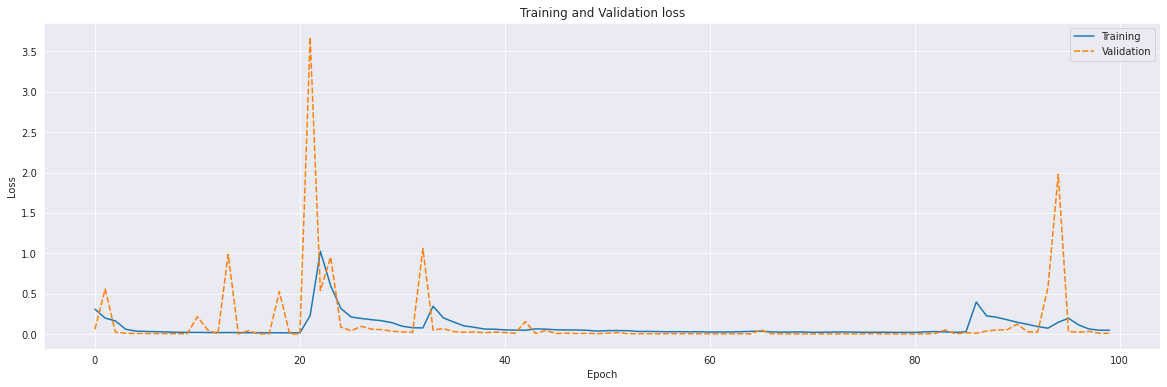

In [ ]:
# plot training and validation loss
sns.set_style("darkgrid")
plt.figure(figsize=(20, 6))
plt.title("Training and Validation loss")
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(labels=['Training', 'Validation'])
plt.show()

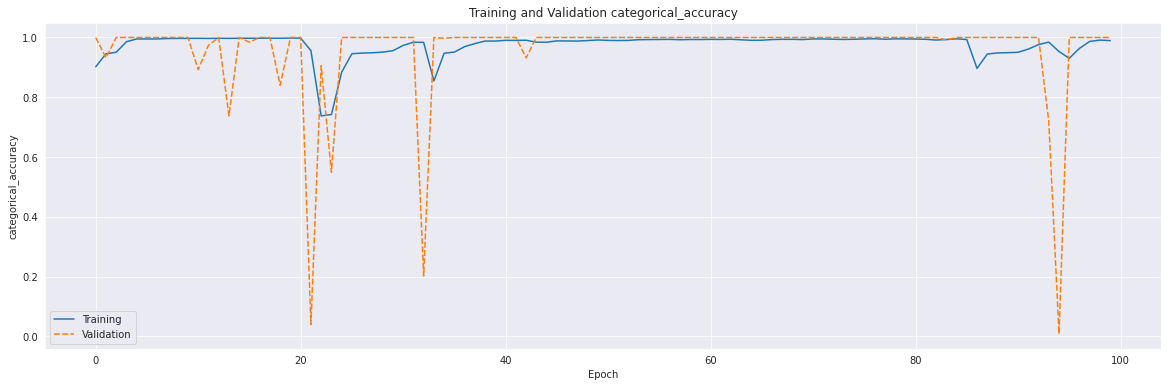

In [ ]:
# plot training and validation categorical_accuracy
sns.set_style("darkgrid")
plt.figure(figsize=(20, 6))
plt.title("Training and Validation categorical_accuracy")
sns.lineplot(data=history_df[['categorical_accuracy', 'val_categorical_accuracy']])
plt.xlabel("Epoch")
plt.ylabel("categorical_accuracy")
plt.legend(labels=['Training', 'Validation'])
plt.show()

### Evaluate the model

In [ ]:
x_test_input_seq = []
test_target_seq  = []

#create list of GAP readings starting with a minimum of two readings
for end in range(1, len(X_test)-ph):
  #add short sequences until we reach the sequence length
  if end < seq_length:
    x_test_input_seq.append(X_test[x_cols][0:end].to_numpy())
    test_target_seq.append(X_test[y_col][end+ph])
    #add sequences of seq_length once we have enough data
  else:
    x_test_input_seq.append(X_test[x_cols][end-seq_length:end].to_numpy())
    test_target_seq.append(X_test[y_col][end+ph])

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32
x_test_input_seq = pad_sequences(x_test_input_seq, maxlen = seq_length, dtype = np.float32)

#convert to numpy arrays and floats to appease keras/tensorflow
test_target_seq = np.array(test_target_seq, dtype = object).astype(np.float32)

In [ ]:
test_target_seq = to_categorical(test_target_seq, num_classes=3)

In [ ]:
x_test_input_seq.shape

(3160, 150, 16)

In [ ]:
test_target_seq.shape

(3160, 3)

In [ ]:
scores_test = model.evaluate(x_test_input_seq, test_target_seq, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

99/99 - 3s - loss: 0.0818 - accuracy: 0.9699 - categorical_accuracy: 0.9699 - 3s/epoch - 32ms/step

MSE: 0.969936728477478


In [ ]:
scores_test

[0.18733914196491241, 0.9462025165557861, 0.9462025165557861]

In [ ]:
y_pred_test = model.predict(x_test_input_seq)
y_true_test = test_target_seq


99/99 [==============================] - 4s 33ms/step


In [ ]:
# SIT (Sedentary inactivity): SITTING, STANDING and LAYING
SIT_true_test = y_true_test[:, 0]
SIT_pred_test = y_pred_test[:, 0]

# POS (Postural transitions): STAND_TO_SIT, SIT_TO_STAND, SIT_TO_LIE, LIE_TO_SIT, STAND_TO_LIE and LIE_TO_STAND
POS_true_test = y_true_test[:, 1]
POS_pred_test = y_pred_test[:, 1]

# MOT (Movement on foo): WALKING, WALKING_UPSTAIRS and WALKING_DOWNSTAIRS
MOT_true_test = y_true_test[:, 2]
MOT_pred_test = y_pred_test[:, 2]

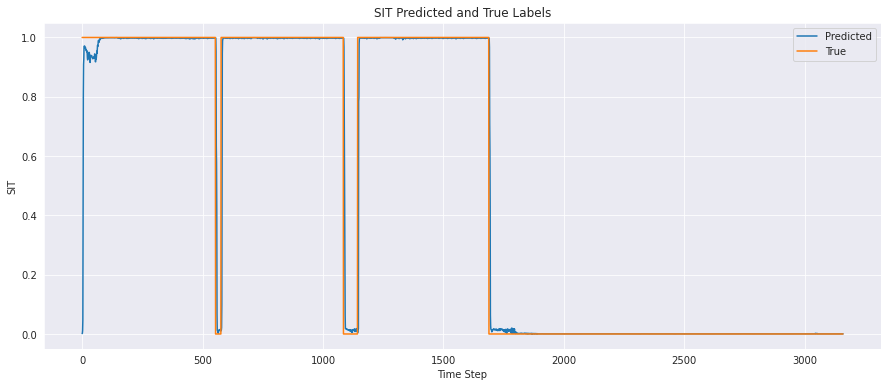

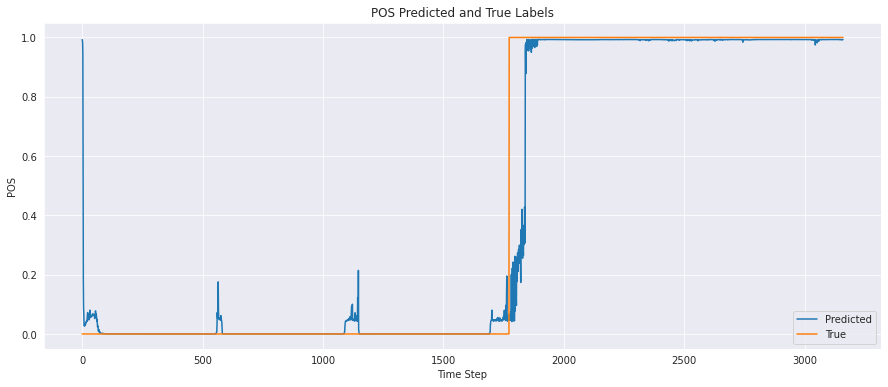

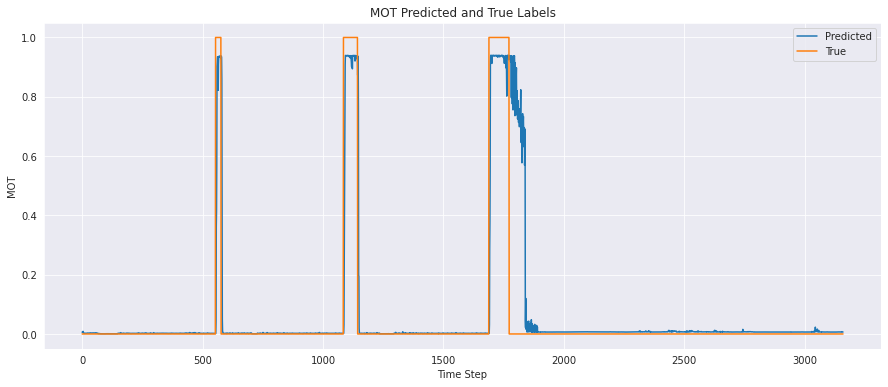

In [ ]:
plot_pred_result(
    pred_labels =SIT_pred_test,
    true_labels =SIT_true_test,
    title ='SIT Predicted and True Labels', 
    x_label ='Time Step',
    y_label='SIT',
    legend_labels =['Predicted', 'True'])

plot_pred_result(
    pred_labels =POS_pred_test,
    true_labels =POS_true_test,
    title ='POS Predicted and True Labels', 
    x_label ='Time Step',
    y_label='POS',
    legend_labels =['Predicted', 'True'])

plot_pred_result(
    pred_labels =MOT_pred_test,
    true_labels =MOT_true_test,
    title ='MOT Predicted and True Labels', 
    x_label ='Time Step',
    y_label='MOT',
    legend_labels =['Predicted', 'True'])

# Part Two

## Load Data

Human Activity Recognition contains the following files:

- **RawData/acc_expXX_userYY.txt**: contains the raw triaxial acceleration signals for each user and experiment. Each row of the file represents one acceleration sample (three-axis) captured at a frequency of 50Hz.

- **RawData/gyro_expXX_userYY.txt**: contains the raw triaxial angular speed signals for each user and experiment. Each row of the file represents one angular velocity sample (three-axis) captured at a frequency of 50Hz.

- **RawData/labels.txt**: includes all the activity labels available for the dataset. Each row of the file contains the following information:

 - Experiment number ID
 - User number ID
 - Activity number ID
 - Label start point (in number of signal log samples recorded at 50Hz)
 - Label end point (in number of signal log samples recorded at 50Hz)

Example:  The file name format is "**acc_expXX_userYY.txt**", where XX is the experiment number and YY is the user number.



In [ ]:
# Load the labels file
labels_df = pd.read_csv(google_driver_path + 'RawData/labels.txt', header=None, names=["experiment_id", "user_id", "activity_id", "start_point", "end_point"], sep='\s+')
activity_labels_df = pd.read_csv(google_driver_path + 'activity_labels.txt', header=None, sep='\s+', names=['activity_id', 'activity_name'])

In [ ]:
labels_df.head()

experiment_id  user_id  activity_id  start_point  end_point
0              1        1            5          250       1232
1              1        1            7         1233       1392
2              1        1            4         1393       2194
3              1        1            8         2195       2359
4              1        1            5         2360       3374

The accelerometer and gyroscope data files for a given experiment have the same number of rows. This is because the data was collected at a fixed sampling frequency (50 Hz), and the data was recorded for a fixed amount of time for each experiment. Therefore, the data for each experiment has the same number of samples.

Since the data is stored in separate files for each experiment, each file represents a subset of the complete data for that experiment. However, it's important to note that not all rows in the data are considered "useful". Only the rows that correspond to actual activity periods, i.e. where an activity ID is recorded, are considered useful for the purposes of this analysis. Some of the rows in the data files may represent periods where the user was not performing the activity protocol, and these rows are considered not useful for this analysis.

Therefore, when working with the accelerometer and gyroscope data, it's important to filter out the rows that are not considered useful for the analysis, and only work with the rows that correspond to actual activity periods. This can be done by selecting only the rows where an activity ID is recorded, and discarding the rest.

**load_experiment_data** method loads the raw sensor data files, extracting the sensor data for each activity segment, and labeling the data with the activity ID, user ID, experiment ID, and other relevant information. The resulting dataframe can be used to train machine learning models for activity recognition.

To calculate the time for each sample in the activity segment, we first convert the start_point and end_point from sample numbers to seconds by dividing by the sampling frequency (50). This gives us the start and end times for the activity segment in seconds.
Next, we use a list comprehension to create a list of time values for each sample in the activity segment. We then divide each value in the range by the sampling frequency to convert it from sample numbers to seconds, and add the result to the start time of the activity segment. This gives us the time for each sample relative to the start of the activity segment in seconds.
The resulting list of time values is then added as a new column called time to the activity data dataframe. The time column is used to track the time for each sample in the activity segment and can be used for time-based analyses of the sensor data.


In [ ]:
raw_data_path = google_driver_path + 'RawData/'

# Define the column names for the activity data DataFrame
column_names = ["x", "y", "z", "activity_id", "user_id", "experiment_id", "start_point", "end_point", "time", "sensor_type"]
acc_df = load_experiment_data(column_names,labels_df,raw_data_path,'acc')
gyro_df = load_experiment_data(column_names,labels_df,raw_data_path,'gyro')

In [ ]:
print('acc_df shape',acc_df.shape)
print('gyro_df shape',gyro_df.shape)

acc_df shape (815614, 10)
gyro_df shape (815614, 10)


In [ ]:
acc_df.head()

x         y         z  activity_id  user_id  experiment_id  \
0  1.020833 -0.125000  0.105556            5        1              1   
1  1.025000 -0.125000  0.101389            5        1              1   
2  1.020833 -0.125000  0.104167            5        1              1   
3  1.016667 -0.125000  0.108333            5        1              1   
4  1.018056 -0.127778  0.108333            5        1              1   

   start_point  end_point  time sensor_type  
0          250       1232  5.00         acc  
1          250       1232  5.02         acc  
2          250       1232  5.04         acc  
3          250       1232  5.06         acc  
4          250       1232  5.08         acc

In [ ]:
gyro_df.head()

x         y         z  activity_id  user_id  experiment_id  \
0 -0.002749 -0.004276  0.002749            5        1              1   
1 -0.000305 -0.002138  0.006109            5        1              1   
2  0.012217  0.000916 -0.007330            5        1              1   
3  0.011301 -0.001833 -0.006414            5        1              1   
4  0.010996 -0.001527 -0.004887            5        1              1   

   start_point  end_point  time sensor_type  
0          250       1232  5.00        gyro  
1          250       1232  5.02        gyro  
2          250       1232  5.04        gyro  
3          250       1232  5.06        gyro  
4          250       1232  5.08        gyro

The accelerometer and gyroscope data frames have the same number of rows and columns. This is because the accelerometer and gyroscope data were collected at the same time, using the same sensors, and stored in separate files for organizational purposes.

In [ ]:
# Rename columns in acc_df
acc_df = acc_df.rename(columns={"x": "acc_x", "y": "acc_y", "z": "acc_z"})

# Rename columns in gyro_df
gyro_df = gyro_df.rename(columns={"x": "gyro_x", "y": "gyro_y", "z": "gyro_z"})

In [ ]:
acc_df.head()

acc_x     acc_y     acc_z  activity_id  user_id  experiment_id  \
0  1.020833 -0.125000  0.105556            5        1              1   
1  1.025000 -0.125000  0.101389            5        1              1   
2  1.020833 -0.125000  0.104167            5        1              1   
3  1.016667 -0.125000  0.108333            5        1              1   
4  1.018056 -0.127778  0.108333            5        1              1   

   start_point  end_point  time sensor_type  
0          250       1232  5.00         acc  
1          250       1232  5.02         acc  
2          250       1232  5.04         acc  
3          250       1232  5.06         acc  
4          250       1232  5.08         acc

In [ ]:
gyro_df.head()

gyro_x    gyro_y    gyro_z  activity_id  user_id  experiment_id  \
0 -0.002749 -0.004276  0.002749            5        1              1   
1 -0.000305 -0.002138  0.006109            5        1              1   
2  0.012217  0.000916 -0.007330            5        1              1   
3  0.011301 -0.001833 -0.006414            5        1              1   
4  0.010996 -0.001527 -0.004887            5        1              1   

   start_point  end_point  time sensor_type  
0          250       1232  5.00        gyro  
1          250       1232  5.02        gyro  
2          250       1232  5.04        gyro  
3          250       1232  5.06        gyro  
4          250       1232  5.08        gyro

In [ ]:
# Merge acc_df and gyro_df on common columns
df = acc_df.merge(gyro_df, on=["activity_id", "user_id", "experiment_id", "start_point", "end_point", "time"])

# Define the new order of columns
new_order = ["time","start_point",	"end_point", "experiment_id", "user_id", "activity_id", "acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]

# Reorder the columns of merged_df
df = df.reindex(columns=new_order)
df = df.sort_values(by=["time"])

# Check the shape of the merged DataFrame
print("Shape of merged DataFrame:", df.shape)

Shape of merged DataFrame: (815614, 12)


**acc_df** and **gyro_df**, which contain accelerometer and gyroscope sensor data, respectively, have been combined into a single data frame called **df**. The data frames have been combined based on their time series, which means that the rows of the combined data frame are arranged in ascending order based on the values in the time column.
The resulting combined data frame has columns for the accelerometer and gyroscope readings, as well as columns for the activity ID, user ID, experiment ID, start point, end point, and time. The combined data frame contains all of the readings from both sensors for each activity segment and is ordered by time, which ensures that the data is aligned and ready for further analysis or machine learning modeling.


In [ ]:
df.head()

time  start_point  end_point  experiment_id  user_id  activity_id  \
105008  2.72          136       1221              9        5            5   
105009  2.74          136       1221              9        5            5   
105010  2.76          136       1221              9        5            5   
105011  2.78          136       1221              9        5            5   
105012  2.80          136       1221              9        5            5   

           acc_x     acc_y     acc_z    gyro_x    gyro_y    gyro_z  
105008  1.022222 -0.105556  0.200000 -0.178067 -0.196393 -0.697608  
105009  1.266667 -0.048611  0.080556 -0.164934 -0.188452 -0.960280  
105010  1.154167 -0.045833  0.105556 -0.034514 -0.102625 -1.041831  
105011  0.856944 -0.009722  0.175000 -0.077885 -0.255953 -0.733038  
105012  1.370833 -0.038889  0.150000 -0.013439 -0.173180 -0.534813

In [ ]:
df.tail()

time  start_point  end_point  experiment_id  user_id  activity_id  \
801082  450.72        21752      22540             60       30            2   
801083  450.74        21752      22540             60       30            2   
801084  450.76        21752      22540             60       30            2   
801085  450.78        21752      22540             60       30            2   
801086  450.80        21752      22540             60       30            2   

           acc_x     acc_y     acc_z    gyro_x    gyro_y    gyro_z  
801082  0.719444 -0.291667 -0.009722 -0.159741  1.142013  0.005498  
801083  0.755556 -0.293056  0.002778 -0.106291  1.133155 -0.043066  
801084  0.800000 -0.270833  0.006944 -0.110872  1.032668 -0.062308  
801085  0.800000 -0.270833  0.006944 -0.142637  0.965473 -0.073915  
801086  0.801389 -0.240278  0.030556 -0.178678  0.873232 -0.054978

## Data Normalization: Rescaling Sensor Values to a Standard Range

In [ ]:
# Find the max and min values for the accelerometer and gyroscope columns
acc_cols = ['acc_x', 'acc_y', 'acc_z']
gyro_cols = ['gyro_x', 'gyro_y', 'gyro_z']

acc_max = df[acc_cols].max()
acc_min = df[acc_cols].min()
gyro_max = df[gyro_cols].max()
gyro_min = df[gyro_cols].min()

# Print the max and min values for each column
print("Max values for accelerometer columns:")
print(acc_max)
print("\nMin values for accelerometer columns:")
print(acc_min)
print("\nMax values for gyroscope columns:")
print(gyro_max)
print("\nMin values for gyroscope columns:")
print(gyro_min)


Max values for accelerometer columns:
acc_x    2.004167
acc_y    1.716667
acc_z    1.502778
dtype: float64

Min values for accelerometer columns:
acc_x   -0.647222
acc_y   -1.698611
acc_z   -1.837500
dtype: float64

Max values for gyroscope columns:
gyro_x    5.964488
gyro_y    6.240294
gyro_z    3.408628
dtype: float64

Min values for gyroscope columns:
gyro_x   -5.249165
gyro_y   -6.323371
gyro_z   -3.124270
dtype: float64


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Define the columns to be rescaled
cols_to_rescale = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

# Create a MinMaxScaler object
# compute the minimum and maximum values of each column, and then scales the values to the range -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler to the data and transform the columns
df[cols_to_rescale] = scaler.fit_transform(df[cols_to_rescale])

In [ ]:
df.describe()

time    start_point      end_point  experiment_id  \
count  815614.000000  815614.000000  815614.000000   815614.00000   
mean      164.812305    7786.689761    8694.540782       32.25450   
std       102.568378    5191.509913    5055.157684       17.72868   
min         2.720000     136.000000    1116.000000        1.00000   
25%        77.740000    3440.000000    4409.000000       17.00000   
50%       147.980000    6938.000000    7928.000000       34.00000   
75%       249.620000   12089.000000   12843.000000       48.00000   
max       450.800000   21752.000000   22540.000000       61.00000   

             user_id    activity_id          acc_x          acc_y  \
count  815614.000000  815614.000000  815614.000000  815614.000000   
mean       16.031163       4.103177       0.096549       0.013980   
std         8.673952       2.396917       0.308632       0.237521   
min         1.000000       1.000000      -1.000000      -1.000000   
25%         9.000000       2.000000      -0.002619      -0.136234   
50%        17.000000       4.000000       0.204819      -0.047580   
75%        24.000000       6.000000       0.257203       0.119967   
max        30.000000      12.000000       1.000000       1.000000   

               acc_z         gyro_x         gyro_y         gyro_z  
count  815614.000000  815614.000000  815614.000000  815614.000000  
mean        0.152683      -0.062124       0.006030      -0.045366  
std         0.207075       0.078760       0.065434       0.091403  
min        -1.000000      -1.000000      -1.000000      -1.000000  
25%         0.028690      -0.072397      -0.005203      -0.055309  
50%         0.127651      -0.062537       0.006710      -0.043621  
75%         0.243243      -0.049899       0.014246      -0.029875  
max         1.000000       1.000000       1.000000       1.000000

## Checking for Missing Data

In [ ]:
# Check for null values in the DataFrame
null_counts = df.isnull().sum()

# Print the number of null values for each column
print(null_counts)

time             0
start_point      0
end_point        0
experiment_id    0
user_id          0
activity_id      0
acc_x            0
acc_y            0
acc_z            0
gyro_x           0
gyro_y           0
gyro_z           0
dtype: int64


## Detecting and Handling Outliers

<AxesSubplot:>

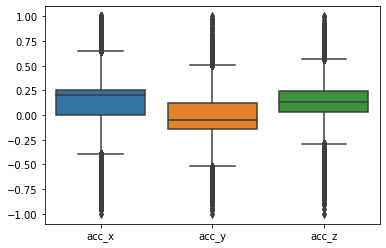

In [ ]:
# Create box plots for each column
sns.boxplot(data=df[['acc_x', 'acc_y', 'acc_z']])

<AxesSubplot:>

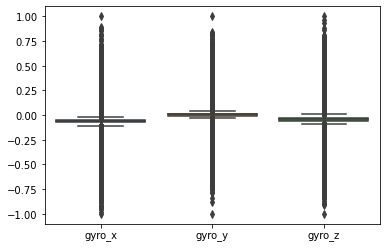

In [ ]:
# Create a scatter plot for each column
sns.boxplot(data=df[['gyro_x', 'gyro_y', 'gyro_z']])

## Visualizing Data for Analysis and Understanding

In [ ]:
df = pd.merge(df, activity_labels_df, on='activity_id')

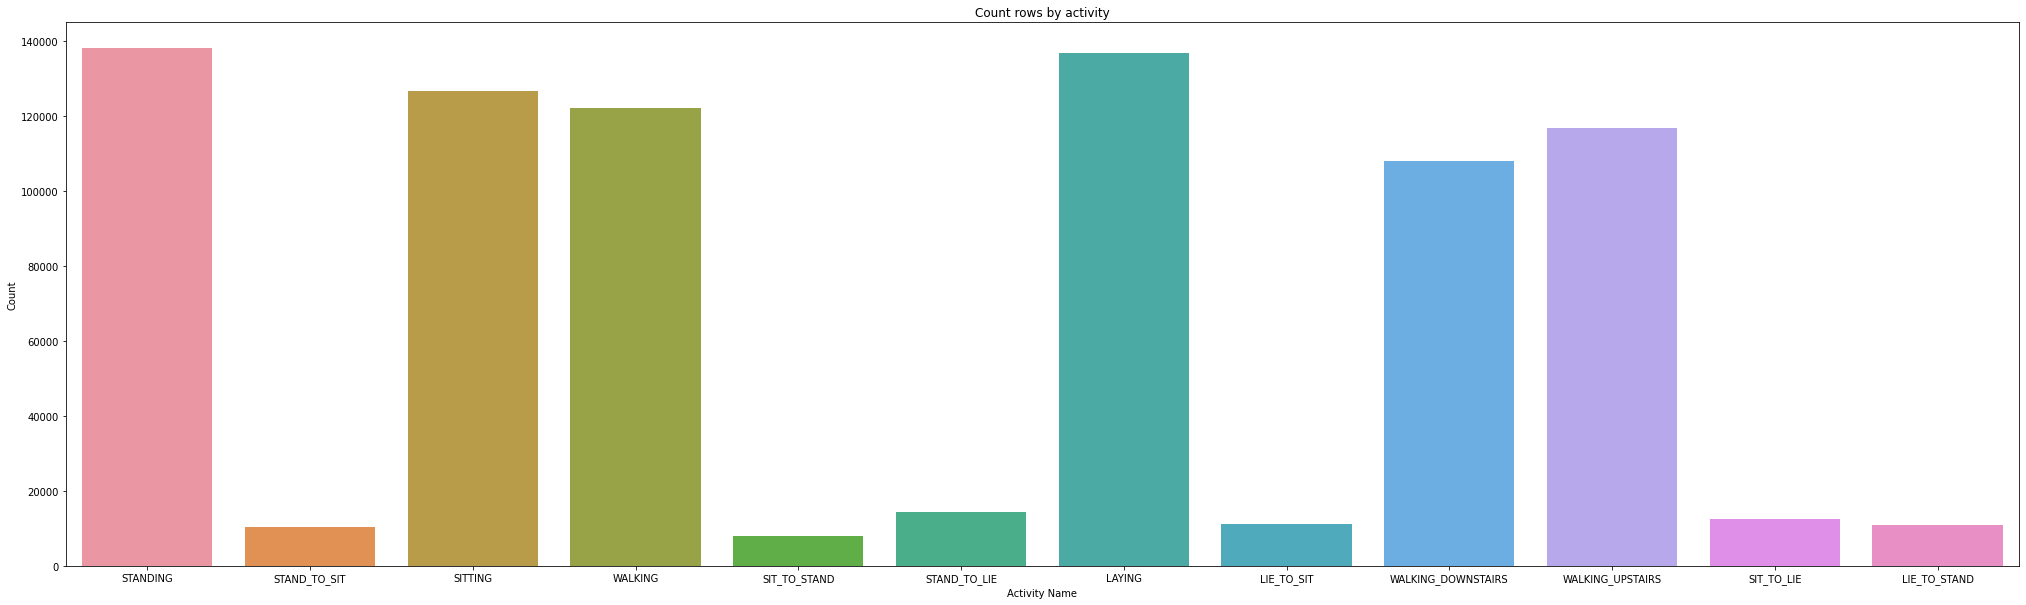

In [ ]:
_plot_count(
    x='activity_name',
    data=df,
    plt_title='Count rows by activity',
    x_label ='Activity Name',
    y_label='Count',
    figsize_w= 35,
    figsize_h= 10)

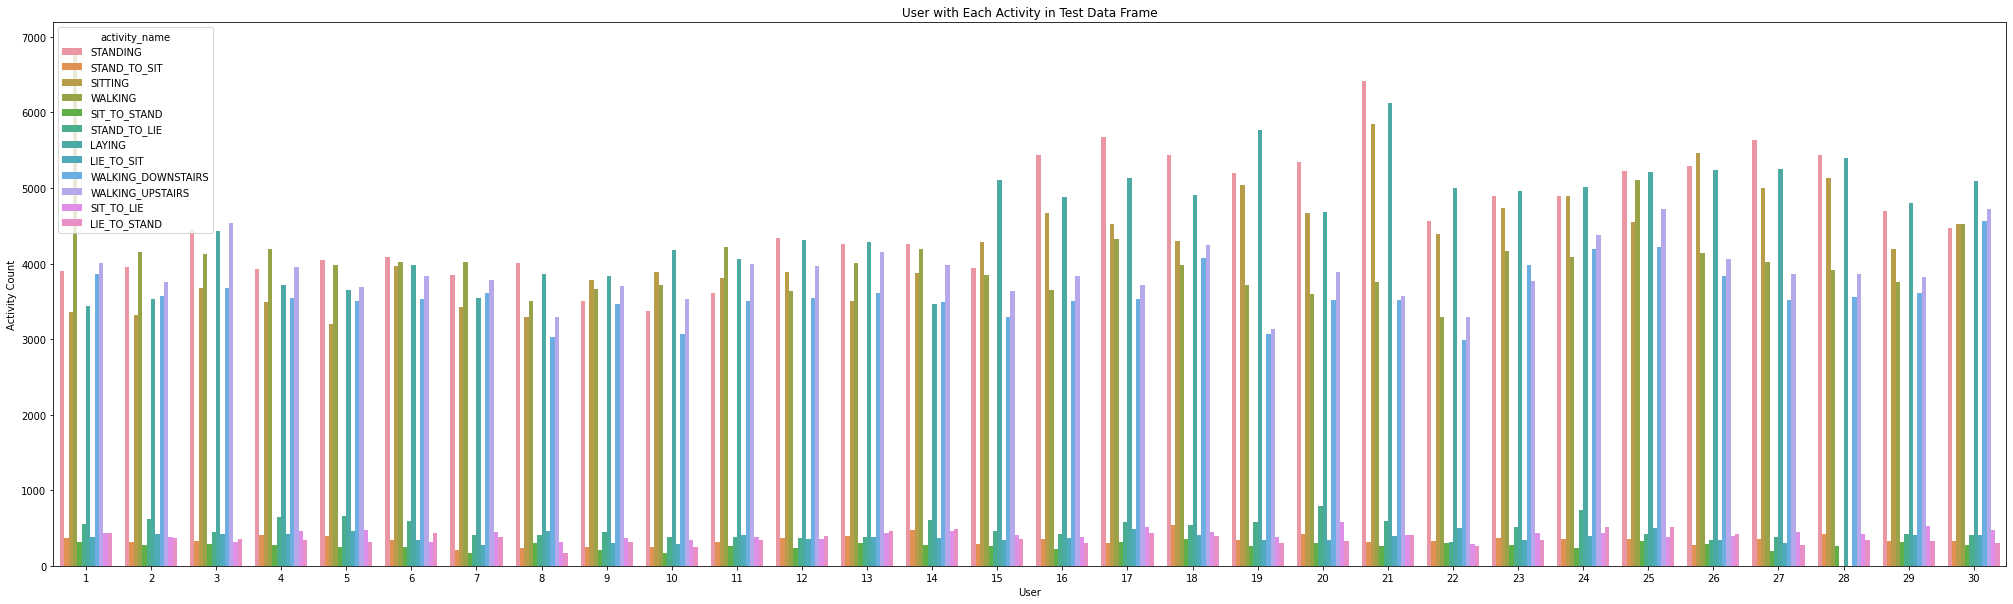

In [ ]:
_plot_count(
    x='user_id',
    hue='activity_name',
    data=df,
    plt_title='User with Each Activity in Test Data Frame',
    x_label ='User',
    y_label='Activity Count',
    figsize_w= 35,
    figsize_h= 10)

In [ ]:
# All activities for Usre1
# Create a mask to select the rows with the desired conditions
mask = (df["user_id"] == 1)

# Select the rows that match the mask and display the records
user01_df = df.loc[mask]

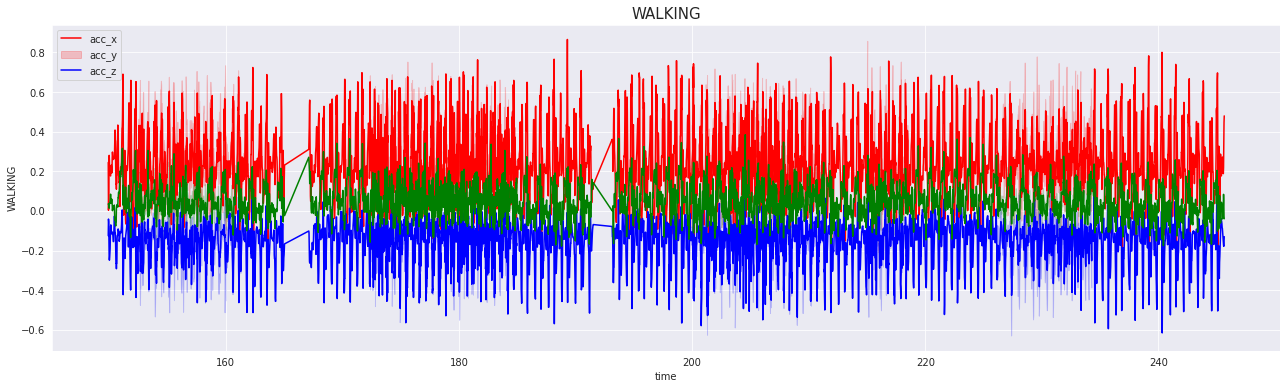

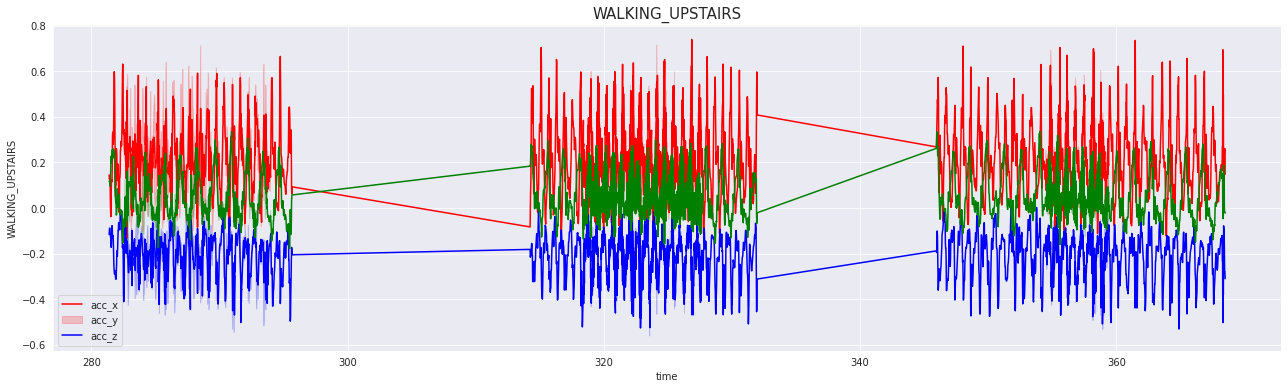

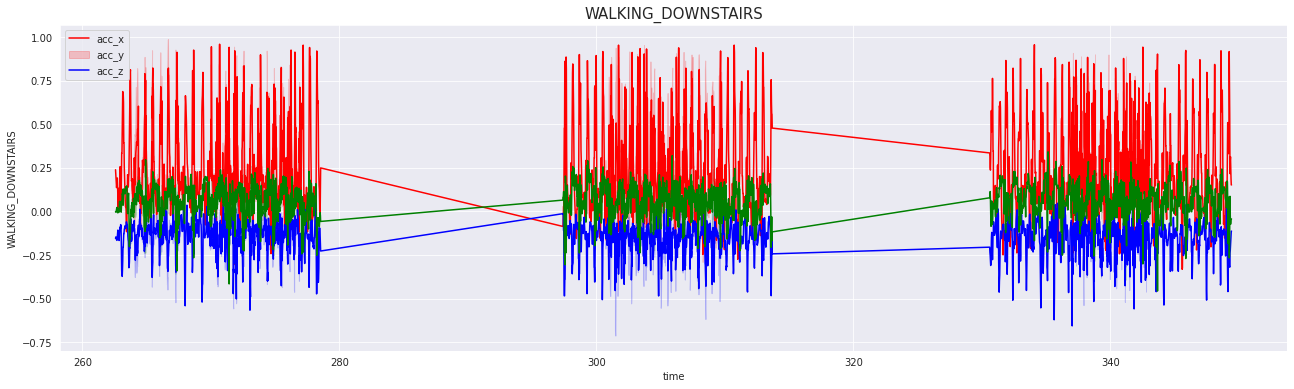

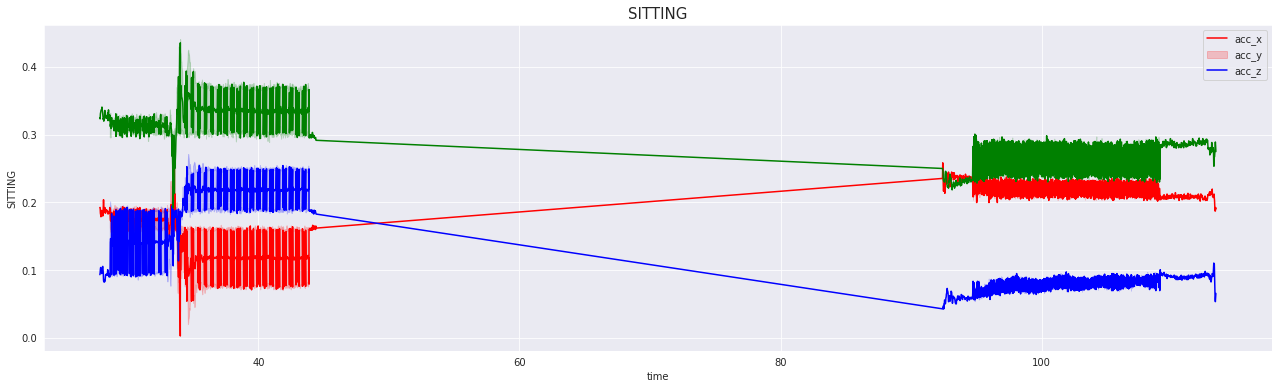

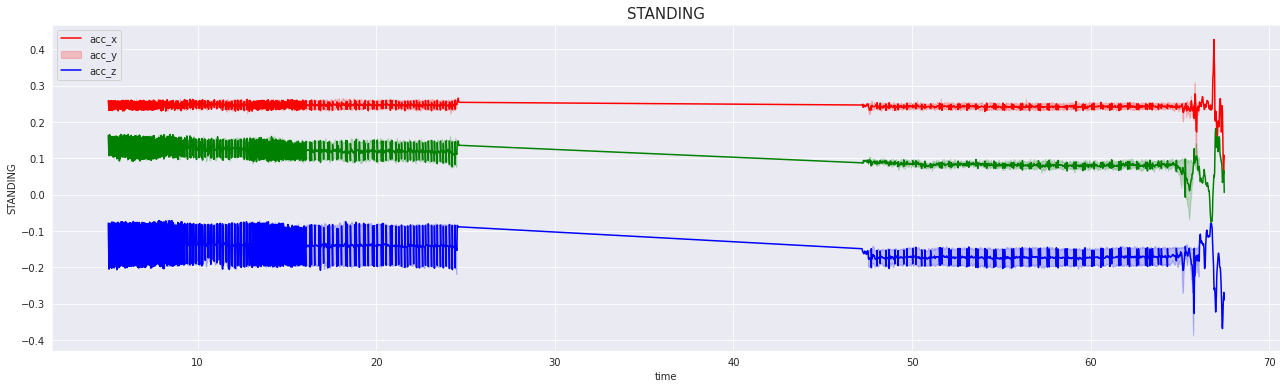

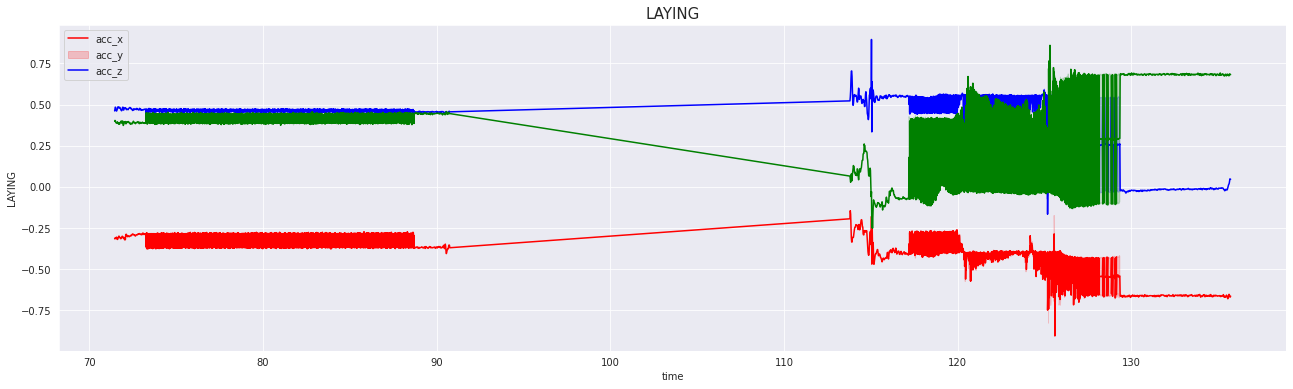

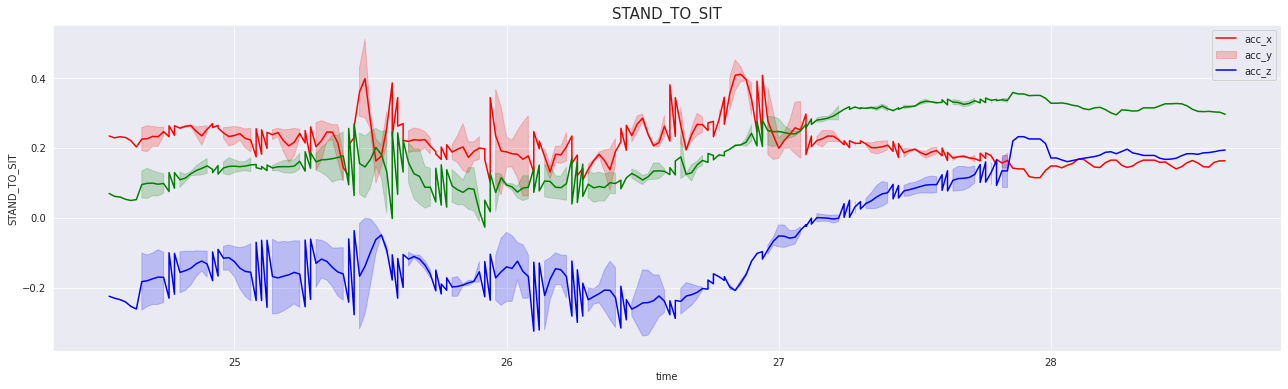

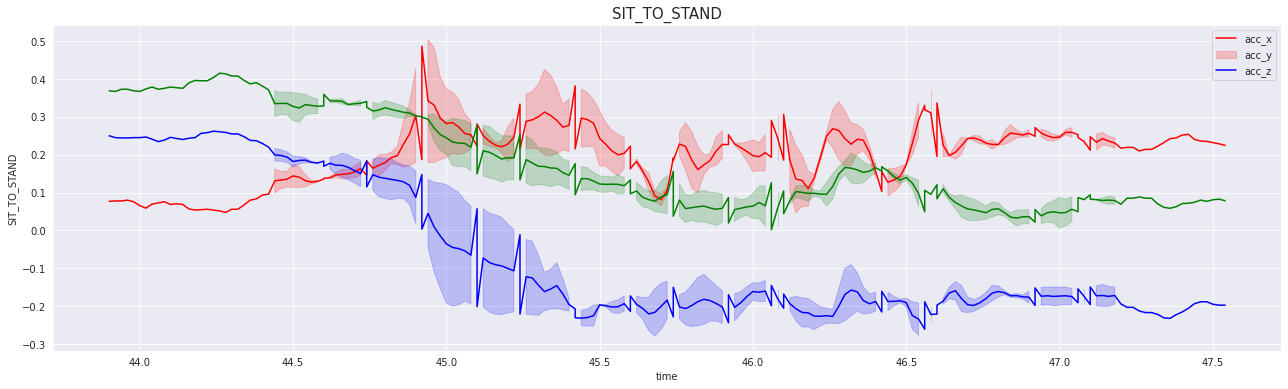

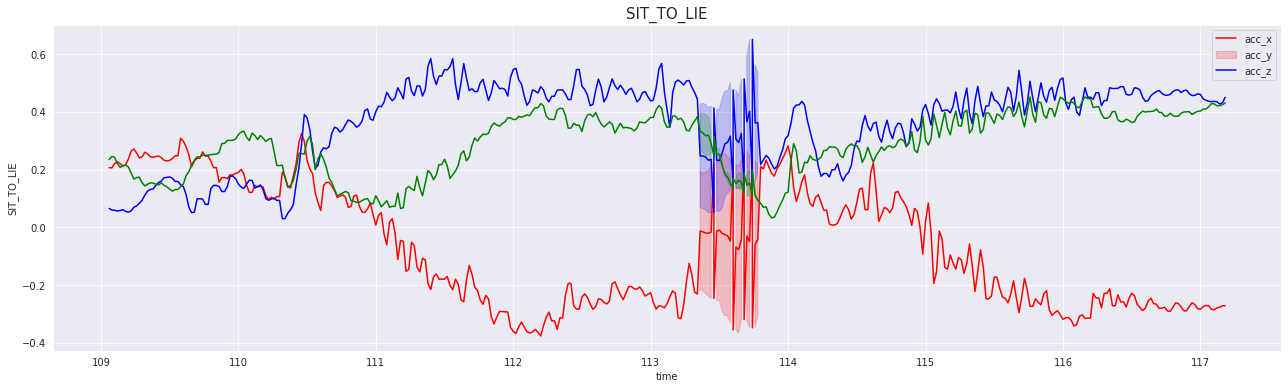

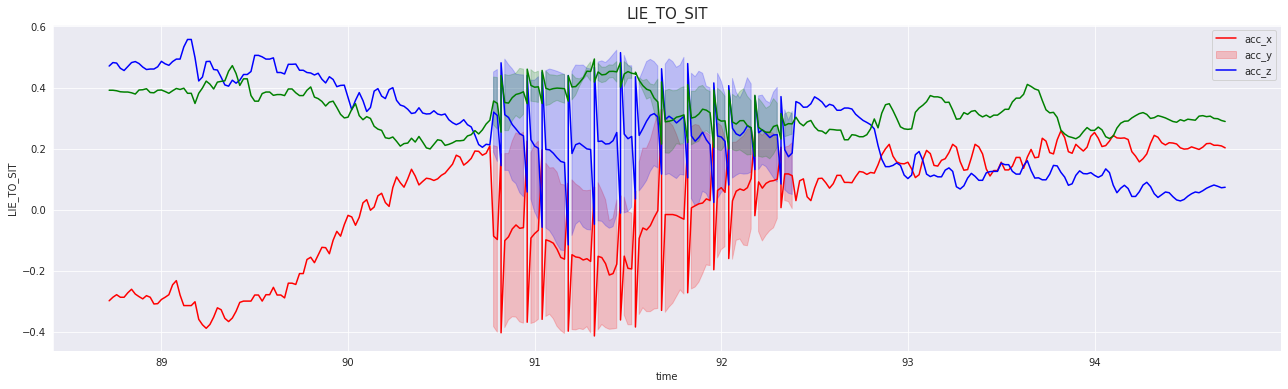

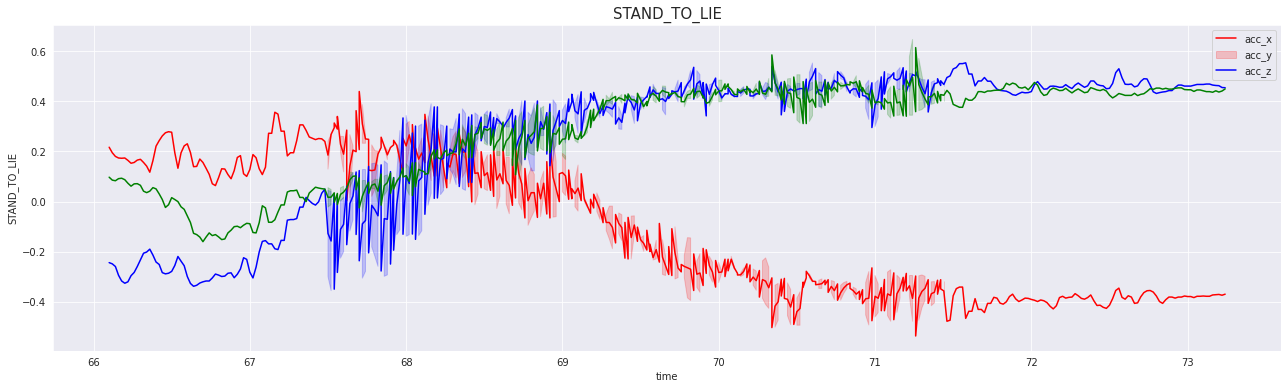

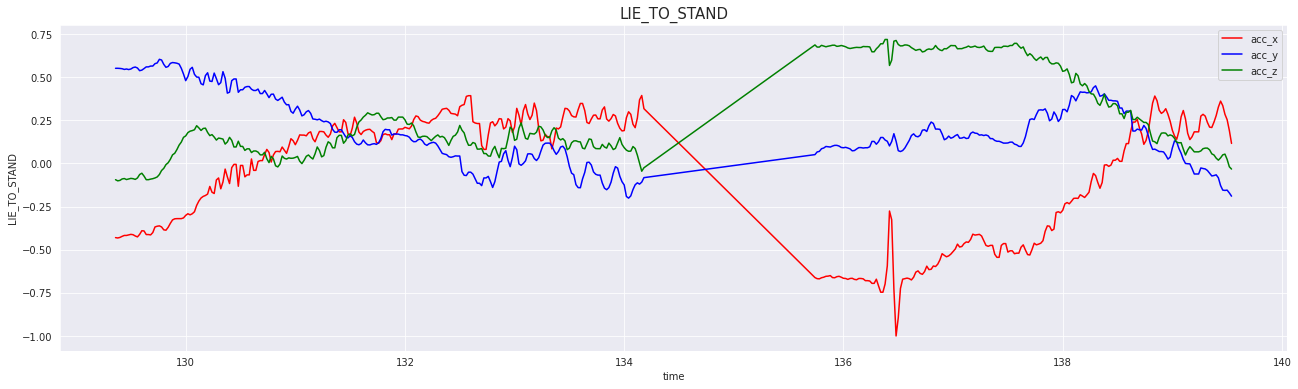

In [ ]:
activities = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING','STAND_TO_SIT','SIT_TO_STAND','SIT_TO_LIE','LIE_TO_SIT','STAND_TO_LIE','LIE_TO_STAND'];
colors=['r','b','g']

# the signal values in each of the acc_x, acc_y, and acc_z dimensions vary with time.
for i in activities:
    plt.figure(figsize = (22,6))
    data = df[(df['user_id'] == 1) & (df['activity_name'] == i)]
    sns.lineplot(y = 'acc_x', x = 'time', data = data,color='r')
    sns.lineplot(y = 'acc_y', x = 'time', data = data,color='b')
    sns.lineplot(y = 'acc_z', x = 'time', data = data,color='g')
    plt.legend(['acc_x', 'acc_y', 'acc_z'])
    plt.ylabel(i)
    plt.title(i, fontsize = 15)
    plt.show()

In [ ]:
# Select rows where activity_id is greater than 6
mask = df['activity_id'] > 6

# Update the activity_id and activity_name columns
df.loc[mask, 'activity_id'] = 7
df.loc[mask, 'activity_name'] = 'POS'

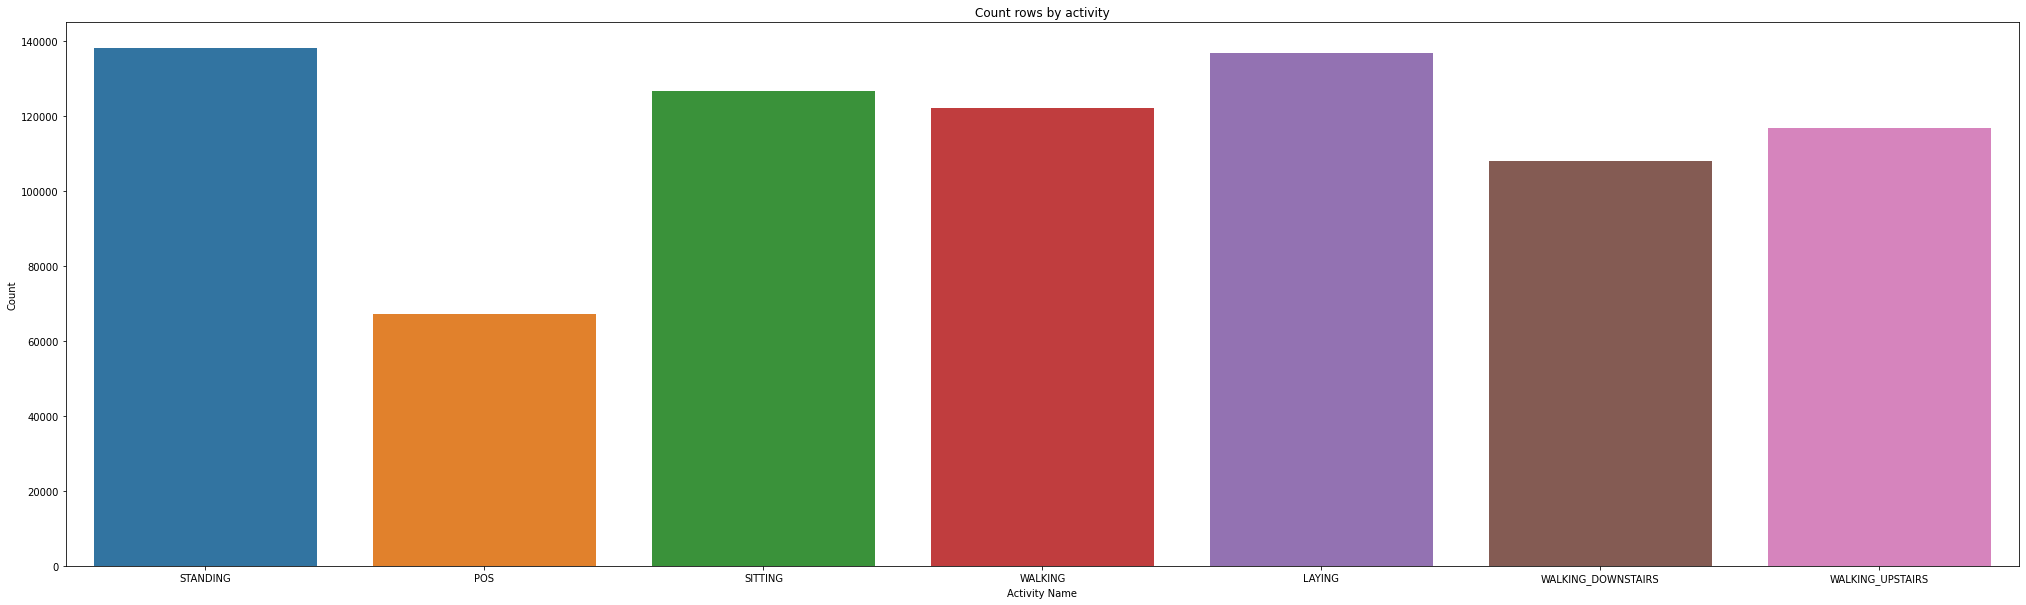

In [ ]:
_plot_count(
    x='activity_name',
    data=df,
    plt_title='Count rows by activity',
    x_label ='Activity Name',
    y_label='Count',
    figsize_w= 35,
    figsize_h= 10)

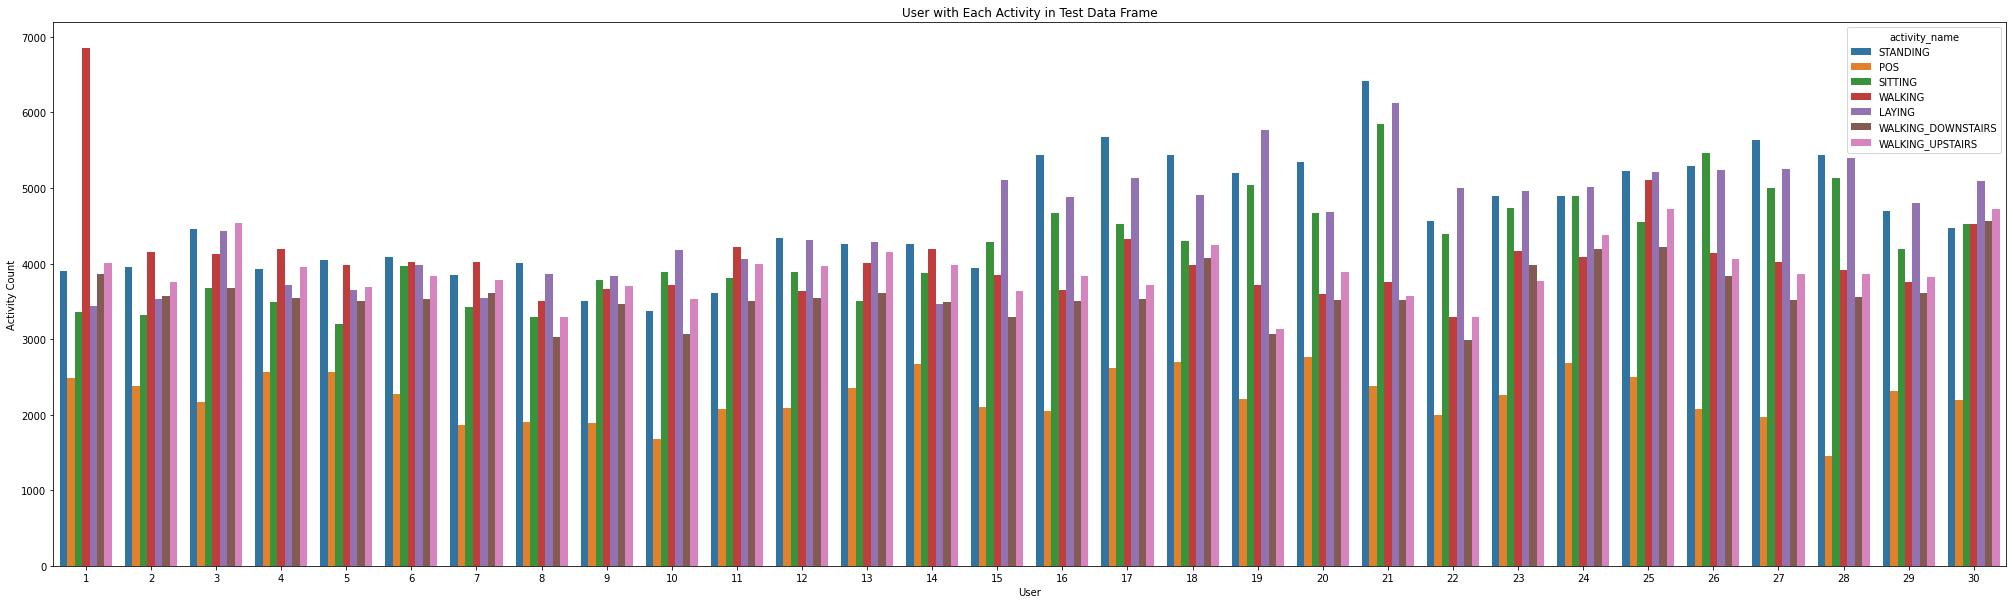

In [ ]:
_plot_count(
    x='user_id',
    hue='activity_name',
    data=df,
    plt_title='User with Each Activity in Test Data Frame',
    x_label ='User',
    y_label='Activity Count',
    figsize_w= 35,
    figsize_h= 10)

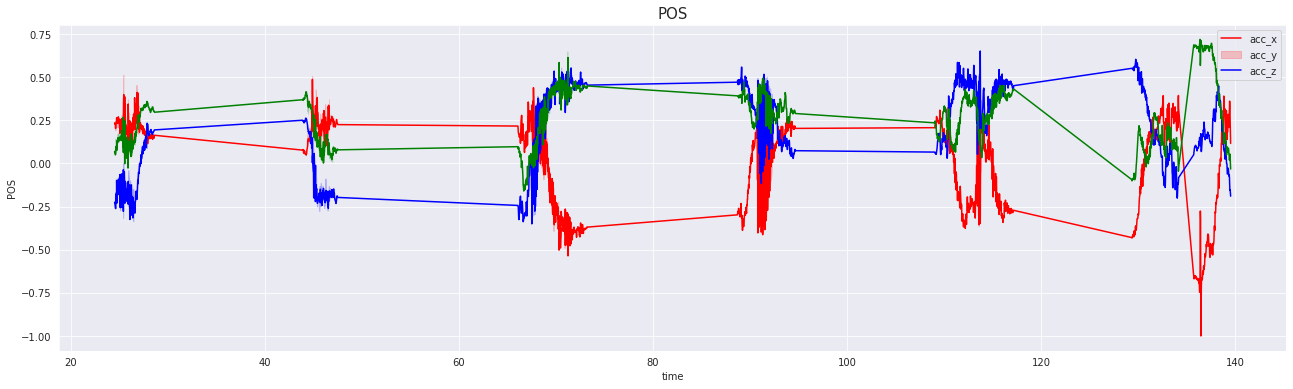

In [ ]:
plt.figure(figsize = (22,6))
data = df[(df['user_id'] == 1) & (df['activity_name'] == 'POS')]
sns.lineplot(y = 'acc_x', x = 'time', data = data,color='r')
sns.lineplot(y = 'acc_y', x = 'time', data = data,color='b')
sns.lineplot(y = 'acc_z', x = 'time', data = data,color='g')
plt.legend(['acc_x', 'acc_y', 'acc_z'])
plt.ylabel('POS')
plt.title('POS', fontsize = 15)
plt.show()

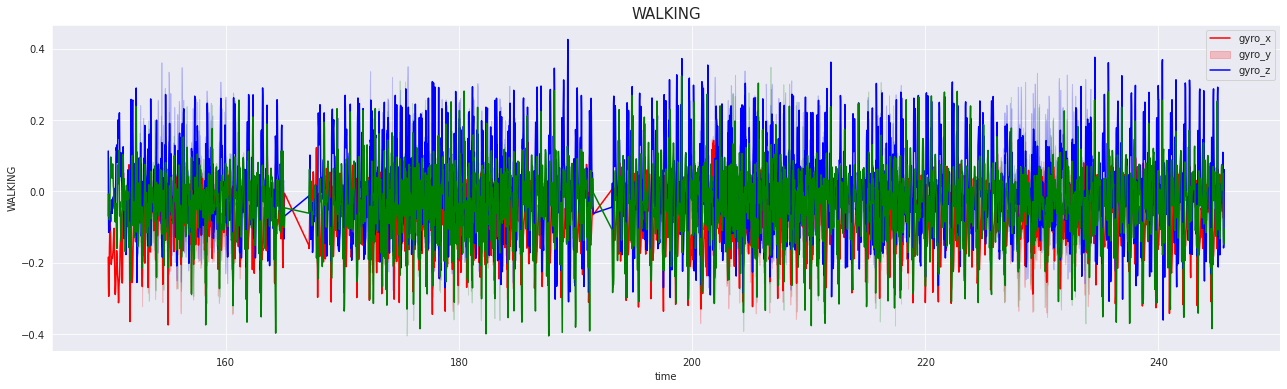

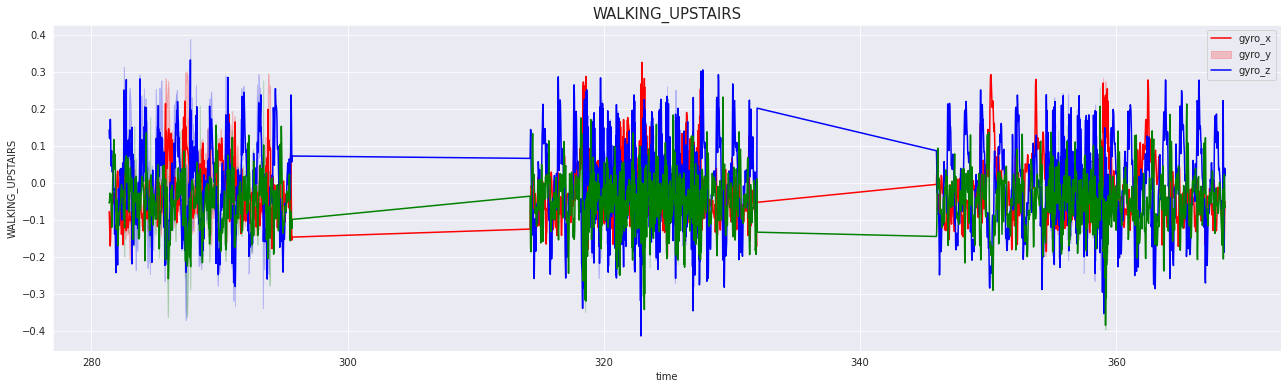

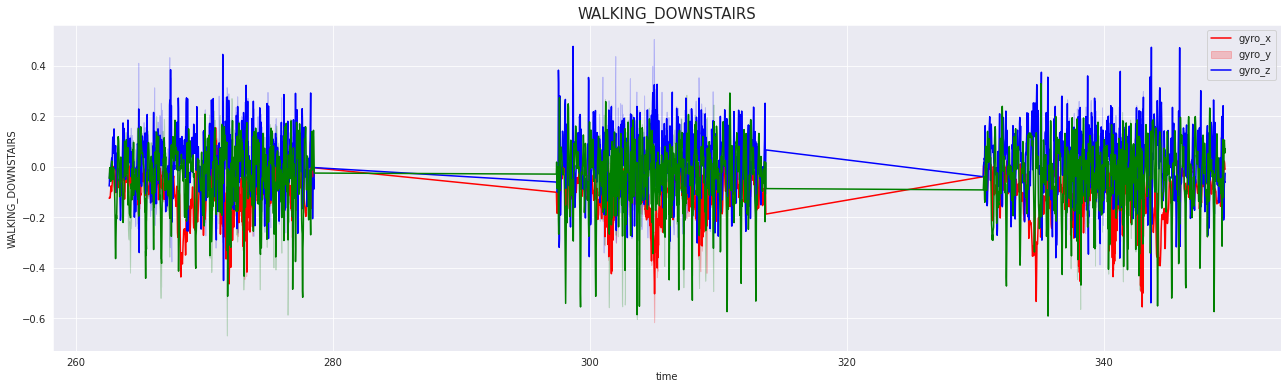

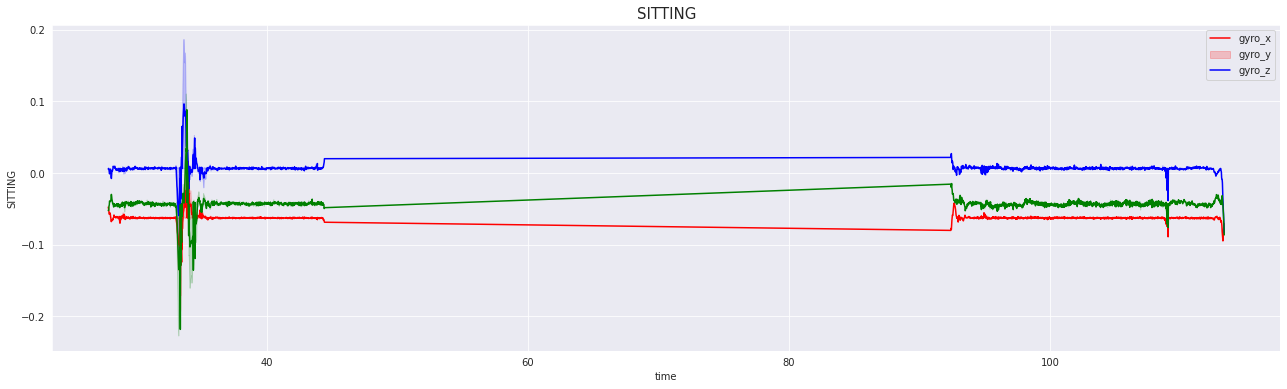

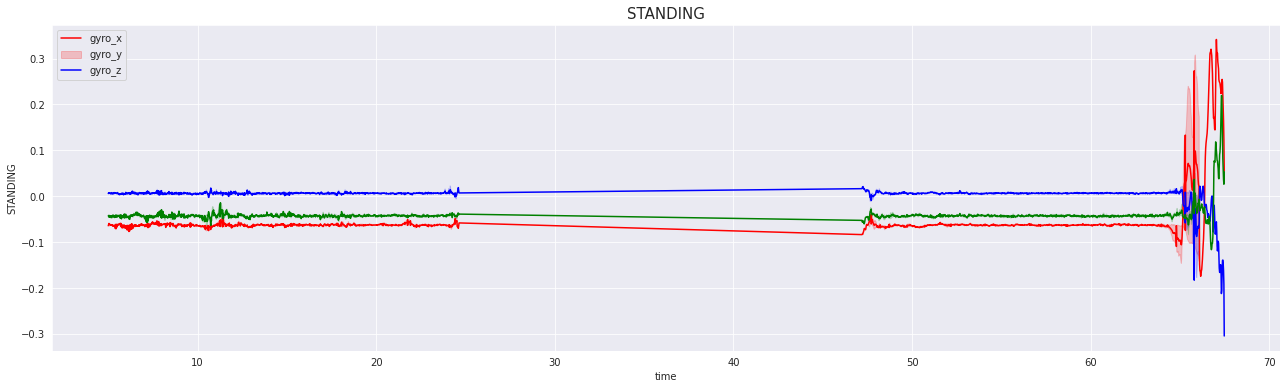

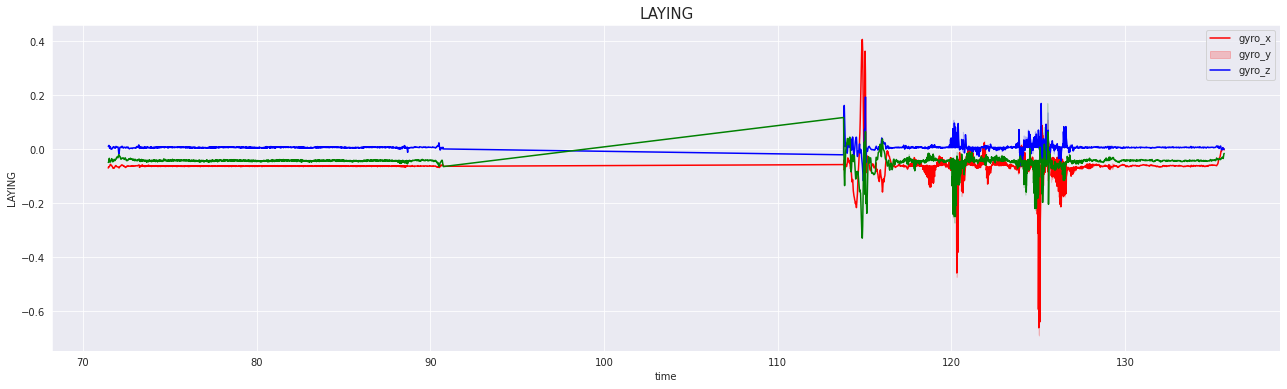

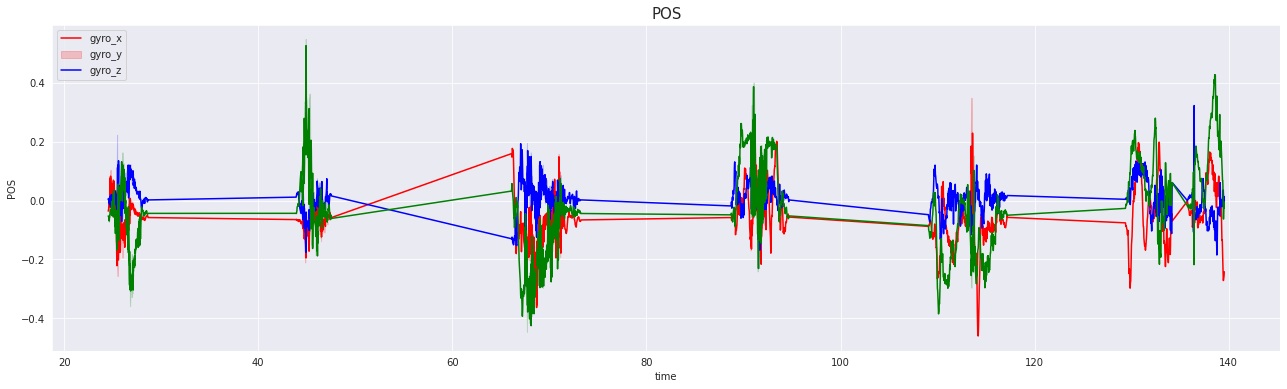

In [ ]:
activities = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING','POS'];
# the signal values in each of the gyro_x, gyro_y, and gyro_z dimensions vary with time.
for i in activities:
    plt.figure(figsize = (22,6))
    data = df[(df['user_id'] == 1) & (df['activity_name'] == i)]
    sns.lineplot(y = 'gyro_x', x = 'time', data = data,color='r')
    sns.lineplot(y = 'gyro_y', x = 'time', data = data,color='b')
    sns.lineplot(y = 'gyro_z', x = 'time', data = data,color='g')
    plt.legend(['gyro_x', 'gyro_y', 'gyro_z'])
    plt.ylabel(i)
    plt.title(i, fontsize = 15)
    plt.show()

## Training

In [ ]:
random_seed = 40   
n_features = 3 
n_epochs = 100       
batch_size = 1024 

#n_classes = 7 
#learning_rate = 0.0025
#l2_loss = 0.0015

In [ ]:
n_time_steps = 150
step = 50 
x_col= 'acc_x'
y_col='acc_y'
z_col = 'acc_z'
label_col = 'activity_name'
input = []
target = []

In [ ]:
for i in range(0,  df.shape[0]- n_time_steps, step):  

    acc_xs = df[x_col].values[i: i + n_time_steps]

    acc_ys = df[y_col].values[i: i + n_time_steps]

    acc_zs = df[z_col].values[i: i + n_time_steps]

    label = stats.mode(df[label_col][i: i + n_time_steps])[0][0]

    input.append([acc_xs, acc_ys, acc_zs])

    target.append(label)

In [ ]:
target = np.asarray(pd.get_dummies(target), dtype = np.float32)

In [ ]:
input_data = np.asarray(input, dtype= np.float32).reshape(-1, n_time_steps, n_features)

In [ ]:
input_data.shape

(16310, 150, 3)

In [ ]:
target.shape

(16310, 7)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_data, target, test_size = 0.2, random_state = random_seed)

In [ ]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5)) 
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


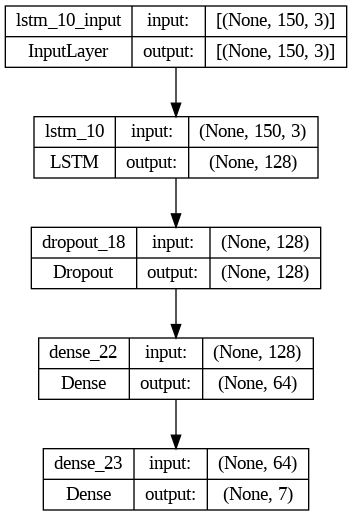

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(X_train, y_train, epochs = n_epochs, validation_split = 0.20, batch_size = batch_size, verbose = 1)

Epoch 1/100
11/11 [==============================] - 27s 89ms/step - loss: 1.8699 - accuracy: 0.2084 - val_loss: 1.7188 - val_accuracy: 0.2602
Epoch 2/100
11/11 [==============================] - 0s 45ms/step - loss: 1.7398 - accuracy: 0.3006 - val_loss: 1.7332 - val_accuracy: 0.2908
Epoch 3/100
11/11 [==============================] - 0s 45ms/step - loss: 1.6588 - accuracy: 0.3152 - val_loss: 1.5998 - val_accuracy: 0.2943
Epoch 4/100
11/11 [==============================] - 0s 45ms/step - loss: 1.5271 - accuracy: 0.3223 - val_loss: 1.4814 - val_accuracy: 0.2992
Epoch 5/100
11/11 [==============================] - 0s 44ms/step - loss: 1.4264 - accuracy: 0.3613 - val_loss: 1.3787 - val_accuracy: 0.4096
Epoch 6/100
11/11 [==============================] - 0s 44ms/step - loss: 1.3004 - accuracy: 0.4797 - val_loss: 1.2003 - val_accuracy: 0.5019
Epoch 7/100
11/11 [==============================] - 0s 45ms/step - loss: 1.1356 - accuracy: 0.5477 - val_loss: 1.0631 - val_accuracy: 0.5981
Epoch

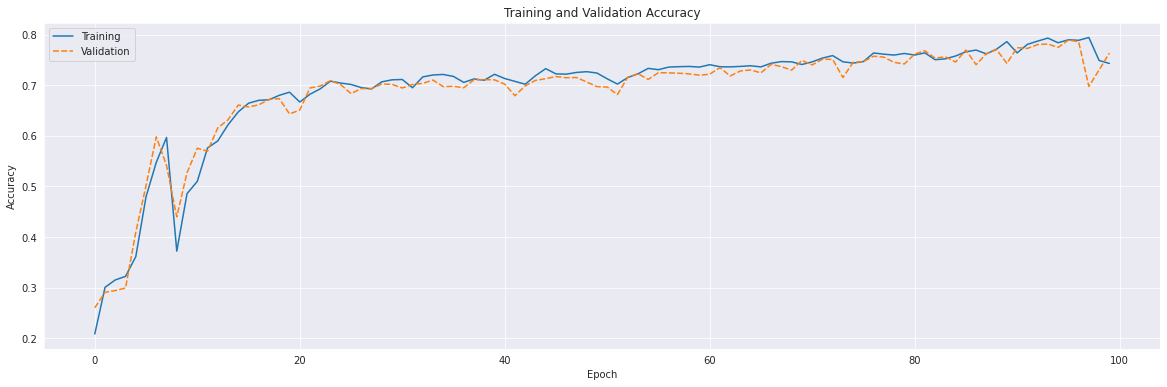

In [ ]:
# convert history dictionary to Pandas DataFrame
history_df = pd.DataFrame(history.history)

# plot training and validation accuracy separately
sns.set_style("darkgrid")
plt.figure(figsize=(20, 6))
plt.title("Training and Validation Accuracy")
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(labels=['Training', 'Validation'])
plt.show()

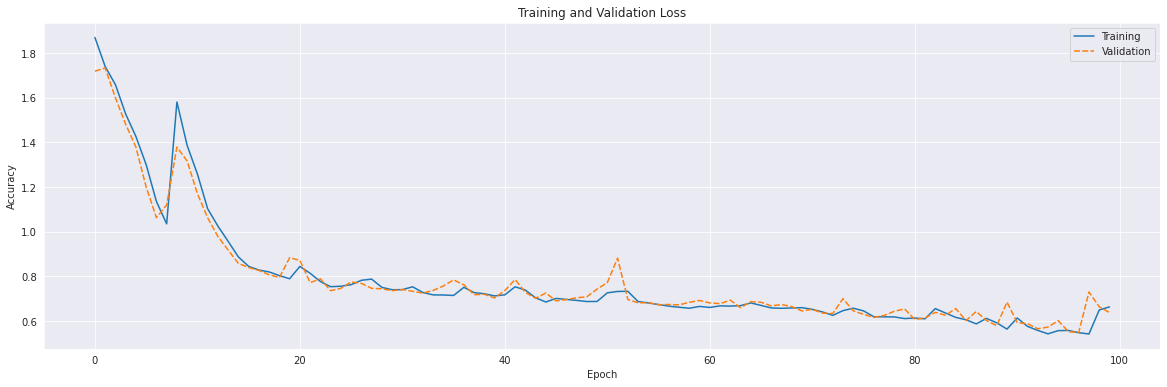

In [ ]:
# plot training and validation accuracy separately
sns.set_style("darkgrid")
plt.figure(figsize=(20, 6))
plt.title("Training and Validation Loss")
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(labels=['Training', 'Validation'])
plt.show()